# Import Packages

In [1]:
import os
import numpy as np
import pandas as pd 
import matplotlib as mpl
from matplotlib import pyplot  as plt
import seaborn as sns
import sklearn as sk
import lightgbm as lgb
import xgboost as xgb
import joblib
import time
from scipy.stats import beta, chisquare, norm, truncnorm, chi2_contingency, chi2, poisson
from scipy.optimize import curve_fit

from collections import OrderedDict
from sklearn import tree, neural_network
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV, cross_val_score, validation_curve, learning_curve, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, roc_curve, auc, make_scorer, precision_recall_curve, precision_score, recall_score, f1_score
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler




#Import Experimental Features
# explicitly require this experimental feature
from sklearn.experimental import enable_halving_search_cv # noqa
# now you can import normally from model_selection
from sklearn.model_selection import HalvingGridSearchCV

# First we need to merge our two data files into 1 dataset with class labels.
Our data comes into 2 seperate files, each named something with "signal" and "background" respectively. What we want to do now, is creating a data set for training.

This i will accomplish by first creating a new column in each dataset, which i will call classlabel, where every entry is 1 for the signal file, and where every entry is 0 for our background file.

The two files can then be merged into one large training dataset.

Lastly, i will remove from the dataset all of the variables that i have already used in the pre-selection, as they have already been used, and therefore (according to supervisor) will have no effect on the machine learning.

## First we get the data files

In [2]:
#Lower code is only if using Colab
#from google.colab import drive #Mount my drive
#drive.mount('/content/drive')

In [3]:
#path='/content/drive/MyDrive/Fysik KU/Bachelorproject/'

And put them into DataFrames

In [4]:
filteredSignal=pd.read_csv('https://raw.githubusercontent.com/svendstar/BachelorProject/main/SignalData_Filtered_v2')
filteredBackground=pd.read_csv('https://raw.githubusercontent.com/svendstar/BachelorProject/main/BackgroundData_Filtered_v2')

In [5]:
#Next we join the arrays for signal and background into one huge training set, by creating a new column in each, labeling the data coming from signal as " signal", and background as "background"
#First: We remove "background_" from the headers of the background data, this is to join the signal and background sets
#This is to make our training dataset.
filteredBackground.columns=filteredBackground.columns.str.replace('background_', '')

In [6]:
filteredBackground=filteredBackground.assign(classlabel=[0]*filteredBackground.shape[0]) #Here we assign a new Header to the data, labeling it as Background
filteredSignal=filteredSignal.assign(classlabel=[1]*filteredSignal.shape[0]) #Here we assign a new Header to the data, labeling it as Signal

In [7]:
Dataset=pd.concat([filteredSignal, filteredBackground], ignore_index=True)
Dataset

E_lep1  charge_lep1     pt_lep1   MET_phi  pdgID_lep1  eta_lep2  \
0       58.888645          1.0   17.817818 -1.400539        13.0  0.050519   
1       26.256067          1.0   26.076639  1.051155        13.0 -1.433999   
2       28.894409          1.0   22.050611 -1.231298        13.0 -1.424925   
3       31.612097          1.0   30.543903 -0.271365        13.0 -0.117301   
4       56.789352         -1.0   21.296206 -1.205340        13.0 -1.168027   
...           ...          ...         ...       ...         ...       ...   
57519  402.175690         -1.0  401.815002 -0.088332        11.0 -0.508298   
57520  189.288010         -1.0  186.875473 -0.025956        11.0  1.359117   
57521   80.721535          1.0   34.871559 -1.415067        13.0  1.929282   
57522  320.651154          1.0   69.201897 -0.302402        13.0 -0.065479   
57523  117.975960          1.0   20.875340 -0.619633        11.0  0.037706   

          E_lep2  charge_lep2  phi_lep1    pt_lep2  ...  phi_lep2  eta_lep1  \
0      14.800492         -1.0 -1.788786  14.781626  ... -0.149822 -1.864880   
1      44.428673         -1.0  1.843905  20.040913  ... -0.951540 -0.117174   
2      46.068790          1.0  2.986081  20.949476  ... -0.505754 -0.768784   
3      17.399763         -1.0 -2.515764  17.280739  ...  1.379133 -0.263684   
4      37.030022         -1.0  2.651983  21.000200  ... -0.185034 -1.636795   
...          ...          ...       ...        ...  ...       ...       ...   
57519   4.720034          1.0  1.792073   4.168638  ... -1.351432 -0.042368   
57520  37.377968          1.0 -1.529944  18.014965  ...  2.665179 -0.160513   
57521  37.812035         -1.0 -0.888326  10.757616  ...  0.854960 -1.482173   
57522   9.364443          1.0  1.251530   9.343808  ... -2.670123 -2.214620   
57523  10.937425         -1.0 -2.329654  10.929144  ... -1.972199  2.417139   

           ETmet  pdgID_lep3     E_lep3  eta_lep3  phi_lep3  charge_lep3  \
0      11.237282        13.0  11.956089  0.466462  2.017848          1.0   
1      20.760523        13.0  11.206508  0.772823  1.142607          1.0   
2      18.311977        11.0  19.934681 -1.178145 -2.080120         -1.0   
3      10.376346        13.0  15.264160  0.139053  0.116933          1.0   
4      30.800148        11.0  26.100422 -1.917034  2.616636          1.0   
...          ...         ...        ...       ...       ...          ...   
57519  22.786278        13.0  12.707087  1.943090  3.137633          1.0   
57520  39.685612        13.0   6.852844 -0.493334 -1.424582          1.0   
57521  39.996609        13.0   6.788376 -1.443104 -1.877808          1.0   
57522  28.397295        11.0   5.664144 -0.082319 -2.699335         -1.0   
57523  71.213074        13.0   3.955087  0.208600 -1.716252         -1.0   

         pt_lep3  classlabel  
0      10.763264           1  
1       8.529532           1  
2      11.211247           1  
3      15.117406           1  
4       7.513289           1  
...          ...         ...  
57519   3.567506           0  
57520   6.095151           0  
57521   3.036930           0  
57522   5.645007           0  
57523   3.869188           0  

[57524 rows x 22 columns]

And Finally, we remove the variables already used in the Preselection: **Charge**, **pdgID** & **n_bjets**.

In [8]:
#Below Line Drops Information we have already used (Charge and ID).
data=Dataset.drop(columns=['charge_lep1','charge_lep2','charge_lep3','pdgID_lep1','pdgID_lep2','pdgID_lep3','n_bjets'])

In [9]:
filteredSignal.columns

Index(['E_lep1', 'charge_lep1', 'pt_lep1', 'MET_phi', 'pdgID_lep1', 'eta_lep2',
       'E_lep2', 'charge_lep2', 'phi_lep1', 'pt_lep2', 'n_bjets', 'pdgID_lep2',
       'phi_lep2', 'eta_lep1', 'ETmet', 'pdgID_lep3', 'E_lep3', 'eta_lep3',
       'phi_lep3', 'charge_lep3', 'pt_lep3', 'classlabel'],
      dtype='object')

# Now we are finished preparing our data, we can start the Machine Learning part

## Defining Custom Functions


In [10]:
def points(fpr_or_tpr,thresholds,interval):
    """Interval must be a tuple (lower, upper) of bound between 0 and 1."""
    
    dist=[] #Prepare a container for all datapoints
    
    #start looping over the different arrays in the list.
    for array, t in zip(fpr_or_tpr,thresholds):
        
        #Makes a bin of threshold values, chooses index where the thresholds is between 2 different values in ascending order.
        index=np.argwhere((t[:]>=interval[0]) & (t[:]<=interval[1]))
        
        #takes all of the false positive rates within that bin, and adds them to the distribution.
        dist.append(array[index])
    
    return np.concatenate(dist).ravel()

In [11]:
def intervalation(array):
    """
    Assumes array is has values between 0 and 1
    Returns sorted array, and the differences between values
    """
    #Get intervals between each array value
    array=np.sort(array) #sort ascending
    array=np.insert(array, 0, 0, axis=None)[:-1] #add a 0 at the beginning, and remove last element
    
    array_difference=np.diff(array) #difference in thershold values, size is ofc 1 less.
    array_difference=np.append(array_difference,1) #add 1 at the end, now same size as array.
    return array, array_difference

In [12]:
def means_for_variable(independent_list,dependent_list):
    """
    Parameters(many_x,many_y)
    Calculates average and std of y for each value of x
    """
    
    #choose array on which to evaluate the intervals
    intervals,difference=intervalation(independent_list[42]) #for simplicity i choose 42, otherwise i would have to take the means.
    
    
    means=[]  
    stds=[]    
    n=1
    
    #We have to know how long the function takes to run
    timecheck0=time.time()
    
    #Get all FPR and TPR values between thresholds, calculate mean and std
    for value , diff in zip(intervals,difference):
        
        #Get distribution of tpr_points in all arrays within fpr interval      
        dependent_distribution=points(dependent_list,independent_list,(value,value+diff))
        
        #Calculate mean and standard deviation of distribution       
        dependent_mean = np.mean(dependent_distribution)      
        dependent_std= np.std(dependent_distribution)      
        
        #Append Results
       
        means.append(dependent_mean)
        stds.append(dependent_std)
        
        #Help me know how far the function has come        
        if n%200==0:
            
            timecheck=time.time() #Check How much time passed.
            timediff=timecheck-timecheck0
            print(f" Time Passed: {timediff:0.1f}s, Time Left: {(len(intervals)-len(means))/(len(means)/timediff):0.1f}s")
            print('Thresholds Evaluated = ',n)
        n+=1
              
    return np.array(intervals) , np.array(means) , np.array(stds)

In [13]:
#Here i Create my own custom scorer.

def precision_at_threshold(y_true, y_score, threshold):
    precision, _, thresholds = precision_recall_curve(y_true, y_score)
    return np.max(precision[1:][ threshold >= thresholds[0::10] ])

precision_at_threshold_score = make_scorer(precision_at_threshold, needs_threshold=True, threshold=0.9)

In [14]:
def average_roc_curve(clf, X, y, n_splits=10, n_repeats=100):
    """Returns n_splits*n_repeats fprs,tprs, and thresholds"""
    cv=RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats)
    
    X=X.to_numpy()
    y=y.to_numpy()
    
    t1,t2,t3=[],[],[]
    
    timecheck0=time.time()
    
    
    for train_index, test_index in cv.split(X,y):
        X_train, y_train = X[train_index], y[train_index]
        X_test, y_test = X[test_index], y[test_index]
        clf.fit(X_train,y_train)
        fpr, tpr, thresholds=roc_curve(y_test,clf.predict_proba(X_test)[:,1])
        
        t1.append(fpr)
        t2.append(tpr)
        t3.append(thresholds)
        
        timecheck=time.time() #Check How much time passed.
        timediff=timecheck-timecheck0
        
        print(f"Fits Done: {len(t1)}. Fits Left: {n_repeats*n_splits-len(t1)}")
        print(f" Time Passed: {timediff:0.1f}s, Time Left: {(n_repeats*n_splits-len(t1))/(len(t1)/timediff):0.1f}s")
        
    return t1,t2,t3

In [15]:
def mean_std_roc(fprs,tprs,thresholds):
    """Returns the mean ROC curves with Standard Deviation
    Params:
    fprs= list of Arrays containing False Positive Rates
    tprs= list of Arrays containing True Positive Rates
    """
    
    def findmax(array):
        ass=[]
        for a in range(len(array)):
            ass.append(array[a].shape[0])    
        return np.max(ass)
    
    def interpolate(array,n):
        xvals=np.linspace(0,len(array[n])-1,findmax(array))
        array_interpolated=np.interp(xvals,np.arange(len(array[n])),array[n])        
        return array_interpolated
    
    def meanroc(array):
        interpolations=[]
        for n in range(len(array)):
            interpolated=interpolate(array,n)
            interpolations.append(interpolated)
            
        return np.average([x for x in interpolations],axis=0)

    def stdroc(array):
        interpolations=[]
        for n in range(len(array)):
            interpolated=interpolate(array,n)
            interpolations.append(interpolated)
            
        return np.std([x for x in interpolations],axis=0)                        
        
    return (meanroc(fprs),meanroc(tprs)),(stdroc(fprs),stdroc(tprs))

In [16]:
#Now we want to make a histogram of the probability for data we know is background.
def OutputDistribution(model,X_test_,y_test_,cutoff=None,bins_=100,nature='dataframe',scale='linear',alpha=1,edgecolor='k',sidebyside=False,density=False,grid=True):

  if nature=='dataframe':
    isSignal=(y_test_==1) #Gets boolean array where Signal is replaced by True
    signalIndex=y_test_[isSignal].index #Gets the Pandas index value
    signalPosition=y_test_.index.get_indexer(signalIndex) #Gets the position of matrix element that had the Index value

    isBackground=(y_test_==0)
    backgroundIndex=y_test_[isBackground].index #Gets the Pandas index value
    backgroundPosition=y_test_.index.get_indexer(backgroundIndex) #Gets the position of matrix element that had the Index value
  
    s_prob=model.predict_proba(X_test_.iloc[signalPosition])
    b_prob=model.predict_proba(X_test_.iloc[backgroundPosition])
    
  else:
    X_test_=pd.DataFrame(X_test_)
    
    isSignal=(y_test_==1) #NGets boolean array where Signal is replaced by True
    signalIndex=y_test_[isSignal].index #NGets the Pandas index value
    signalPosition=y_test_.index.get_indexer(signalIndex) #NGets the position of matrix element that had the Index value

    isBackground=(y_test_==0)
    backgroundIndex=y_test_[isBackground].index #NGets the Pandas index value
    backgroundPosition=y_test_.index.get_indexer(backgroundIndex) #NGets the position of matrix element that had the Index value
  
    s_prob=model.predict_proba(X_test_.iloc[signalPosition]) # prob
    b_prob=model.predict_proba(X_test_.iloc[backgroundPosition]) #proby
    

  if cutoff != None:
    plt.axvline(cutoff,ls=':',color='r',label=f'Probability cutoff = {cutoff}')

  if sidebyside==True:
    plt.hist([b_prob[:,1],s_prob[:,1]],bins=bins_,label=['Background','Signal'],alpha=alpha,edgecolor=edgecolor,density=density);
  else:
    plt.hist(b_prob[:,1],bins=bins_,label='Background',alpha=alpha,edgecolor=edgecolor,density=density);
    plt.hist(s_prob[:,1],bins=bins_,label='Signal',alpha=alpha,edgecolor=edgecolor,density=density);

  if scale == 'log':
    plt.yscale('log')

  plt.xlabel('Probability of Being Classified as Signal')
  plt.ylabel('Count')
  plt.grid(grid)
  plt.legend()
  return None

In [17]:
def classtobool(classification):
  return np.array([1 if x== 'Signal' else 0 for x in classification])

In [18]:
def booltoclass(booleanarray):
  return np.array(['Signal' if x==1 else 'Background' for x in booleanarray])

In [19]:
def predictWithCutoff(classifier,X_test_,y_test,cutoff):
  return (classifier.predict_proba(X_test_)[:,1] > cutoff)

In [20]:
def Plot_ValidationCurve(estimator, X, y, param_name, param_range, groups=None, cv=None, scoring=None, n_jobs=None, pre_dispatch='all', verbose=0, error_score=np.nan, fit_params=None, return_scores=False, xscale = 'linear'):
  """Plots Curve that is filled withing 1 std"""

  train_scores, test_scores=validation_curve(estimator,
                                             X,
                                             y,
                                             param_name=param_name,
                                             param_range=param_range,
                                             groups=groups,
                                             cv=cv,
                                             scoring=scoring,
                                             n_jobs=n_jobs,
                                             pre_dispatch=pre_dispatch,
                                             verbose=verbose,
                                             error_score=error_score,
                                             fit_params=fit_params)

  train_scores_mean = np.mean(train_scores, axis=1)
  train_scores_std = np.std(train_scores, axis=1)
  test_scores_mean = np.mean(test_scores, axis=1)
  test_scores_std = np.std(test_scores, axis=1)

  if xscale == 'log':
    plt.figure(figsize=[8,6])
    plt.semilogx(param_range, train_scores_mean, label="Training score", color="darkorange",marker='D',markersize=6)
    plt.fill_between(param_range,train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="darkorange")
                     
    plt.semilogx(param_range, test_scores_mean, label="Cross-validation score", color="navy",marker='D',markersize=6)
    plt.fill_between(param_range,test_scores_mean - test_scores_std,test_scores_mean + test_scores_std,alpha=0.2,color="navy")

  else:
    plt.figure(figsize=[8,6])
    plt.plot(param_range, train_scores_mean, label="Training score", color="darkorange",marker='D',markersize=6)
    plt.fill_between(param_range,train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="darkorange")
                     
    plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="navy",marker='D',markersize=6)
    plt.fill_between(param_range,test_scores_mean - test_scores_std,test_scores_mean + test_scores_std,alpha=0.2,color="navy")

  plt.title('Validation Curve for '+str(estimator)+"; Varying the '"+param_name+"' Hyperparameter")
  plt.xlabel(param_name)
  plt.ylabel('Average_Precision_Score')
  plt.legend(loc="best")
  plt.grid(True)
  plt.show()
    

    
  if return_scores==True:
    return train_scores, test_scores

  else:
    return None

## Creating Training/Test Data

In [23]:
#First We create our Training data
data=data.sample(frac=1,random_state=27) #Shuffles the rows around randomnly.
X=data.iloc[:,:-1]
y=data.iloc[:,-1]

In [24]:
#Now we split our data into training and validation sets
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.4,stratify=y)

In [25]:
#Normalising data for the neural network
scalar=RobustScaler()
scalar.fit(X_train,y_train)
X_scaled=scalar.transform(X)
X_train_scaled=scalar.transform(X_train)
X_test_scaled=scalar.transform(X_test)

## Simple Decision Tree using DecisionTreeClassifier

In [111]:
%%time
dt_clf=tree.DecisionTreeClassifier() #Here we have defined our classifier to be a decision tree.
dt_clf.fit(X_train,y_train)
pred=dt_clf.predict(X_test)


Wall time: 653 ms


0.8691734232044936

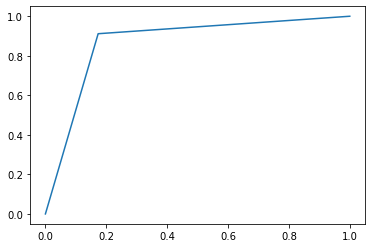

In [112]:
#RUC and AOC for dt_clf
fpr,tpr,_ = roc_curve(y_test,dt_clf.predict_proba(X_test)[:,1])
plt.plot(fpr,tpr)
auc(fpr,tpr)

### Visualizing Hyperparameters

In [20]:
dt_clf.get_params().keys()
#validation_curve(dt_clf,X_train,y_train,param_name='min_samples_split',param_range=[2,20,100,200,250,300,350,400,600],cv=5,scoring='precision')

dict_keys(['ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'random_state', 'splitter'])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  65 out of  65 | elapsed:   28.8s finished


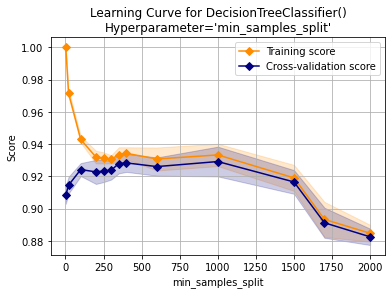

Wall time: 29.3 s


In [21]:
%%time
Plot_ValidationCurve(dt_clf,X_train,y_train,param_name='min_samples_split',param_range=[2,20,100,200,250,300,350,400,600,1000,1500,1700,2000],cv=5,scoring='precision',n_jobs=-1,verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   29.3s finished


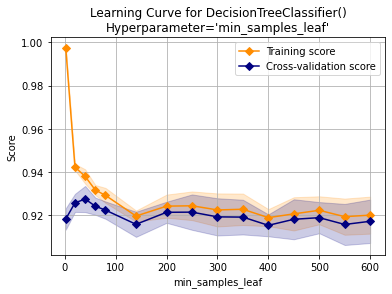

Wall time: 29.7 s


In [22]:
%%time
Plot_ValidationCurve(dt_clf,X_train,y_train,param_name='min_samples_leaf',param_range=[2,20,40,60,80,140,200,250,300,350,400,450,500,550,600],cv=10,scoring='precision',n_jobs=-1,verbose=1)


### Tuning Hyperparameters:
Gridsearch,HalvingGridSearchCV,Bayesian Optimization.

In [23]:
%%time
dt_parameters={"criterion":('gini','entropy'),
            'splitter':("best", "random"),
            'max_features':(13,5,'sqrt','log2')
            , 'min_samples_split':(2,5,20,100,200),
            'min_samples_leaf':(2,20,40,80,150)}
dt_clf=HalvingGridSearchCV(tree.DecisionTreeClassifier(),dt_parameters,scoring='precision',error_score='raise',n_jobs=-1,verbose=1)
dt_clf.fit(X_train,y_train)

n_iterations: 5
n_required_iterations: 6
n_possible_iterations: 5
min_resources_: 142
max_resources_: 34514
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 400
n_resources: 142
Fitting 5 folds for each of 400 candidates, totalling 2000 fits
----------
iter: 1
n_candidates: 134
n_resources: 426
Fitting 5 folds for each of 134 candidates, totalling 670 fits
----------
iter: 2
n_candidates: 45
n_resources: 1278
Fitting 5 folds for each of 45 candidates, totalling 225 fits
----------
iter: 3
n_candidates: 15
n_resources: 3834
Fitting 5 folds for each of 15 candidates, totalling 75 fits
----------
iter: 4
n_candidates: 5
n_resources: 11502
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Wall time: 14.4 s


HalvingGridSearchCV(error_score='raise', estimator=DecisionTreeClassifier(),
                    n_jobs=-1,
                    param_grid={'criterion': ('gini', 'entropy'),
                                'max_features': (13, 5, 'sqrt', 'log2'),
                                'min_samples_leaf': (2, 20, 40, 80, 150),
                                'min_samples_split': (2, 5, 20, 100, 200),
                                'splitter': ('best', 'random')},
                    scoring='precision', verbose=1)

In [24]:
print(dt_clf.best_params_)
dt_clf.best_estimator_

{'criterion': 'gini', 'max_features': 13, 'min_samples_leaf': 20, 'min_samples_split': 2, 'splitter': 'best'}


DecisionTreeClassifier(max_features=13, min_samples_leaf=20)

0.9478111878455464

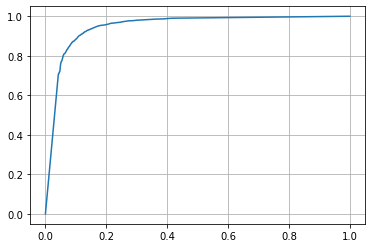

In [25]:
#RUC and AOC for tuned dt_clf
fpr,tpr,_ = roc_curve(y_test,dt_clf.predict_proba(X_test)[:,1])
plt.plot(fpr,tpr)
plt.grid(True)
auc(fpr,tpr)


## Boosted Decision Tree using LightGBM

Here i will now start using LGBM and other boosted decision trees to run the model. For each model we will need to run a K-fold cross validation and an ROC curve plus a Hyperparameter Optimization.

In [19]:
#help(lgb.train)

lgbm_clf=lgb.LGBMClassifier()

### Visualizing HyperParameters LGBM

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of 100 | elapsed:    6.4s remaining:    6.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.8s finished


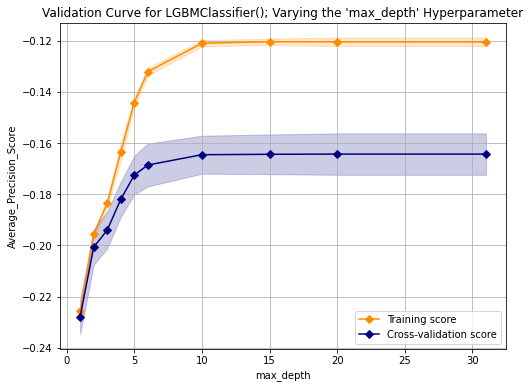

Wall time: 11.2 s


In [21]:
%%time
Plot_ValidationCurve(lgbm_clf,X_train,y_train,param_name='max_depth',param_range=[1,2,3,4,5,6,10,15,20,31],scoring='neg_log_loss',cv=10, verbose=2,n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  80 | elapsed:    3.9s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    8.1s finished


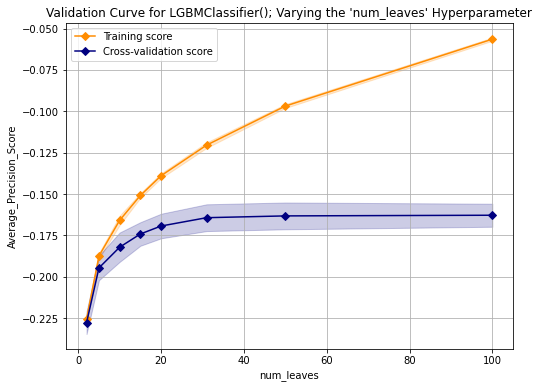

Wall time: 8.38 s


In [22]:
%%time
Plot_ValidationCurve(lgbm_clf,X_train,y_train,param_name='num_leaves',param_range=[2,5,10,15,20,31,50,100],scoring='neg_log_loss',cv=10, verbose=2,n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  70 | elapsed:    3.0s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    6.0s finished


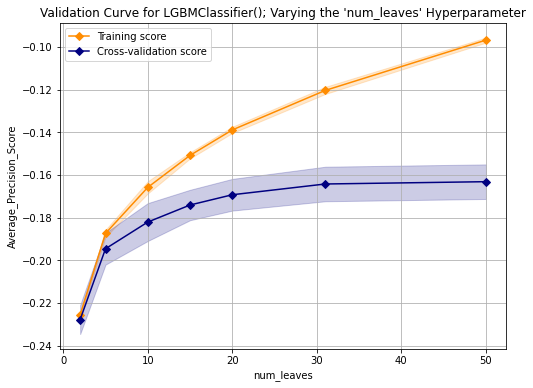

Wall time: 6.37 s


In [23]:
%%time
Plot_ValidationCurve(lgbm_clf,X_train,y_train,param_name='num_leaves',param_range=[2,5,10,15,20,31,50],scoring='neg_log_loss',cv=10, verbose=2,n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  60 | elapsed:    3.0s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    5.9s finished


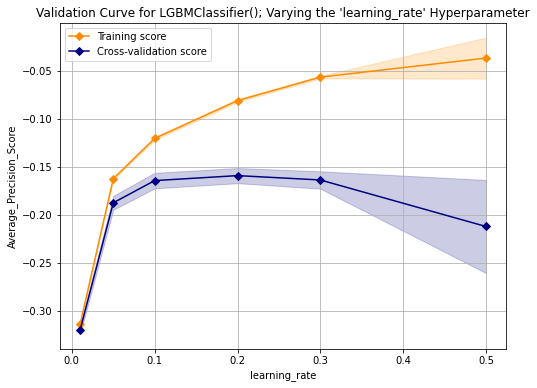

Wall time: 6.22 s


In [24]:
%%time
Plot_ValidationCurve(lgbm_clf,X_train,y_train,param_name='learning_rate',param_range=[0.01,0.05,0.1,0.2,0.3,0.5],scoring='neg_log_loss',cv=10, verbose=2,n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  70 | elapsed:    5.0s remaining:    5.0s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   12.1s finished


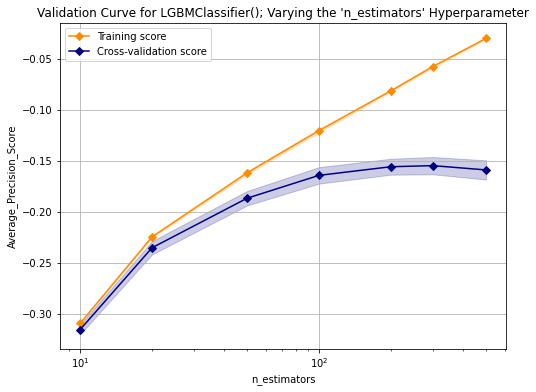

Wall time: 12.7 s


In [25]:
%%time
Plot_ValidationCurve(lgbm_clf,X_train,y_train,param_name='n_estimators',param_range=[10,20,50,100,200,300,500],scoring='neg_log_loss',xscale='log',cv=10, verbose=2,n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  50 | elapsed:    2.5s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    4.8s finished


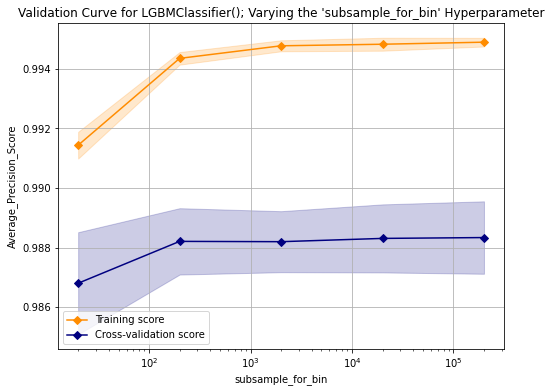

Wall time: 5.27 s


In [22]:
%%time
Plot_ValidationCurve(lgbm_clf,X_train,y_train,param_name='subsample_for_bin',param_range=[20,200,2000,20000,200000],scoring='average_precision',xscale='log',cv=10, verbose=2,n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  80 | elapsed:    4.1s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    8.1s finished


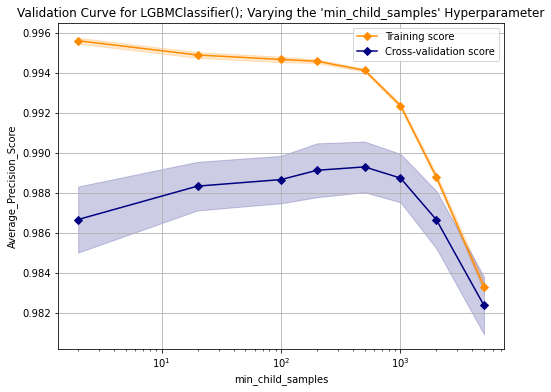

Wall time: 8.66 s


In [23]:
%%time
Plot_ValidationCurve(lgbm_clf,X_train,y_train,param_name='min_child_samples',param_range=[2,20,100,500,1000,2000,5000],scoring='average_precision',xscale='log',cv=10, verbose=2,n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  60 | elapsed:    2.8s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    5.5s finished


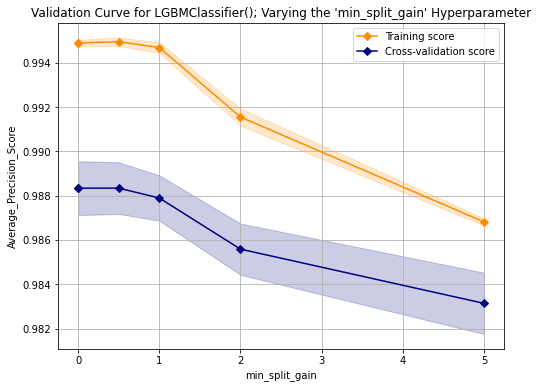

Wall time: 5.86 s


In [29]:
%%time
Plot_ValidationCurve(lgbm_clf,X_train,y_train,param_name='min_split_gain',param_range=[0,0.002,0.5,1,2,5],scoring='average_precision',xscale='linear',cv=10, verbose=2,n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  90 | elapsed:    4.3s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    8.5s finished


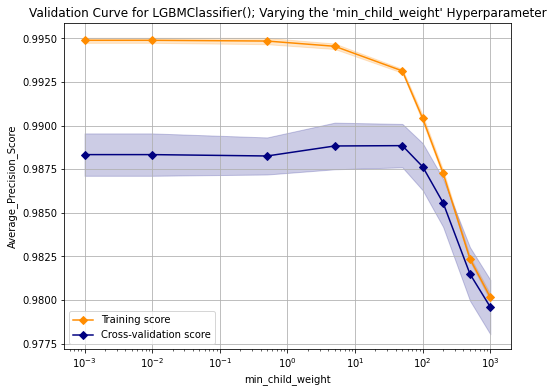

Wall time: 9.28 s


In [33]:
%%time
Plot_ValidationCurve(lgbm_clf,X_train,y_train,param_name='min_child_weight',param_range=[0.001,0.01,0.5,5,50,100,200,500,1000],scoring='average_precision',xscale='log',cv=10, verbose=2,n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  90 | elapsed:    5.1s remaining:    5.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    9.7s finished


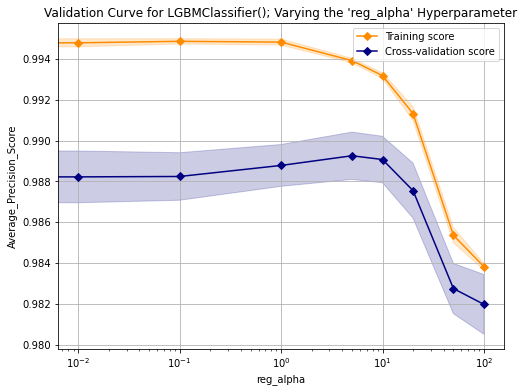

Wall time: 10.2 s


In [32]:
%%time
Plot_ValidationCurve(lgbm_clf,X_train,y_train,param_name='reg_alpha',param_range=[0,0.01,0.1,1,5,10,20,50,100],scoring='average_precision',xscale='log',cv=10, verbose=2,n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  90 | elapsed:    5.0s remaining:    5.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    9.5s finished


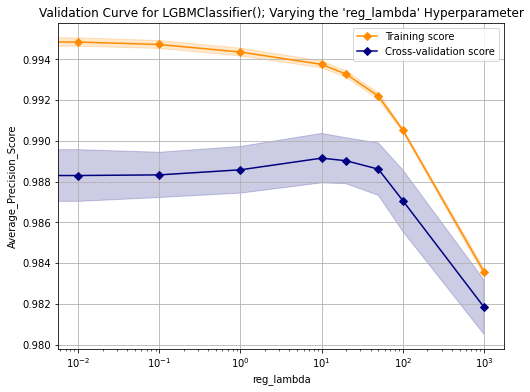

Wall time: 10.2 s


In [35]:
%%time
Plot_ValidationCurve(lgbm_clf,X_train,y_train,param_name='reg_lambda',param_range=[0,0.01,0.1,1,10,20,50,100,1000],scoring='average_precision',xscale='log',cv=10, verbose=2,n_jobs=-1)

### Tuning HyperParameters LGBM 

In [45]:
lgbm_SearchParameters={'boosting_type':['gbdt','dart','goss'],
                       'reg_lambda':[0,10],
                       'reg_alpha':[0,10],
                       'min_child_weight':[0,100],
                       'min_child_samples':[20,500,1000],
                       'n_estimators':[10,20,50,100,500],
                       'learning_rate':[0.01,0.05,0.1,0.2,0.3,0.4],
                       'max_depth':[1,5,10,-1],
                      'num_leaves':[2,10,20,31],
                      }
optimized_lgbm=HalvingGridSearchCV(lgb.LGBMClassifier(),lgbm_SearchParameters,scoring='average_precision',n_jobs=-1,verbose=2)

In [ ]:
%%time
optimized_lgbm.fit(X_train,y_train)

In [47]:
optimized_lgbm.best_params_

{'boosting_type': 'gbdt',
 'learning_rate': 0.3,
 'max_depth': 10,
 'min_child_samples': 20,
 'min_child_weight': 0,
 'n_estimators': 500,
 'num_leaves': 10,
 'reg_alpha': 0,
 'reg_lambda': 0}

#### Trying With Bayesian Optimization

In [47]:

from skopt import BayesSearchCV

lgbm_SearchParameters={'boosting_type':['gbdt','dart','goss'],
                       'reg_lambda':[0,10],
                       'reg_alpha':[0,10],
                       'min_child_weight':[0,100],
                       'min_child_samples':[20,1000],
                       'n_estimators':[1,1000],
                       'learning_rate':[0.01,0.5],
                       'max_depth':[1,2,3,4,5,6,10,15,30,100,-1],
                      'num_leaves':[2,100],
                      }
optimized_lgbm2=BayesSearchCV(lgb.LGBMClassifier(),lgbm_SearchParameters,scoring='average_precision',n_iter=150,n_jobs=-1,verbose=2,n_points=6,cv=6,error_score=0)

In [48]:
%%time
optimized_lgbm2.fit(X_train,y_train)

Fitting 6 folds for each of 6 candidates, totalling 36 fits
Fitting 6 folds for each of 6 candidates, totalling 36 fits
Fitting 6 folds for each of 6 candidates, totalling 36 fits
Fitting 6 folds for each of 6 candidates, totalling 36 fits
Fitting 6 folds for each of 6 candidates, totalling 36 fits
Fitting 6 folds for each of 6 candidates, totalling 36 fits
Fitting 6 folds for each of 6 candidates, totalling 36 fits
Fitting 6 folds for each of 6 candidates, totalling 36 fits
Fitting 6 folds for each of 6 candidates, totalling 36 fits
Fitting 6 folds for each of 6 candidates, totalling 36 fits
Fitting 6 folds for each of 6 candidates, totalling 36 fits
Fitting 6 folds for each of 6 candidates, totalling 36 fits
Fitting 6 folds for each of 6 candidates, totalling 36 fits
Fitting 6 folds for each of 6 candidates, totalling 36 fits


C:\Users\Bruger\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
1 fits failed out of a total of 36.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Bruger\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Bruger\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 967, in fit
    super().fit(X, _y, sample_weight=sample_weight, init_score=init_score, eval_set=valid_sets,
  File "C:\Users\Bruger\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 748, in fit
    self._Booster = train(
  File 

Fitting 6 folds for each of 6 candidates, totalling 36 fits
Fitting 6 folds for each of 6 candidates, totalling 36 fits
Fitting 6 folds for each of 6 candidates, totalling 36 fits
Fitting 6 folds for each of 6 candidates, totalling 36 fits
Fitting 6 folds for each of 6 candidates, totalling 36 fits
Fitting 6 folds for each of 6 candidates, totalling 36 fits
Fitting 6 folds for each of 6 candidates, totalling 36 fits
Fitting 6 folds for each of 6 candidates, totalling 36 fits
Fitting 6 folds for each of 6 candidates, totalling 36 fits
Fitting 6 folds for each of 6 candidates, totalling 36 fits
Fitting 6 folds for each of 6 candidates, totalling 36 fits
Wall time: 27min 1s


BayesSearchCV(cv=6, error_score=0, estimator=LGBMClassifier(), n_iter=150,
              n_jobs=-1, n_points=6, scoring='average_precision',
              search_spaces={'boosting_type': ['gbdt', 'dart', 'goss'],
                             'learning_rate': [0.01, 0.5],
                             'max_depth': [1, 2, 3, 4, 5, 6, 10, 15, 30, 100,
                                           -1],
                             'min_child_samples': [20, 1000],
                             'min_child_weight': [0, 100],
                             'n_estimators': [1, 1000], 'num_leaves': [2, 100],
                             'reg_alpha': [0, 10], 'reg_lambda': [0, 10]},
              verbose=2)

In [49]:
optimized_lgbm2.best_params_


OrderedDict([('boosting_type', 'dart'),
             ('learning_rate', 0.5),
             ('max_depth', 4),
             ('min_child_samples', 20),
             ('min_child_weight', 0),
             ('n_estimators', 578),
             ('num_leaves', 100),
             ('reg_alpha', 10),
             ('reg_lambda', 6)])

In [120]:
clf=lgb.LGBMClassifier()
clf.set_params(**OrderedDict([('boosting_type', 'goss'),
       ('learning_rate', 0.2),
       ('max_depth', 10),
       ('min_child_samples', 20),
       ('min_child_weight', 12),
       ('n_estimators', 500),
       ('num_leaves', 20),
       ('reg_alpha', 10),
       ('reg_lambda', 9)]))

LGBMClassifier(boosting_type='goss', learning_rate=0.2, max_depth=10,
               min_child_weight=12, n_estimators=500, num_leaves=20,
               reg_alpha=10, reg_lambda=9)

In [ ]:
plt.barh(lgbm_clf.feature_name_,lgbm_clf.feature_importances_)
lgbm_clf.feature_importances_

### Training LGBM with best hyperparemeters

**Here i list the best parameters i found, for every time i optimized the lgbm** <br />
When Scoring for Precision: <br/>
* 20/12/21, run1: Best Params were={'boosting_type': 'gbdt','learning_rate': 0.3, 'max_depth': 10, 'num_leaves': 50} <br />
* 20/12/21, run2: Best Params were= {'boosting_type': 'gbdt', 'learning_rate': 0.05, 'max_depth': -1, 'n_estimators': 400, 'num_leaves': 10}<br />
* 20/12/21, run3: Best Params were= {'boosting_type': 'goss', 'learning_rate': 0.05, 'max_depth': -1, 'min_child_samples': 2, 'n_estimators': 200, 'num_leaves': 31}<br />

**I later found out the best evaluation metric is PR-AUC, or average-precision. I got following results:** <br>
When scoring for average-precision: 
* 22/12/21: Run1 {'boosting_type': 'gbdt', 'learning_rate': 0.3, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0, 'n_estimators': 500, 'num_leaves': 20, 'reg_alpha': 0, 'reg_lambda': 0}
* 22/12/21: Run2 {'boosting_type': 'gbdt', 'learning_rate': 0.3, 'max_depth': 10, 'min_child_samples': 20, 'min_child_weight': 0, 'n_estimators': 500, 'num_leaves': 10, 'reg_alpha': 0, 'reg_lambda': 0}

**with bayesianCV:**
for Average Precision
* OrderedDict([('boosting_type', 'goss'),
             ('learning_rate', 0.2),
             ('max_depth', 10),
             ('min_child_samples', 20),
             ('min_child_weight', 12),
             ('n_estimators', 500),
             ('num_leaves', 20),
             ('reg_alpha', 10),
             ('reg_lambda', 9)])
Run2
* OrderedDict([('boosting_type', 'gbdt'),
             ('learning_rate', 0.08070423147486032),
             ('max_depth', 10),
             ('min_child_samples', 315),
             ('min_child_weight', 17),
             ('n_estimators', 869),
             ('num_leaves', 20),
             ('reg_alpha', 2),
             ('reg_lambda', 5)])
* OrderedDict([('boosting_type', 'dart'),
             ('learning_rate', 0.3902212676863154),
             ('max_depth', 30),
             ('min_child_samples', 529),
             ('min_child_weight', 28),
             ('n_estimators', 780),
             ('num_leaves', 67),
             ('reg_alpha', 5),
             ('reg_lambda', 4)])
*OrderedDict([('boosting_type', 'dart'),
             ('learning_rate', 0.5),
             ('max_depth', 4),
             ('min_child_samples', 20),
             ('min_child_weight', 0),
             ('n_estimators', 578),
             ('num_leaves', 100),
             ('reg_alpha', 10),
             ('reg_lambda', 6)])
             
For neg_log_loss
* OrderedDict([('boosting_type', 'dart'),
             ('learning_rate', 0.5),
             ('max_depth', 6),
             ('min_child_samples', 585),
             ('min_child_weight', 17),
             ('n_estimators', 550),
             ('num_leaves', 58),
             ('reg_alpha', 5),
             ('reg_lambda', 4)])

No handles with labels found to put in legend.


Wall time: 262 ms


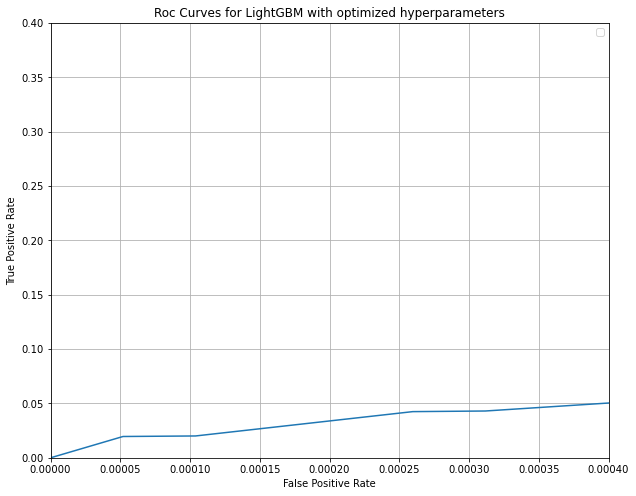

In [159]:
%%time
lgbm_list_of_best_parameters={'PRAUC':[
{'boosting_type': 'gbdt','learning_rate': 0.3, 'max_depth': 10, 'num_leaves': 50},                              
OrderedDict([('boosting_type', 'goss'),('learning_rate', 0.2),('max_depth', 10),('min_child_samples', 20),('min_child_weight', 12),('n_estimators', 500),('num_leaves', 20),('reg_alpha', 10),('reg_lambda', 9)]),                              
OrderedDict([('boosting_type', 'gbdt'),('learning_rate', 0.08070423147486032),('max_depth', 10),('min_child_samples', 315),('min_child_weight', 17),('n_estimators', 869), ('num_leaves', 20),('reg_alpha', 2), ('reg_lambda', 5)]),                        
OrderedDict([('boosting_type', 'dart'), ('learning_rate', 0.5), ('max_depth', 6),('min_child_samples', 585),  ('min_child_weight', 17),  ('n_estimators', 550), ('num_leaves', 58), ('reg_alpha', 5), ('reg_lambda', 4)]),
OrderedDict([('boosting_type', 'dart'),('learning_rate', 0.5),  ('max_depth', 4),('min_child_samples', 20), ('min_child_weight', 0), ('n_estimators', 578), ('num_leaves', 100), ('reg_alpha', 10), ('reg_lambda', 6)])],
'negative-log-loss':[
OrderedDict([('boosting_type', 'dart'),('learning_rate', 0.5),('max_depth', 6),('min_child_samples', 585),('min_child_weight', 17),('n_estimators', 550),('num_leaves', 58),('reg_alpha', 5),('reg_lambda', 4)])
]                              
}
#-----TESTING-----
lgbm_list_of_best_parameters=[
OrderedDict([('boosting_type', 'dart'),('learning_rate', 0.5),  ('max_depth', 4),('min_child_samples', 20), ('min_child_weight', 0), ('n_estimators', 578), ('num_leaves', 100), ('reg_alpha', 10), ('reg_lambda', 6)]),
OrderedDict([('boosting_type', 'dart'),('learning_rate', 0.5),  ('max_depth', 6),('min_child_samples', 585), ('min_child_weight', 17), ('n_estimators', 550), ('num_leaves', 58), ('reg_alpha', 5), ('reg_lambda', 4)])]



#Lets resample our data
data=data.sample(frac=1) #Shuffles the rows around randomnly.
X=data.iloc[:,:-1]
y=data.iloc[:,-1]
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.977,stratify=y)

#plt.figure()
#optimized_lgbm_fpr,optimized_lgbm_tpr,optimized_lgbm_thresholds=roc_curve(y_test,optimized_lgbm.predict_proba(X_test)[:,1])

#plt.semilogx(optimized_lgbm_fpr,optimized_lgbm_tpr,label=f'LGBM Boosted Trees: ; AUC={auc(optimized_lgbm_fpr,optimized_lgbm_tpr):0.3}')
#plt.grid(True)

plt.figure(figsize=(10,8))
lgbm_clf=lgb.LGBMClassifier()
#for i, params in enumerate(lgbm_list_of_best_parameters):
 #   lgbm_clf.set_params(**params)
  #  lgbm_clf.fit(X_train,y_train)
   # lgbm_fpr, lgbm_tpr, lgbm_thresholds=average_roc_curve(lgbm_clf,X_train,y_train,n_splits=2,n_repeats=1)
    
    #for x,y,aia in zip(lgbm_fpr, lgbm_tpr,lgbm_thresholds):
     #   plt.plot(x,y,label=f'LGBM Boosted Trees: set {i} ; AUC={auc(x,y):0.3}')
      #  for w,z, aio in zip(x,y,aia):
       #     plt.annotate(f'Threshold={aio:0.9E}',(w,z))
        
        
        
    #plt.ylim(0,0.15)
    #plt.xlim(0,0.0004)
    #plt.xlabel('False Positive Rate')
    #plt.ylabel('True Positive Rate')
    #plt.title('Roc Curves for LightGBM with optimized hyperparameters')
    ##plt.legend()
    #plt.grid(True)
    #plt.show()

lgbm_clf.set_params(**OrderedDict([('boosting_type', 'gbdt'),('learning_rate', 0.5),  ('max_depth', 6),('min_child_samples', 585), ('min_child_weight', 17), ('n_estimators', 550), ('num_leaves', 58), ('reg_alpha', 5), ('reg_lambda', 4)]))
lgbm_clf.fit(X_train,y_train)  

fpr, tpr, thresholds=roc_curve(y_test,lgbm_clf.predict_proba(X_test)[:,1])
plt.plot(fpr,tpr)    
plt.ylim(0,0.4)
plt.xlim(0,0.0004)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc Curves for LightGBM with optimized hyperparameters')
plt.legend()
plt.grid(True)

Wall time: 3.22 s


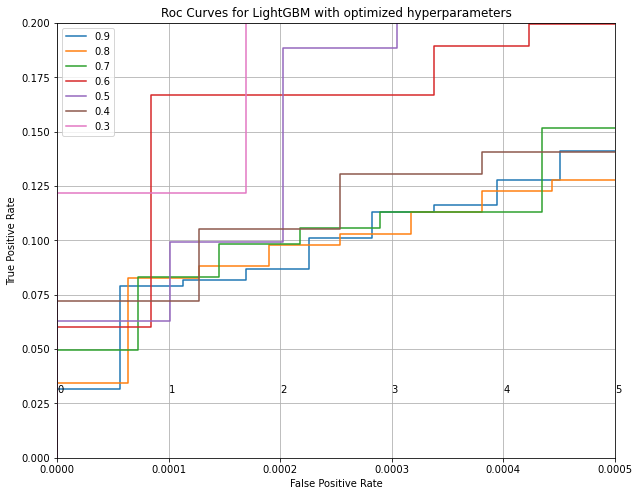

In [268]:
%%time
n=0
ts=0.9
plt.figure(figsize=[10,8])
while n < 7:
    
    X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=ts,stratify=y)
    lgbm_clf.set_params(**OrderedDict([('boosting_type', 'gbdt'),('learning_rate', 0.5),  ('max_depth', 6),('min_child_samples', 585), ('min_child_weight', 17), ('n_estimators', 550), ('num_leaves', 58), ('reg_alpha', 5), ('reg_lambda', 4)]))
    lgbm_clf.fit(X_train,y_train)  

    t=np.linspace(0.998,1,100)
    
    fpr, tpr, thresholds=my_roc_curve(y_test,lgbm_clf.predict_proba(X_test)[:,1],t)
    plt.step(fpr,tpr,label=f'{ts:0.1}')    
    plt.ylim(0,0.2)
    plt.xlim(0,0.0005)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Roc Curves for LightGBM with optimized hyperparameters')
    plt.legend()
    plt.grid(True)
    plt.annotate(f'{n}',(0.0001*n,0.03))
    ts=ts-0.1
    n+=1

In [116]:
f'heloo = {0.000000000000000000000000000123525:0.3E}'

'heloo = 1.235E-28'

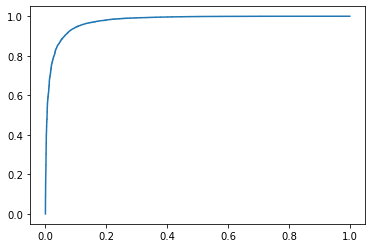

In [83]:
plt.plot(lgbm_fpr[1], lgbm_tpr[1])

In [23]:
def average_roc_curve(clf, X, y, n_splits=10, n_repeats=100):
    
    cv=RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats)
    
    X=X.to_numpy()
    y=y.to_numpy()
    
    t1,t2,t3=[],[],[]
    
    timecheck0=time.time()
    
    
    for train_index, test_index in cv.split(X,y):
        X_train, y_train = X[train_index], y[train_index]
        X_test, y_test = X[test_index], y[test_index]
        clf.fit(X_train,y_train)
        fpr, tpr, thresholds=roc_curve(y_test,clf.predict_proba(X_test)[:,1])
        
        t1.append(fpr)
        t2.append(tpr)
        t3.append(thresholds)
        
        timecheck=time.time() #Check How much time passed.
        timediff=timecheck-timecheck0
        
        print(f"Fits Done: {len(t1)}. Fits Left: {n_repeats*n_splits-len(t1)}")
        print(f" Time Passed: {timediff:0.1f}s, Time Left: {(n_repeats*n_splits-len(t1))/(len(t1)/timediff):0.1f}s")
    return t1,t2,t3

#### Okey so now we want to Calculate the average ROC CURVE for the best Hyperparameters.

In [ ]:
%%time

#Choose The CLassifier with best Parameters
#I Choose The Parameters Found with Bayesian Optimization, Opimizing for Average-Precision. Second run
best_parameters=OrderedDict([('boosting_type', 'gbdt'),('learning_rate', 0.08070423147486032),('max_depth', 10),('min_child_samples', 315),('min_child_weight', 17),('n_estimators', 869), ('num_leaves', 20),('reg_alpha', 2), ('reg_lambda', 5)])
lgbm_clf=lgb.LGBMClassifier(**best_parameters)

lgbm_best_average_fpr, lgbm_best_average_tpr, lgbm_best_average_thresholds=average_roc_curve_v2(lgbm_clf,X,y)

In [5]:
### HERE I WILL SAVE THE DATA FOR FUTURE USE!
import joblib 

#for i ,j in zip(['lgbm_best2_average_fpr', 'lgbm_best2_average_tpr', 'lgbm_best2_average_thresholds'],[lgbm_best_average_fpr, lgbm_best_average_tpr, lgbm_best_average_thresholds]):
#    joblib.dump(j,i)


In [22]:
lgbm_best_average_fpr=joblib.load('lgbm_best_average_fpr')
lgbm_best_average_tpr=joblib.load('lgbm_best_average_tpr')
lgbm_best_average_thresholds=joblib.load('lgbm_best_average_thresholds')

In [23]:
lgbm_best2_average_fpr=joblib.load('lgbm_best2_average_fpr')
lgbm_best2_average_tpr=joblib.load('lgbm_best2_average_tpr')
lgbm_best2_average_thresholds=joblib.load('lgbm_best2_average_thresholds')

Wall time: 14.3 s


(0.0, 1.2e-05)

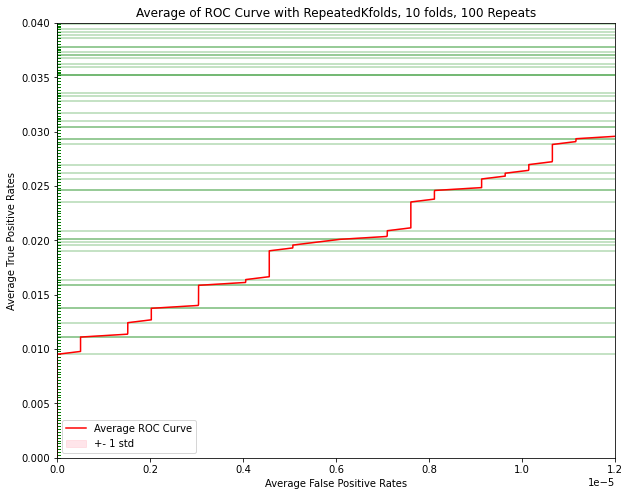

In [45]:
%%time
plt.figure(figsize=[10,8])
n=0
for n in range(1000):
    plt.plot(lgbm_best2_average_fpr[n],lgbm_best2_average_tpr[n],'g',alpha=0.3,marker='+')
    
plt.plot(*mean_std_roc(lgbm_best2_average_fpr, lgbm_best2_average_tpr, lgbm_best2_average_thresholds)[0],color='r',label='Average ROC Curve')
plt.fill_between(mean_std_roc(lgbm_best2_average_fpr, lgbm_best2_average_tpr, lgbm_best2_average_thresholds)[0][0],mean_std_roc(lgbm_best2_average_fpr, lgbm_best2_average_tpr, lgbm_best2_average_thresholds)[0][1]-mean_std_roc(lgbm_best2_average_fpr, lgbm_best2_average_tpr, lgbm_best2_average_thresholds)[1][1],mean_std_roc(lgbm_best2_average_fpr, lgbm_best2_average_tpr, lgbm_best2_average_thresholds)[0][1]+mean_std_roc(lgbm_best2_average_fpr, lgbm_best2_average_tpr, lgbm_best2_average_thresholds)[1][1],alpha=0.4,color="pink",label='+- 1 std')
plt.xlabel('Average False Positive Rates')
plt.ylabel('Average True Positive Rates')
plt.title('Average of ROC Curve with RepeatedKfolds, 10 folds, 100 Repeats')
plt.legend()
#plt.grid(True)

plt.ylim(0,0.04)
plt.xlim(0,0.000012)

#plt.ylim(0,0.6)
#plt.xlim(0,0.006)

In [222]:
a=np.asarray([1,52,6,5,2,54,3,3,1,4,1,4,1,4])
#a=-np.sort(-a)
a[np.argwhere(a==1)]

array([[1],
       [1],
       [1],
       [1]])

Text(0, 0.5, 'FPR and TPR')

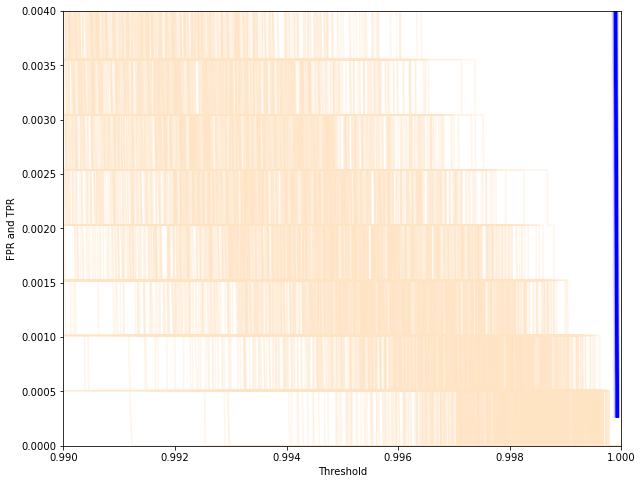

In [118]:
plt.figure(figsize=(10,8))
for n in range(1000):
    plt.plot(lgbm_best_average_thresholds[n][1:],lgbm_best_average_fpr[n][1:],'bisque',alpha=0.35)
    plt.plot(lgbm_best_average_thresholds[n][1:],lgbm_best_average_tpr[n][1:],'b',alpha=0.005)
    
plt.plot()
plt.xlim(0.99,1)
plt.ylim(0,0.004)
#plt.legend()
plt.xlabel('Threshold')
plt.ylabel('FPR and TPR')

Text(0, 0.5, 'FPR and TPR')

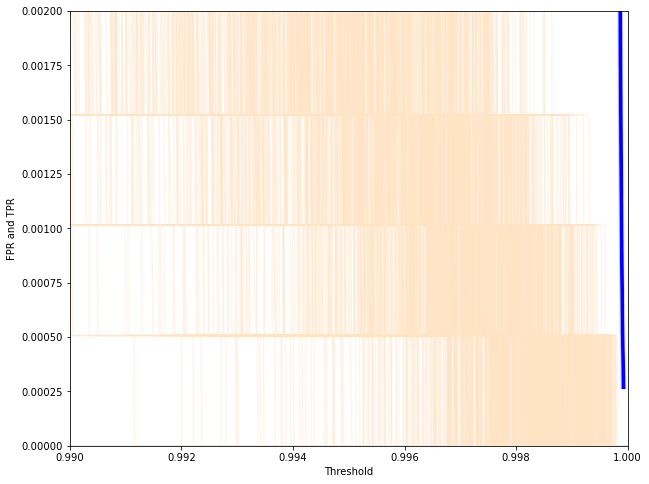

In [283]:
plt.figure(figsize=(10,8))
for n in range(1000):
    plt.plot(lgbm_best2_average_thresholds[n][1:],lgbm_best2_average_fpr[n][1:],'bisque',alpha=0.35)
    plt.plot(lgbm_best2_average_thresholds[n][1:],lgbm_best2_average_tpr[n][1:],'b',alpha=0.005)
    
plt.plot()
plt.xlim(0.99,1)
plt.ylim(0,0.002)
#plt.legend()
plt.xlabel('Threshold')
plt.ylabel('FPR and TPR')

## XGBoost

In [ ]:
xgb_clf=xgb.XGBClassifier()
xgb_clf.fit(X_train,y_train)

/home/svend/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:22:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=6,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

0.9829014013364705

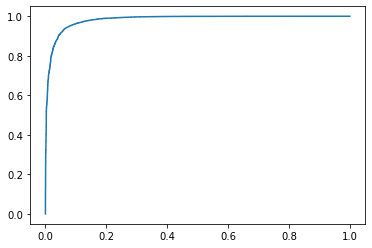

In [ ]:
xgb_score=xgb_clf.predict_proba(X_test)[:,1]

xgb_fpr,xgb_tpr,xgb_tresholds = roc_curve(y_test,xgb_score)
plt.plot(xgb_fpr,xgb_tpr)
auc(xgb_fpr,xgb_tpr)

## Neural Network using MLPClassifier

### Creating Neural Network

In [19]:
%%time
nn_clf=neural_network.MLPClassifier(max_iter=200)
#nn_clf.fit(X_train_scaled,y_train)

Wall time: 0 ns


### Preprocessing
We Must Normalize our data in order for it to best work on a neural Network. All operations with the neural network must use the Scaled Data.

In [144]:
scalar=RobustScaler()
scalar.fit(X_train,y_train)
X_scaled=scalar.transform(X)
X_train_scaled=scalar.transform(X_train)
X_test_scaled=scalar.transform(X_test)

### Visualizing Hyperparameters MultiLayer Perceptron

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 out of  25 | elapsed:   10.9s remaining:   10.1s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   37.3s finished


<Figure size 432x288 with 0 Axes>

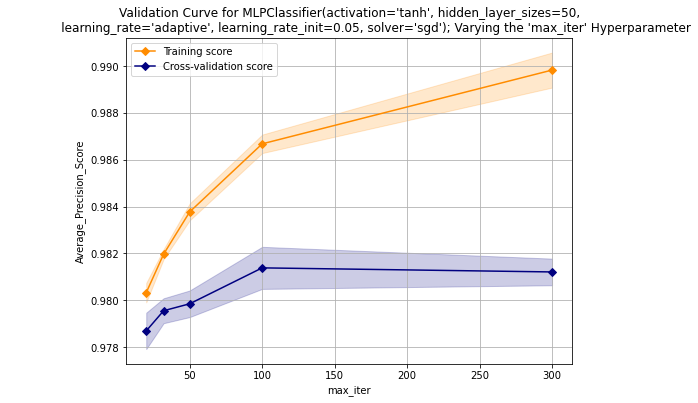

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 out of  25 | elapsed:   11.3s remaining:   10.4s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   39.3s finished


<Figure size 432x288 with 0 Axes>

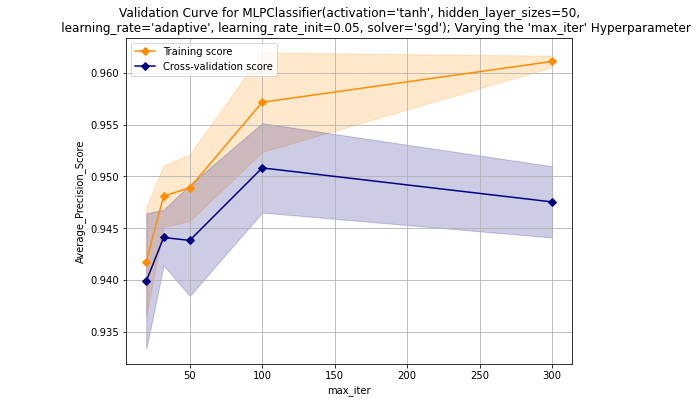

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 out of  25 | elapsed:   11.0s remaining:   10.2s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   39.2s finished


<Figure size 432x288 with 0 Axes>

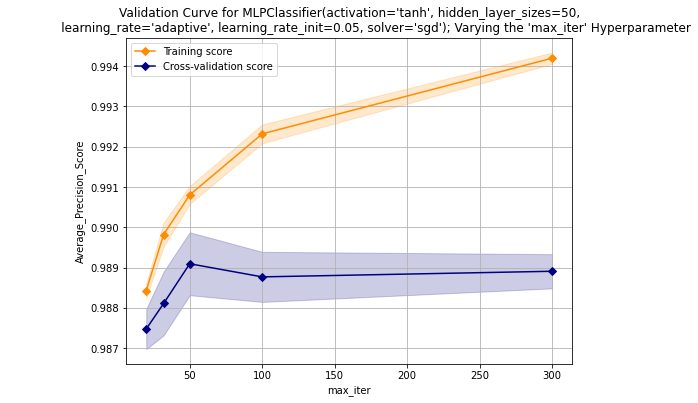

Wall time: 1min 56s


In [136]:
%%time
for scorer in ['roc_auc','precision','average_precision']:
    plt.figure()
    Plot_ValidationCurve(nn_clf,X_train_scaled,y_train,param_name='max_iter',param_range=[20,32,50,100,300],scoring=scorer,verbose=2,n_jobs=-1)
    plt.show()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  45 | elapsed:   59.1s remaining:   56.5s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.8min finished


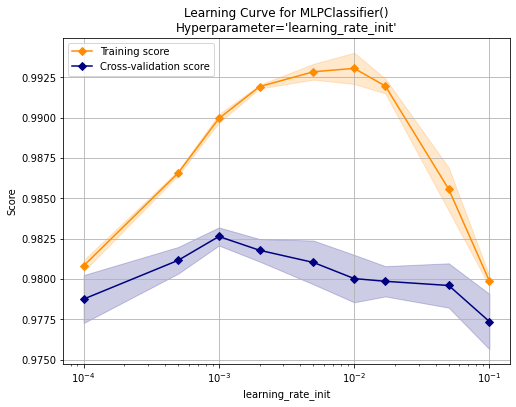

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  45 | elapsed:   56.9s remaining:   54.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.7min finished


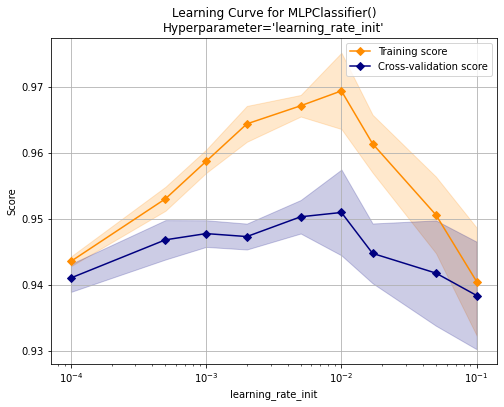

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  45 | elapsed:   58.6s remaining:   56.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.7min finished


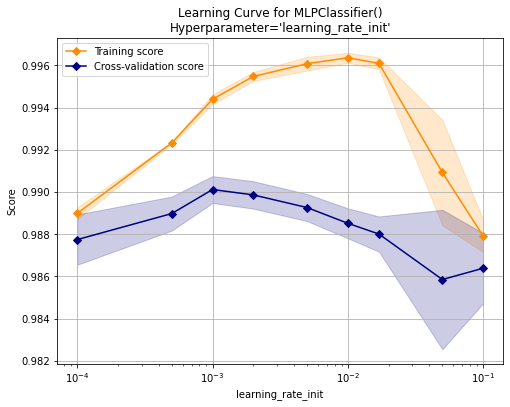

Wall time: 5min 7s


In [49]:
%%time
for scorer in ['roc_auc','precision','average_precision']:
    plt.figure(figsize=(8,6))
    Plot_ValidationCurve(nn_clf,X_train_scaled,y_train,param_name='learning_rate_init',param_range=[0.0001,0.0005,0.001,0.002,0.005,0.01,0.017,0.05,0.1],scoring=scorer,verbose=2,n_jobs=-1, xscale='log')
    plt.show()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  40 | elapsed:  6.4min remaining:  6.4min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 13.6min finished


<Figure size 576x432 with 0 Axes>

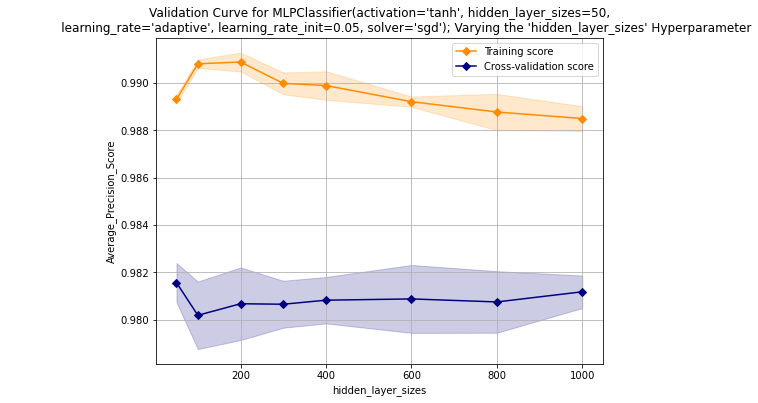

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  40 | elapsed:  6.4min remaining:  6.4min


KeyboardInterrupt: 

<Figure size 576x432 with 0 Axes>

In [137]:
%%time
for scorer in ['roc_auc','precision','average_precision']:
    plt.figure(figsize=(8,6))
    Plot_ValidationCurve(nn_clf,X_train_scaled,y_train,param_name='hidden_layer_sizes',param_range=[50,100,200,300,400,600,800,1000],scoring=scorer,verbose=2,n_jobs=-1, xscale='linear')
    plt.show()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:   41.4s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  34 out of  50 | elapsed:  1.3min remaining:   37.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.7min finished


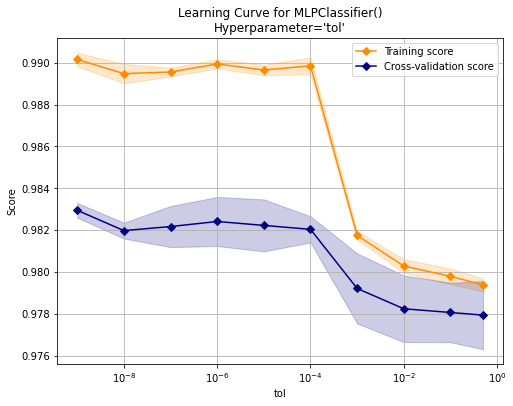

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:   40.1s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  34 out of  50 | elapsed:  1.3min remaining:   37.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.7min finished


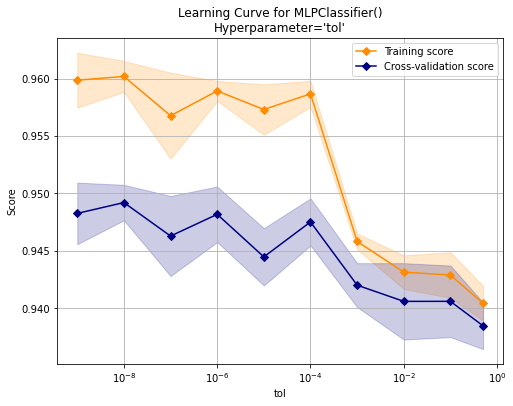

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:   40.1s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  34 out of  50 | elapsed:  1.3min remaining:   37.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.7min finished


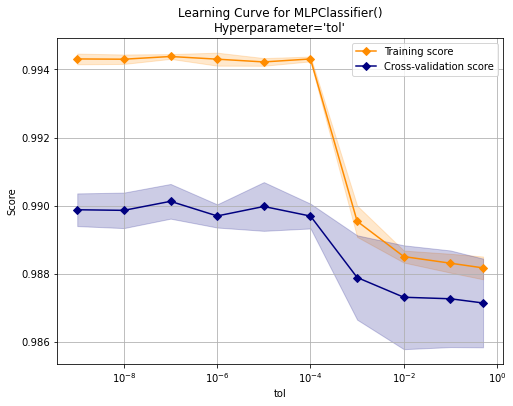

Wall time: 5min 5s


In [52]:
%%time
for scorer in ['roc_auc','precision','average_precision']:
    plt.figure(figsize=(8,6))
    Plot_ValidationCurve(nn_clf,X_train_scaled,y_train,param_name='tol',param_range=[0.000000001,0.00000001,0.0000001,0.000001,0.00001,0.0001,0.001,0.01,0.1,0.5],scoring=scorer,verbose=3,n_jobs=-1, xscale='log')
    plt.show()

%%time
nn_clf.fit(X_train_scaled,y_train)

### Tuning MLPClassifeirs Hyperparameters!

In [61]:
#Define the parameters for which we will do a gridsearch
nn_SearchParameters=[{'solver':['lbfgs'],
                      'tol':[0.00001,0.0001,0.001,0.01,0.1],
                      'hidden_layer_sizes':(50,100,200,300),
                      'max_iter':(200,300,400,600),
                      'activation':['logistic', 'tanh', 'relu']},
                     {'solver':['sgd'],
                      'tol':[0.00001,0.0001,0.001,0.01,0.1],
                      'hidden_layer_sizes':(50,100,200,300),
                      'learning_rate':['constant', 'invscaling', 'adaptive'],
                      'learning_rate_init':(0.0001,0.001,0.01,0.05),
                      'max_iter':(200,300,400,600),
                      'activation':['logistic', 'tanh', 'relu']},
                     {'solver':['adam'],
                      'tol':[0.00001,0.0001,0.001,0.01,0.1],
                      'hidden_layer_sizes':(50,100,200,300),
                      'learning_rate_init':(0.0001,0.001,0.01,0.05),
                      'max_iter':(200,300,400,600),
                      'activation':['logistic', 'tanh', 'relu']},
                    ]
#Define the gridsearch
#It will optimize for highest precision at proability_threshold=0.999, my own scorer!
nn_clf=neural_network.MLPClassifier()

In [47]:
%%time
#Perfom The grid Search and save the best model as nn_optimized
nn_optimized=HalvingGridSearchCV(nn_clf,nn_SearchParameters,scoring='average_precision',return_train_score=False,n_jobs=-1,verbose=1)
nn_optimized.fit(X_train_scaled,y_train);
best_nn_params_average_precision=nn_optimized.best_params_

n_iterations: 7
n_required_iterations: 8
n_possible_iterations: 7
min_resources_: 20
max_resources_: 34514
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 4080
n_resources: 20
Fitting 5 folds for each of 4080 candidates, totalling 20400 fits
----------
iter: 1
n_candidates: 1360
n_resources: 60
Fitting 5 folds for each of 1360 candidates, totalling 6800 fits
----------
iter: 2
n_candidates: 454
n_resources: 180
Fitting 5 folds for each of 454 candidates, totalling 2270 fits
----------
iter: 3
n_candidates: 152
n_resources: 540
Fitting 5 folds for each of 152 candidates, totalling 760 fits
----------
iter: 4
n_candidates: 51
n_resources: 1620
Fitting 5 folds for each of 51 candidates, totalling 255 fits
----------
iter: 5
n_candidates: 17
n_resources: 4860
Fitting 5 folds for each of 17 candidates, totalling 85 fits
----------
iter: 6
n_candidates: 6
n_resources: 14580
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Wall time: 10min 3s


C:\Users\Bruger\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [41]:
best_nn_params=[best_nn_params_roc_auc,best_nn_params_precision,best_nn_params_average_precision,best_nn_params_accuracy]
print(best_nn_params)

[{'activation': 'relu', 'hidden_layer_sizes': 300, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'max_iter': 200, 'solver': 'sgd', 'tol': 1e-05}, {'activation': 'relu', 'hidden_layer_sizes': 300, 'learning_rate_init': 0.01, 'max_iter': 300, 'solver': 'adam', 'tol': 0.1}, {'activation': 'tanh', 'hidden_layer_sizes': 50, 'learning_rate': 'adaptive', 'learning_rate_init': 0.05, 'max_iter': 200, 'solver': 'sgd', 'tol': 0.0001}, {'activation': 'relu', 'hidden_layer_sizes': 200, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'max_iter': 200, 'solver': 'sgd', 'tol': 1e-05}]


#### Tuning nn with Bayesian Optimization.


In [149]:
from skopt import BayesSearchCV
nn_SearchParameters=[{'solver':['lbfgs'],
                      'tol':[0.00001,0.1],
                      'hidden_layer_sizes':(50,200),
                      'max_iter':(200,600),
                      'activation':['logistic', 'tanh', 'relu'],
                     'alpha':(0.0000001,0.1)},
                     
                     {'solver':['sgd'],
                      'tol':[0.00001,0.1],
                      'hidden_layer_sizes':(20,200),
                      'learning_rate':['constant', 'invscaling', 'adaptive'],
                      'learning_rate_init':(0.0001,0.05),
                      'max_iter':(200,600),
                      'activation':['logistic', 'tanh', 'relu'],
                      'momentum':(0,0.99999),
                     'alpha':(0.0000001,0.1)},
                     
                     {'solver':['adam'],
                      'tol':[0.00001,0.1],
                      'hidden_layer_sizes':(20,200),
                      'learning_rate_init':(0.0001,0.05),
                      'max_iter':(200,600),
                      'activation':['logistic', 'tanh', 'relu'],
                     'beta_1':(0,0.99999),
                     'beta_2':(0,0.99999),
                     'epsilon':(0.00000000001,0.001),
                     'alpha':(0.0000001,0.1)}]

optimized_nn=BayesSearchCV(neural_network.MLPClassifier(),nn_SearchParameters,scoring='average_precision',n_iter=50,n_jobs=-1,verbose=2,n_points=6,cv=3,error_score=0)



In [150]:
%%time
optimized_nn.fit(X_train_scaled,y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Fitting 3 folds for each of 6 candidates, totalling 18 fits


C:\Users\Bruger\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Bruger\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 6 candidates, totalling 18 fits
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Fitting 3 folds for each of 6 candidates, totalling 18 fits


C:\Users\Bruger\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 2 candidates, totalling 6 fits
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Fitting 3 folds for each of 6 candidates, 

BayesSearchCV(cv=3, error_score=0, estimator=MLPClassifier(), n_jobs=-1,
              n_points=6, scoring='average_precision',
              search_spaces=[{'activation': ['logistic', 'tanh', 'relu'],
                              'alpha': (1e-07, 0.1),
                              'hidden_layer_sizes': (50, 200),
                              'max_iter': (200, 600), 'solver': ['lbfgs'],
                              'tol': [1e-05, 0.1]},
                             {'activation': ['logistic', 'tanh', 'relu'],
                              'alpha': (1e-07, 0.1),
                              'hidden_layer_si...
                              'learning_rate_init': (0.0001, 0.05),
                              'max_iter': (200, 600), 'momentum': (0, 0.99999),
                              'solver': ['sgd'], 'tol': [1e-05, 0.1]},
                             {'activation': ['logistic', 'tanh', 'relu'],
                              'alpha': (1e-07, 0.1), 'beta_1': (0, 0.99999),
        

In [151]:
optimized_nn.best_params_

OrderedDict([('activation', 'tanh'),
             ('alpha', 1e-07),
             ('beta_1', 0.5545561677659581),
             ('beta_2', 0.5713485660228933),
             ('epsilon', 0.000492036188902597),
             ('hidden_layer_sizes', 200),
             ('learning_rate_init', 0.02199012604107307),
             ('max_iter', 537),
             ('solver', 'adam'),
             ('tol', 0.049795769219370685)])

#### Best params found for 4 scores of nn_clf

**For scores:**
* **auc_auc**:
    1. {'activation': 'tanh', 'hidden_layer_sizes': 100, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'max_iter': 300, 'solver': 'sgd', 'tol': 0.0001}
    1. {'activation': 'relu', 'hidden_layer_sizes': 300, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'max_iter': 200, 'solver': 'sgd', 'tol': 1e-05}
    1.
* **precision**:
    1. {'activation': 'logistic', 'hidden_layer_sizes': 100, 'learning_rate_init': 0.05, 'max_iter': 400, 'solver': 'adam', 'tol': 0.1}
    1. {'activation': 'relu', 'hidden_layer_sizes': 200, 'learning_rate_init': 0.01, 'max_iter': 400, 'solver': 'adam', 'tol': 0.01}
    1. {'activation': 'relu', 'hidden_layer_sizes': 300, 'learning_rate_init': 0.01, 'max_iter': 300, 'solver': 'adam', 'tol': 0.1}
* **average_precision:**
    1. run1: {'activation': 'tanh', 'hidden_layer_sizes': 50, 'learning_rate': 'adaptive', 'learning_rate_init': 0.05, 'max_iter': 200, 'solver': 'sgd', 'tol': 0.0001}
* **accuracy:**
    1. run1: {'activation': 'relu', 'hidden_layer_sizes': 200, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'max_iter': 200, 'solver': 'sgd', 'tol': 1e-05}
<br>
<br>

**With Bayesian Optimization**
* **average-precision**
    1. OrderedDict([('activation', 'tanh'),
             ('alpha', 1e-07),
             ('beta_1', 0.5545561677659581),
             ('beta_2', 0.5713485660228933),
             ('epsilon', 0.000492036188902597),
             ('hidden_layer_sizes', 200),
             ('learning_rate_init', 0.02199012604107307),
             ('max_iter', 537),
             ('solver', 'adam'),
             ('tol', 0.049795769219370685)])


### Best Parameters for nn_clf

In [24]:
nn_optimized.best_params_
#18/12/2021: Best Parameters Were: {'hidden_layer_sizes': 300, 'learning_rate_init': 0.001, 'max_iter': 100}
print("At 18/12/2021, The Best Parameters for Neural Network Were: \n{'hidden_layer_sizes': 300, 'learning_rate_init': 0.001, 'max_iter': 100}\nAnd the training only took 2 minutes!\n")
print("19th December; best_Params_ for NN were: {'activation': 'logistic', 'hidden_layer_sizes': 100, 'learning_rate_init': 0.05, 'max_iter': 400, 'solver': 'adam', 'tol': 0.1}")
print("19th December, second try; best_Params_ for NN were: {'activation': 'relu', 'hidden_layer_sizes': 200, 'learning_rate_init': 0.01, 'max_iter': 400, 'solver': 'adam', 'tol': 0.01}")
print("19th December, second try; best_Params_, ROC_AUC, for NN were: {'activation': 'tanh', 'hidden_layer_sizes': 100, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'max_iter': 300, 'solver': 'sgd', 'tol': 0.0001}")
print("best parameters for Threshold=0.999: {'activation': 'logistic', 'hidden_layer_sizes': 300, 'learning_rate': 'invscaling', 'learning_rate_init': 0.0001, 'max_iter': 400, 'solver': 'sgd', 'tol': 0.0001}")
print(nn_optimized.best_params_)

At 18/12/2021, The Best Parameters for Neural Network Were: 
{'hidden_layer_sizes': 300, 'learning_rate_init': 0.001, 'max_iter': 100}
And the training only took 2 minutes!

19th December; best_Params_ for NN were: {'activation': 'logistic', 'hidden_layer_sizes': 100, 'learning_rate_init': 0.05, 'max_iter': 400, 'solver': 'adam', 'tol': 0.1}
19th December, second try; best_Params_ for NN were: {'activation': 'relu', 'hidden_layer_sizes': 200, 'learning_rate_init': 0.01, 'max_iter': 400, 'solver': 'adam', 'tol': 0.01}
best parameters for Threshold=0.999: {'activation': 'logistic', 'hidden_layer_sizes': 300, 'learning_rate': 'invscaling', 'learning_rate_init': 0.0001, 'max_iter': 400, 'solver': 'sgd', 'tol': 0.0001}
{'activation': 'tanh', 'hidden_layer_sizes': 100, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'max_iter': 300, 'solver': 'sgd', 'tol': 0.0001}


Best Parameters for Neural Network (Scored on Precision): {'activation': 'relu', 'hidden_layer_sizes': 200, 'learning_rate_init': 0.01, 'max_iter': 400, 'solver': 'adam', 'tol': 0.01}" <br>
<br>
Now we make various scorings for NN

In [153]:
%%time

nn_best_params=[{'solver': 'adam',
                'activation': 'relu',
                'hidden_layer_sizes': 200,
                'learning_rate_init': 0.01,
                'max_iter': 400,               
                'tol': 0.01},
               {'activation': 'logistic', 
                  'hidden_layer_sizes': 100,
                  'learning_rate_init': 0.05, 
                  'max_iter': 400, 
                  'solver': 'adam', 
                  'tol': 0.1}]

nn_best_params_average_precision=[{'activation': 'tanh', 
                                   'hidden_layer_sizes': 50,
                                   'learning_rate': 'adaptive',
                                   'learning_rate_init': 0.05,
                                   'max_iter': 200,
                                   'solver': 'sgd',
                                   'tol': 0.0001},
  OrderedDict([('activation', 'tanh'),
  ('alpha', 1e-07),
  ('beta_1', 0.5545561677659581),
  ('beta_2', 0.5713485660228933),
  ('epsilon', 0.000492036188902597),
  ('hidden_layer_sizes', 200),
  ('learning_rate_init', 0.02199012604107307),
  ('max_iter', 537),
  ('solver', 'adam'),
  ('tol', 0.049795769219370685)])]

nn_best_params_ROC_AUC={'activation': 'tanh', 
                        'hidden_layer_sizes': 100, 
                        'learning_rate': 'constant',
                        'learning_rate_init': 0.01, 
                        'max_iter': 300,
                        'solver': 'sgd',
                        'tol': 0.0001}



best_nn_clf=neural_network.MLPClassifier().set_params(**nn_best_params_average_precision[1])
best_nn_clf.fit(X_train_scaled,y_train)

#best2_nn_clf=neural_network.MLPClassifier().set_params(**nn_best_params_ROC_AUC)
#best2_nn_clf.fit(X_train_scaled,y_train)

nn_clf=neural_network.MLPClassifier()
nn_clf.fit(X_train_scaled,y_train)

C:\Users\Bruger\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Wall time: 1min 14s


C:\Users\Bruger\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier()

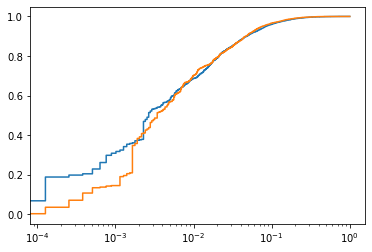

In [165]:

t1,t2,_=roc_curve(y_test,best_nn_clf.predict_proba(X_test_scaled)[:,1])
plt.semilogx(t1,t2)

t3,t4,_=roc_curve(y_test,nn_clf.predict_proba(X_test_scaled)[:,1])
plt.semilogx(t3,t4)



In [160]:
best_nn_clf.predict_proba(X_test_scaled)[:,0]

array([6.76972542e-04, 6.15238390e-02, 9.99540932e-01, ...,
       9.99950386e-01, 9.99956631e-01, 1.47209255e-02])

#### Final Comparision for Default and Optimized Parameters

[2.00000000e+00 9.99999999e-01 9.99868706e-01 ... 1.30228612e-04
 1.30180420e-04 3.46846601e-45]


0.9818106042173192

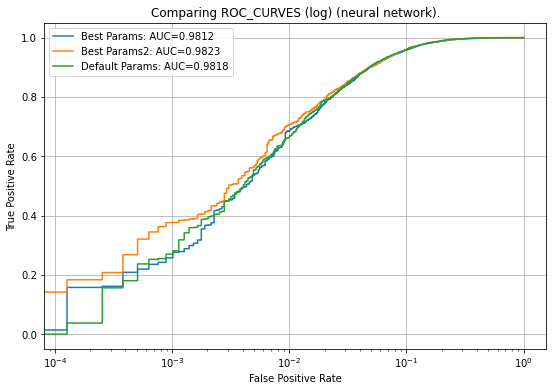

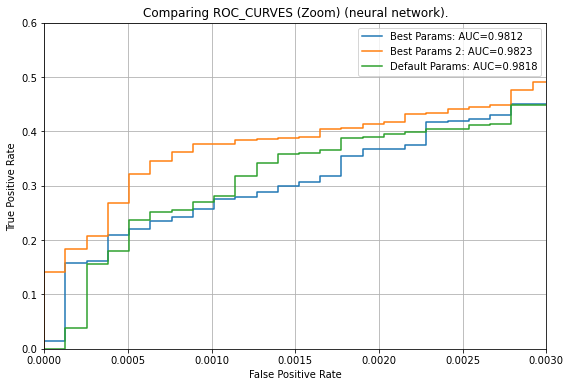

In [158]:
best_nn_score = best_nn_clf.predict_proba(X_test_scaled)[:,1]
best2_nn_score = best2_nn_clf.predict_proba(X_test_scaled)[:,1]
nn_score = nn_clf.predict_proba(X_test_scaled)[:,1]

best_nn_fpr,best_nn_tpr,best_nn_thresholds=roc_curve(y_test,best_nn_score)
best2_nn_fpr,best2_nn_tpr,best2_nn_thresholds=roc_curve(y_test,best2_nn_score)
nn_fpr,nn_tpr,nn_thresholds=roc_curve(y_test,nn_score)


plt.figure(figsize=(9,6))
plt.semilogx(best_nn_fpr,best_nn_tpr,label=f'Best Params: AUC={auc(best_nn_fpr,best_nn_tpr):0.4}')
plt.semilogx(best2_nn_fpr,best2_nn_tpr,label=f'Best Params2: AUC={auc(best2_nn_fpr,best2_nn_tpr):0.4}')
plt.semilogx(nn_fpr,nn_tpr,label=f'Default Params: AUC={auc(nn_fpr,nn_tpr):0.4}')
plt.legend()

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title(f'Comparing ROC_CURVES (log) (neural network).')
plt.grid()

plt.figure(figsize=(9,6))
plt.plot(best_nn_fpr,best_nn_tpr,label=f'Best Params: AUC={auc(best_nn_fpr,best_nn_tpr):0.4}')
plt.plot(best2_nn_fpr,best2_nn_tpr,label=f'Best Params 2: AUC={auc(best2_nn_fpr,best2_nn_tpr):0.4}')
plt.plot(nn_fpr,nn_tpr,label=f'Default Params: AUC={auc(nn_fpr,nn_tpr):0.4}')

plt.xlim(0,0.003)
plt.ylim(0,0.6)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()
plt.title(f'Comparing ROC_CURVES (Zoom) (neural network).')
plt.grid()
print(nn_thresholds)
auc(nn_fpr,nn_tpr)

In [ ]:
best_nn_clf.

#### Creating average ROC curve

In [ ]:
%%time

#Choose The CLassifier with best Parameters
#I Choose The Parameters Found with Bayesian Optimization, Opimizing for Average-Precision. Second run
best_parameters=OrderedDict([('activation', 'tanh'),
  ('alpha', 1e-07),
  ('beta_1', 0.5545561677659581),
  ('beta_2', 0.5713485660228933),
  ('epsilon', 0.000492036188902597),
  ('hidden_layer_sizes', 200),
  ('learning_rate_init', 0.02199012604107307),
  ('max_iter', 537),
  ('solver', 'adam'),
  ('tol', 0.049795769219370685)])

nn_clf=neural_network.MLPClassifier(**best_parameters)

nn_best1_average_fpr, nn_best1_average_tpr, nn_best1_average_thresholds=average_roc_curve(nn_clf,X,y,n_splits=10,n_repeats=100)

In [121]:
### HERE I WILL SAVE THE DATA FOR FUTURE USE!
import joblib 

for i ,j in zip(['nn_best1_full_average_fpr', 'nn_best1_full_average_tpr', 'nn_best1_full_average_thresholds'],[nn_best1_full_average_fpr, nn_best1_full_average_tpr, nn_best1_full_average_thresholds]):
    joblib.dump(j,i)


### Evaluating average_roc_curve Neural Network with for nn with hyperparameters!

In [114]:
nn_best1_average_fpr =joblib.load('nn_best1_average_fpr')
nn_best1_average_tpr =joblib.load('nn_best1_average_tpr')
nn_best1_average_thresholds=joblib.load('nn_best1_average_thresholds')

Wall time: 6.02 s


(0.0, 0.006)

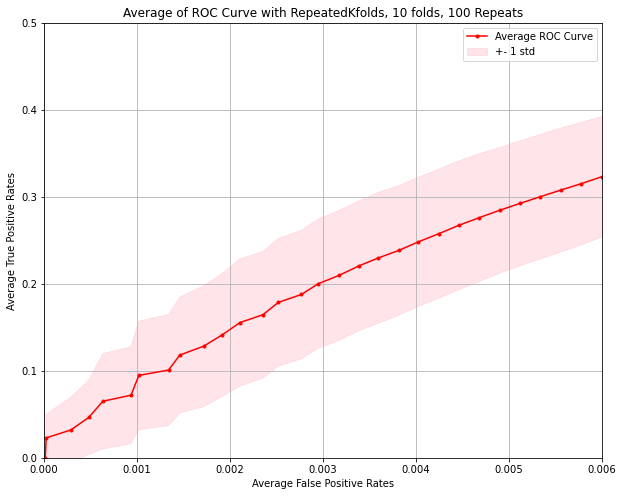

In [255]:
%%time
plt.figure(figsize=([10,8]))
plt.plot(*mean_std_roc(nn_best1_average_fpr, nn_best1_average_tpr, nn_best1_average_thresholds)[0],marker='.',color='r',label='Average ROC Curve')
plt.fill_between(mean_std_roc(nn_best1_average_fpr, nn_best1_average_tpr, nn_best1_average_thresholds)[0][0],mean_std_roc(nn_best1_average_fpr, nn_best1_average_tpr, nn_best1_average_thresholds)[0][1]-mean_std_roc(nn_best1_average_fpr, nn_best1_average_tpr, nn_best1_average_thresholds)[1][1],mean_std_roc(nn_best1_average_fpr, nn_best1_average_tpr, nn_best1_average_thresholds)[0][1]+mean_std_roc(nn_best1_average_fpr, nn_best1_average_tpr, nn_best1_average_thresholds)[1][1],alpha=0.4,color="pink",label='+- 1 std')

plt.xlabel('Average False Positive Rates')
plt.ylabel('Average True Positive Rates')
plt.title('Average of ROC Curve with RepeatedKfolds, 10 folds, 100 Repeats')
plt.legend()
plt.grid(True)

plt.ylim(0,0.5)
plt.xlim(0,0.006)
#plt.xlim(0.00001,0.1)

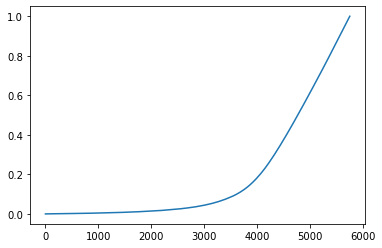

In [202]:
(mf,mt),(sf,st)=mean_std_roc(nn_best1_full_average_fpr, nn_best1_full_average_tpr, nn_best1_full_average_thresholds)

Text(0.5, 1.0, 'FPR and TPR for many different Resamplings and KFolds of MLPClassifier')

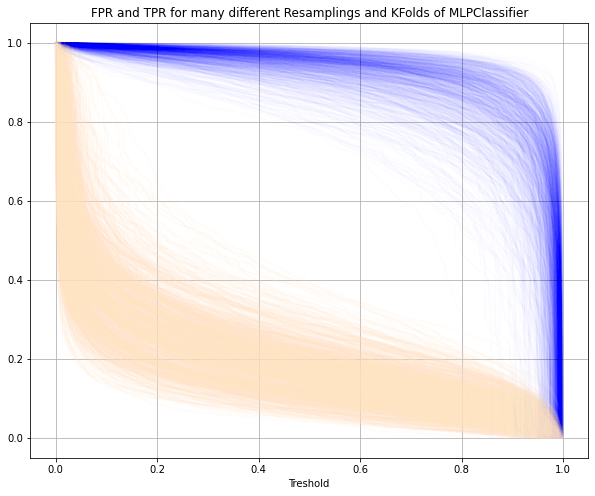

In [226]:
plt.figure(figsize=(10,8))
for n in range(1000):
    plt.plot(nn_best1_full_average_thresholds[n][1:],nn_best1_full_average_fpr[n][1:],'bisque',alpha=0.1)
    plt.plot(nn_best1_full_average_thresholds[n][1:],nn_best1_full_average_tpr[n][1:],'b',alpha=0.01)
    
plt.grid()
plt.xlabel('Treshold')
plt.ylabel()
plt.title('FPR and TPR for many different Resamplings and KFolds of MLPClassifier')

(0.0111, 0.0112)

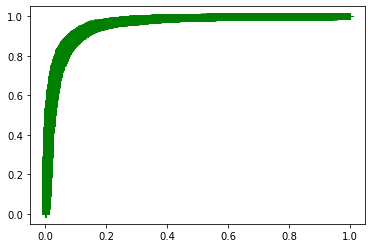

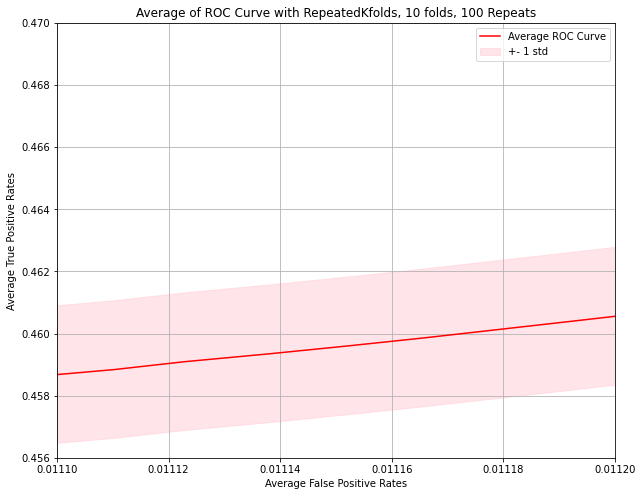

In [219]:

n=0
for n in range(1000):
    plt.plot(nn_best1_full_average_fpr[n],nn_best1_full_average_tpr[n],'g',alpha=0.3,marker='+')

plt.figure(figsize=([10,8]))
#plt.plot(*mean_std_roc(nn_best1_average_fpr, nn_best1_average_tpr, nn_best1_average_thresholds)[0],marker='.',label='Average ROC Curve')
plt.plot(mf,mt,color='r',label='Average ROC Curve')
plt.fill_between(mf,mt-st,mt+st,alpha=0.4,color="pink",label='+- 1 std')

plt.xlabel('Average False Positive Rates')
plt.ylabel('Average True Positive Rates')
plt.title('Average of ROC Curve with RepeatedKfolds, 10 folds, 100 Repeats')
plt.legend()
plt.grid(True)

plt.ylim(0.456,0.47)
plt.xlim(0.0111,0.0112)
#plt.xlim(0.00001,0.1)

# Final scoring and evaluation of our Models 

Prelude: 

In [254]:

X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.4,stratify=y)

Wall time: 37.8 s


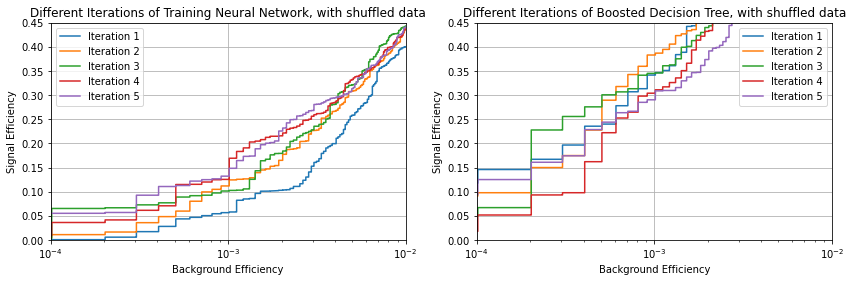

In [269]:
%%time

scalar=RobustScaler()
nn_best_parameters=OrderedDict([('activation', 'tanh'),('alpha', 1e-07),('beta_1', 0.5545561677659581),('beta_2', 0.5713485660228933),('epsilon', 0.000492036188902597),('hidden_layer_sizes', 200), ('learning_rate_init', 0.02199012604107307), ('max_iter', 537), ('solver', 'adam'), ('tol', 0.049795769219370685)])
lgbm_best_parameters=OrderedDict([('boosting_type', 'dart'),('learning_rate', 0.5),  ('max_depth', 6),('min_child_samples', 585), ('min_child_weight', 17), ('n_estimators', 550), ('num_leaves', 58), ('reg_alpha', 5), ('reg_lambda', 4)])

fix, (ax1,ax2) =plt.subplots(1,2,figsize=(14,4))
iteration=1
while iteration <=5:
    
    #Create new training and test sets
    X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.5,stratify=y)
    
    ############## NN #####################
    #Scaling Data
    scalar=RobustScaler()
    scalar.fit(X_train,y_train)
    X_train_scaled=scalar.transform(X_train)
    X_test_scaled=scalar.transform(X_test)
    
    best_nn_clf=neural_network.MLPClassifier(**nn_best_parameters)
    best_nn_clf.fit(X_train,y_train)

    fpr,tpr,t=my_roc_curve_v2(y_test,best_nn_clf.predict_proba(X_test)[:,1])

    ax1.plot(fpr,tpr,label=f'Iteration {iteration}')
    
    #################now for LGBM ###################
    
    #Create new training and test sets

    best_lgbm_clf=lgb.LGBMClassifier(**lgbm_best_parameters)
    best_lgbm_clf.fit(X_train,y_train)

    fpr,tpr,t=my_roc_curve_v2(y_test,best_lgbm_clf.predict_proba(X_test)[:,1])

    ax2.plot(fpr,tpr,label=f'Iteration {iteration}')
    iteration+=1

ax1.set_title('Different Iterations of Training Neural Network, with shuffled data')
ax2.set_title('Different Iterations of Boosted Decision Tree, with shuffled data')
        
for x in (ax1,ax2): 
    x.set_ylim(0,0.45)
    x.set_xlim(0.0001,0.01)

    x.grid()

    x.set_xlabel('Background Efficiency')
    x.set_ylabel('Signal Efficiency')
    x.set_xscale('log')
    x.legend()
    

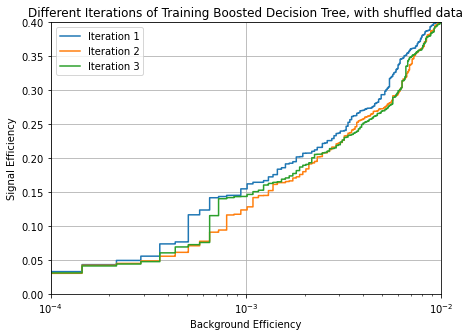

In [262]:

lgbm_best_parameters=OrderedDict([('boosting_type', 'dart'),('learning_rate', 0.5),  ('max_depth', 6),('min_child_samples', 585), ('min_child_weight', 17), ('n_estimators', 550), ('num_leaves', 58), ('reg_alpha', 5), ('reg_lambda', 4)])
plt.figure(figsize=(7,5))
iteration=1

while iteration <=3:
    
    #Create new training and test sets
    X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.7,stratify=y)
    
    best_lgbm_clf=lgb.LGBMClassifier(**lgbm_best_parameters)
    best_lgbm_clf.fit(X_train,y_train)

    fpr,tpr,t=my_roc_curve_v2(y_test,best_nn_clf.predict_proba(X_test)[:,1])

    plt.plot(fpr,tpr,label=f'Iteration {iteration}')
    iteration+=1
    
plt.ylim(0,0.4)
plt.xlim(0.0001,0.01)
plt.title('Different Iterations of Training Boosted Decision Tree, with shuffled data')
plt.grid()

plt.xlabel('Background Efficiency')
plt.ylabel('Signal Efficiency')
plt.xscale('log')
plt.legend()

## Comparing TPR and FPR of the LGBM and NN

First we Load all of our data we worked so hard to make

In [75]:
lgbm_best2_average_fpr=joblib.load('lgbm_best2_average_fpr') #The BDT that trained on 90% of data, tested on 10%
lgbm_best2_average_tpr=joblib.load('lgbm_best2_average_tpr')
lgbm_best2_average_thresholds=joblib.load('lgbm_best2_average_thresholds')

In [76]:
lgbm_best3_average_fpr=joblib.load('lgbm_best3_average_fpr') #The BDT that trained on 10% of data, tested on 90%
lgbm_best3_average_tpr=joblib.load('lgbm_best3_average_tpr')
lgbm_best3_average_thresholds=joblib.load('lgbm_best3_average_thresholds')

In [77]:
# Data of the Average ROC_Curve for BDT
lgbm_thresholds1=joblib.load('lgbm_thresholds1')
lgbm_fpr1=joblib.load('lgbm_fpr1')
lgbm_std_fpr1=joblib.load('lgbm_std_fpr1')
lgbm_tpr1=joblib.load('lgbm_tpr1')
lgbm_std_tpr1=joblib.load('lgbm_std_tpr1')

In [78]:
nn_best1_scaled_average_fpr =joblib.load('nn_best1_scaled_average_fpr') #The network that trained on 90% of data, tested on 10%
nn_best1_scaled_average_tpr =joblib.load('nn_best1_scaled_average_tpr')
nn_best1_scaled_average_thresholds=joblib.load('nn_best1_scaled_average_thresholds')

In [79]:
nn_best4_scaled_average_fpr =joblib.load('nn_best4_scaled_average_fpr')  #The network that trained on 10% of data, tested on 90%
nn_best4_scaled_average_tpr =joblib.load('nn_best4_scaled_average_tpr')
nn_best4_scaled_average_thresholds=joblib.load('nn_best4_scaled_average_thresholds')

In [80]:
# Data of the Average ROC_Curve for NN
nn_thresholds1=joblib.load('nn_thresholds1')
nn_fpr1=joblib.load('nn_fpr1')
nn_std_fpr1=joblib.load('nn_std_fpr1')
nn_tpr1=joblib.load('nn_tpr1')
nn_std_tpr1=joblib.load('nn_std_tpr1')

In [81]:
def points(fpr_or_tpr,thresholds,interval):
    """Interval must be a tuple (lower, upper) of bound between 0 and 1."""
    
    dist=[] #Prepare a container for all datapoints
    
    #start looping over the different arrays in the list.
    for array, t in zip(fpr_or_tpr,thresholds):
        
        #Makes a bin of threshold values, chooses index where the thresholds is between 2 different values in ascending order.
        index=np.argwhere((t[:]>=interval[0]) & (t[:]<=interval[1]))
        
        #takes all of the false positive rates within that bin, and adds them to the distribution.
        dist.append(array[index])
    
    return np.concatenate(dist).ravel()

In [82]:
def intervalation(array):
    """
    Assumes array is has values between 0 and 1
    Returns sorted array, and the differences between values
    """
    #Get intervals between each array value
    array=np.sort(array) #sort ascending
    array=np.insert(array, 0, 0, axis=None)[:-1] #add a 0 at the beginning, and remove last element
    
    array_difference=np.diff(array) #difference in thershold values, size is ofc 1 less.
    array_difference=np.append(array_difference,1) #add 1 at the end, now same size as array.
    return array, array_difference

In [83]:
def means_for_variable(independent_list,dependent_list):
    """
    Parameters(many_x,many_y)
    Calculates average and std of y for each value of x
    """
    
    #choose array on which to evaluate the intervals
    intervals,difference=intervalation(independent_list[42]) #for simplicity i choose 42, otherwise i would have to take the means.
    
    
    means=[]  
    stds=[]    
    n=1
    
    #Get all FPR and TPR values between thresholds, calculate mean and std
    for value , diff in zip(intervals,difference):
        
        #Get distribution of tpr_points in all arrays within fpr interval      
        dependent_distribution=points(dependent_list,independent_list,(value,value+diff))
        
        #Calculate mean and standard deviation of distribution       
        dependent_mean = np.mean(dependent_distribution)      
        dependent_std= np.std(dependent_distribution)      
        
        #Append Results
       
        means.append(dependent_mean)
        stds.append(dependent_std)
        
        #Help me know how far the function has come        
        if n%10==0:
            print(n)
        n+=1
              
    return np.array(intervals) , np.array(means) , np.array(stds)

In [84]:
def fpr_and_tpr_for_threshold(fpr_list,tpr_list,threshold_list):
    
    #choose array on which to evaluate the intervals
    intervals,difference=intervalation(threshold_list[42]) #for simplicity i choose 42, otherwise i would have to take the means.

    means_fpr=[]  
    means_tpr=[]
    
    stds_fpr=[]    
    stds_tpr=[]

    n=1
    
    for value , diff in zip(intervals,difference):
        
        #Get distribution of fpr and tpr points in all arrays within threshold interval      
        fpr_distribution=points(fpr_list,threshold_list,(value,value+diff))
        tpr_distribution=points(tpr_list,threshold_list,(value,value+diff))        
             
        #Calculate mean of distributions       
        fpr_mean = np.mean(fpr_distribution)  
        tpr_mean = np.mean(tpr_distribution) 
        
        #Calculate standard deviations of distributions                  
        fpr_std= np.std(fpr_distribution)      
        tpr_std= np.std(tpr_distribution) 
        
        #Append Results       
        means_fpr.append(fpr_mean)
        means_tpr.append(tpr_mean)
        stds_fpr.append(fpr_std)
        stds_tpr.append(tpr_std)
        
        #Help me know how far the function has come        
        if n%10==0:
            print(n)
        n+=1
              
    return np.array(intervals) , np.array(means_fpr) , np.array(stds_fpr), np.array(means_tpr), np.array(stds_tpr)

### Analysis on LGBM

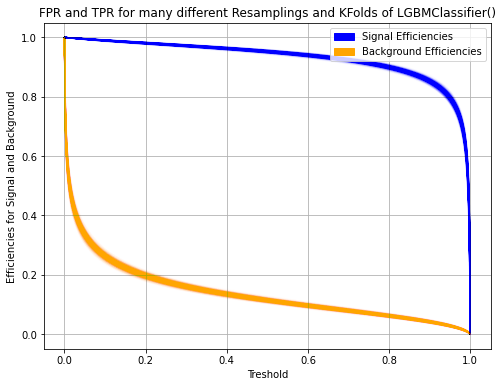

In [87]:
#Small Training Set, Large Testing Set
fig , ax=plt.subplots(figsize=(8,6))

for n in range(1000):
    ax.plot(lgbm_best3_average_thresholds[n][1:],lgbm_best3_average_fpr[n][1:],'orange',alpha=0.01)
    ax.plot(lgbm_best3_average_thresholds[n][1:],lgbm_best3_average_tpr[n][1:],'blue',alpha=0.01)
    
ax.grid()
ax.set_xlabel('Treshold')
ax.set_ylabel('Efficiencies for Signal and Background')
ax.set_title('FPR and TPR for many different Resamplings and KFolds of LGBMClassifier()')

blue_patch = mpl.patches.Patch(color='blue', label='Signal Efficiencies')
orange_patch = mpl.patches.Patch(color='orange', label='Background Efficiencies')

ax.legend(handles=[blue_patch,orange_patch],loc='upper right')

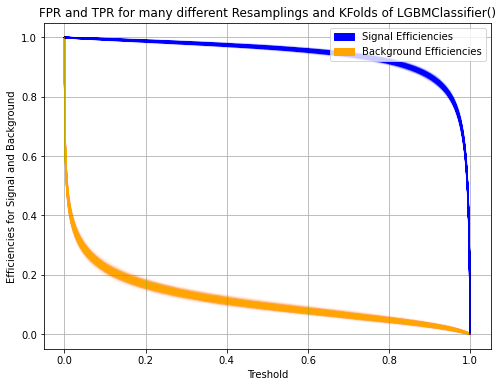

In [88]:
#Large Training Set, Small Testing Set
fig , ax=plt.subplots(figsize=(8,6))

for n in range(1000):
    ax.plot(lgbm_best2_average_thresholds[n][1:],lgbm_best2_average_fpr[n][1:],'orange',alpha=0.01)
    ax.plot(lgbm_best2_average_thresholds[n][1:],lgbm_best2_average_tpr[n][1:],'blue',alpha=0.01)
    
ax.grid()
ax.set_xlabel('Treshold')
ax.set_ylabel('Efficiencies for Signal and Background')
ax.set_title('FPR and TPR for many different Resamplings and KFolds of LGBMClassifier()')

blue_patch = mpl.patches.Patch(color='blue', label='Signal Efficiencies')
orange_patch = mpl.patches.Patch(color='orange', label='Background Efficiencies')

ax.legend(handles=[blue_patch,orange_patch],loc='upper right')

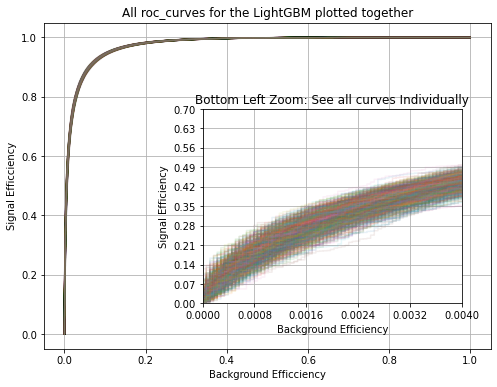

In [49]:
n=0
plt.figure(figsize=(8,6))
for n in range(1000):
    plt.plot(lgbm_best3_average_fpr[n],lgbm_best3_average_tpr[n],alpha=0.03)

plt.grid()
plt.title('All roc_curves for the LightGBM plotted together')
plt.xlabel('Background Efficciency')
plt.ylabel('Signal Efficciency')



# this is an inset axes over the main axes
a=plt.axes([0.4, 0.23, .45, .45], facecolor='w')
for n in range(1000):
    plt.plot(lgbm_best3_average_fpr[n],lgbm_best3_average_tpr[n],alpha=0.1)
    
plt.title('Bottom Left Zoom: See all curves Individually')

xlim=0.004

a.set_xlabel('Background Efficiency')
a.set_xlim(0,xlim)
a.set_xticks(np.linspace(0,xlim,6))

ylim=0.7
a.set_ylabel('Signal Efficiency')
a.set_ylim(0,ylim)
a.set_yticks(np.linspace(0,ylim,11))
a.grid()


**Now i make an average roc curve out of all the roc-curves shown above** <br>
**Then I take a bin on the TPR and calculate avarages on the FPR, and plot those** <br>
**I also take a bin on the FPR and calculate avarages on the TPR, and plot those**


In [74]:
%%time

lgbm_point_mean_tpr , lgbm_distribution_mean_fpr , lgbm_distribution_std_fpr=means_for_variable(lgbm_best2_average_tpr,lgbm_best2_average_fpr)
lgbm_point_mean_fpr , lgbm_distribution_mean_tpr , lgbm_distribution_std_tpr=means_for_variable(lgbm_best2_average_fpr,lgbm_best2_average_tpr)


10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930


KeyboardInterrupt: 

In [94]:
#Bit confusing so follow carefully
plt.figure(figsize=(8,6))

#Plot the roc-curve for which i choose a point on FPR and make distribution of TPR
plt.plot(lgbm_point_mean_fpr,lgbm_distribution_mean_tpr,label='Mean of Signal Efficiency Distribution')

#Plot the roc-curve for which i choose a point on tpr and make distribution of fpr
plt.plot(lgbm_distribution_mean_fpr , lgbm_point_mean_tpr,label='Mean of Background Efficiency Distribution')



#plt.fill_between(lgbm_point_mean_fpr,lgbm_distribution_mean_tpr-lgbm_distribution_std_tpr,lgbm_distribution_mean_tpr+lgbm_distribution_std_tpr,alpha=0.3,edgecolor='blue',label='Standard Deviation of Signal Efficiency Distribution')
plt.fill_betweenx(lgbm_point_mean_tpr,lgbm_distribution_mean_fpr-lgbm_distribution_std_fpr,lgbm_distribution_mean_fpr+lgbm_distribution_std_fpr,alpha=0.3,edgecolor='peru',label='Standard Deviation of Background Efficiency Distribution')


#Axes.fill_betweenx(y, x1, x2=0, where=None, step=None, interpolate=False, *, data=None, **kwargs)

plt.xlabel('Average Background Efficiency')
plt.ylabel('Average Signal Efficiency')
plt.title('LGBM: Average ROC-Curve')
plt.legend()
plt.grid(True)

plt.ylim(0,0.7)
plt.xlim(0,0.004)

NameError: name 'lgbm_point_mean_fpr' is not defined

<Figure size 576x432 with 0 Axes>

In [92]:
lgbm_thresholds,lgbm_fpr,lgbm_std_fpr,lgbm_tpr,lgbm_std_tpr=fpr_and_tpr_for_threshold(lgbm_best2_average_fpr,lgbm_best2_average_tpr,lgbm_best2_average_thresholds)

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
222

(0.0, 0.007)

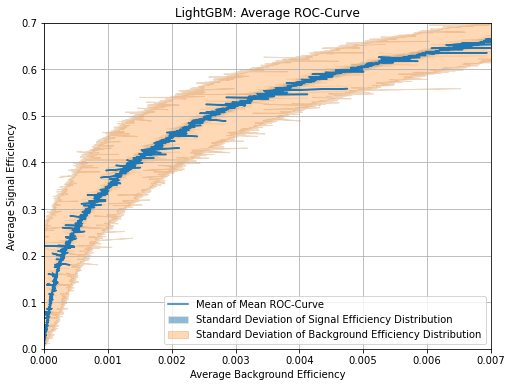

In [95]:
#Bit confusing so follow carefully
plt.figure(figsize=(8,6))

#Plot the roc-curve for which i choose a point on FPR and make distribution of TPR
plt.plot(lgbm_fpr,lgbm_tpr,label='Mean of Mean ROC-Curve')


plt.fill_between(lgbm_fpr,lgbm_tpr-lgbm_std_tpr,lgbm_tpr+lgbm_std_tpr,alpha=0.5,edgecolor='bisque',label='Standard Deviation of Signal Efficiency Distribution')
plt.fill_betweenx(lgbm_tpr,lgbm_fpr-lgbm_std_fpr,lgbm_fpr+lgbm_std_fpr,alpha=0.3,edgecolor='peru',label='Standard Deviation of Background Efficiency Distribution')



plt.xlabel('Average Background Efficiency')
plt.ylabel('Average Signal Efficiency')
plt.title('LightGBM: Average ROC-Curve')
plt.legend()
plt.grid(True)

plt.ylim(0,0.7)
plt.xlim(0,0.007)

(0.0, 0.007)

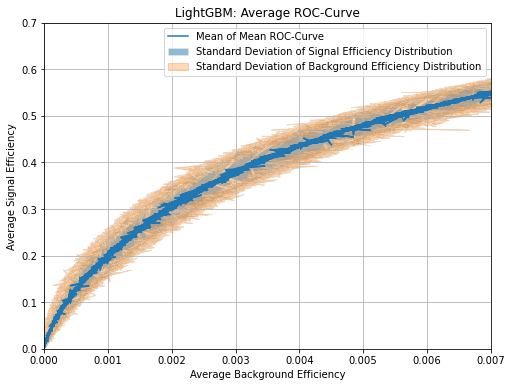

In [91]:
#Small Training Set, Large Testing Set
plt.figure(figsize=(8,6))

#Plot the roc-curve for which i choose a point on FPR and make distribution of TPR
plt.plot(lgbm_fpr1,lgbm_tpr1,label='Mean of Mean ROC-Curve')


plt.fill_between(lgbm_fpr1,lgbm_tpr1-lgbm_std_tpr1,lgbm_tpr1+lgbm_std_tpr1,alpha=0.5,edgecolor='bisque',label='Standard Deviation of Signal Efficiency Distribution')
plt.fill_betweenx(lgbm_tpr1,lgbm_fpr1-lgbm_std_fpr1,lgbm_fpr1+lgbm_std_fpr1,alpha=0.3,edgecolor='peru',label='Standard Deviation of Background Efficiency Distribution')



plt.xlabel('Average Background Efficiency')
plt.ylabel('Average Signal Efficiency')
plt.title('LightGBM: Average ROC-Curve')
plt.legend()
plt.grid(True)

plt.ylim(0,0.7)
plt.xlim(0,0.007)

#### Fitting FPR and TPR for given Threshold

In [100]:
def centerbins(bin_edges):
    return (bin_edges[:-1]+bin_edges[1:])/2

def chi_squared(obs,exp,sigma):
    return np.sum((obs-exp)**2/sigma**2)

In [101]:
from scipy.stats import norm, expon, poisson, beta, gamma, truncnorm, betaprime, erlang, genpareto

First Define our Fitting Functions

0.002284172295705532 0.0007517456942712227
0.32497718010771154 0.05048459817056227
Wall time: 548 ms


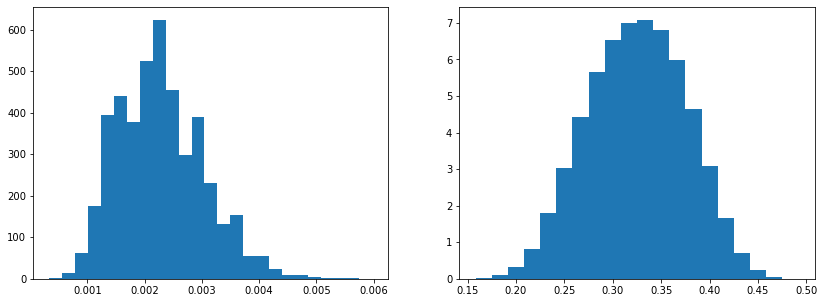

In [464]:
%%time
n, dn = 0.998, 0.0007
fig, ax = plt.subplots(1,2,figsize=(14,5))

lgbm_fpr_dist=points(lgbm_best3_average_fpr,lgbm_best3_average_thresholds,[n-dn,n+dn])
hist_fpr=ax[0].hist(lgbm_fpr_dist,bins=25,density=True);
print(np.mean(lgbm_fpr_dist),np.std(lgbm_fpr_dist))

lgbm_tpr_dist=points(lgbm_best3_average_tpr,lgbm_best3_average_thresholds,[n-dn,n+dn])
hist_tpr=ax[1].hist(lgbm_tpr_dist,bins=20,density=True);
print(np.mean(lgbm_tpr_dist),np.std(lgbm_tpr_dist))
#np.std(duh)

15.74617885002333 0.3991184353577491
(13.255683025095268, -0.000133696172986106, 0.00018655616323281162)
1.323904900076197 1.0
Wall time: 13.8 s


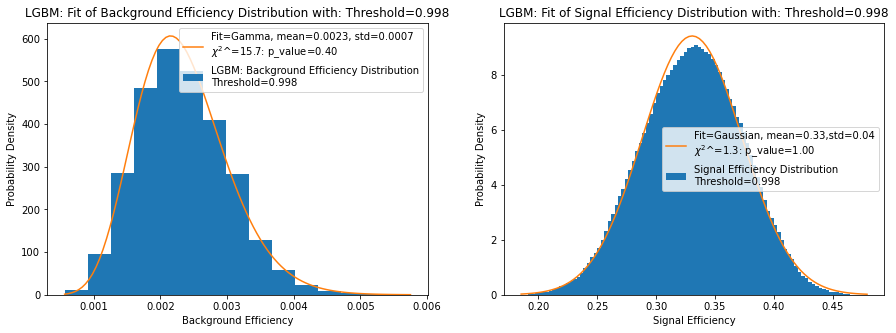

<Figure size 576x432 with 0 Axes>

In [253]:
%%time
#Choose Threshold
n, dn = 0.998, 0.0005

#Create figure with axes
fig, (ax1,ax2)=plt.subplots(1,2,figsize=(15,5))

################################## MAKE SUBPLOT for FPR ###############################
#Calculate Distribution
#plt.figure(figsize=(8,6))
lgbm_fpr_dist=points(lgbm_best3_average_fpr,lgbm_best3_average_thresholds,[n-dn,n+dn])
count,bin_edges,_=ax1.hist(lgbm_fpr_dist,bins=15,density=True,label=f'LGBM: Background Efficiency Distribution\nThreshold={n}'); #

#Get Window For our Plot
xmin,xmax=np.min(lgbm_fpr_dist),np.max(lgbm_fpr_dist)
x=np.linspace(xmin,xmax,100)

#Fit Our Distribution and Plot!
fit_func=gamma
fit_params=fit_func.fit(lgbm_fpr_dist)
fit=fit_func.pdf(x,*fit_params)


#Now we do Chi Squared Test
bin_centers=centerbins(bin_edges)
fit_at_hist=fit_func.pdf(bin_centers,*fit_params)

chi2_value=chi_squared(count,fit_at_hist,np.sqrt((fit_at_hist)))
chi2_prob = chi2.sf(chi2_value, len(bin_centers))
print(chi2_value,chi2_prob)

print(fit_params)
ax1.plot(x,fit,label=f'Fit=Gamma, mean={np.mean(lgbm_fpr_dist):0.4f}, std={np.std(lgbm_fpr_dist):0.4f}\n'+ r'$\chi^2$^'+f'={chi2_value:0.1f}: p_value={chi2_prob:0.2f}')
ax1.set_title(f'LGBM: Fit of Background Efficiency Distribution with: Threshold={n:0.3f}')
ax1.set_xlabel('Background Efficiency')
ax1.set_ylabel('Probability Density')
ax1.legend(loc='upper right')
################################## MAKE SUBPLOT for TPR ###############################

#Calculate Distribution
plt.figure(figsize=(8,6))
lgbm_tpr_dist=points(lgbm_best3_average_tpr,lgbm_best3_average_thresholds,[n-dn,n+dn])
count,bin_edges,_=ax2.hist(lgbm_tpr_dist,bins=100,density=True,label=f'Signal Efficiency Distribution\nThreshold={n}');

#Get Window For our Plot
xmin,xmax=np.min(lgbm_tpr_dist),np.max(lgbm_tpr_dist)
x=np.linspace(xmin,xmax,100)

#Fit Our Distribution and Plot!
fit_func=norm
fit_params=fit_func.fit(lgbm_tpr_dist)
fit=fit_func.pdf(x,*fit_params)


#Now we do Chi Squared Test
bin_centers=centerbins(bin_edges)
fit_at_hist=fit_func.pdf(bin_centers,*fit_params)


chi2_value=chi_squared(count,fit_at_hist,np.sqrt((fit_at_hist)))
chi2_prob = chi2.sf(chi2_value, len(bin_centers))
print(chi2_value,chi2_prob)

ax2.plot(x,fit,label=f'Fit=Gaussian, mean={np.mean(lgbm_tpr_dist):0.2f},std={np.std(lgbm_tpr_dist):0.2f}\n'+ r'$\chi^2$^'+f'={chi2_value:0.1f}: p_value={chi2_prob:0.2f}')
ax2.set_title(f'LGBM: Fit of Signal Efficiency Distribution with: Threshold={n:0.3f}')
ax2.set_xlabel('Signal Efficiency')
ax2.set_ylabel('Probability Density')
ax2.legend()

#### Find FPR dist for different TPR

15.527777136732201 0.4141100422493554


C:\Users\Bruger\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:2804: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 118.65.
  warnings.warn(
C:\Users\Bruger\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:2804: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 107.35.
  warnings.warn(
C:\Users\Bruger\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:2804: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 109.23333333333335.
  warnings.warn(
C:\Users\Bruger\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:2804: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 112.05833333333334.
  warnings.warn(
C:\Users\Bruger\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:2804: RuntimeWarning: The shape parameter of the erlang distribution h

15.532344779719374 0.21360615420787166


C:\Users\Bruger\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:2804: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 44.1.
  warnings.warn(
C:\Users\Bruger\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:2804: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 39.9.
  warnings.warn(
C:\Users\Bruger\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:2804: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 40.60000000000001.
  warnings.warn(
C:\Users\Bruger\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:2804: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 41.650000000000006.
  warnings.warn(
C:\Users\Bruger\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:2804: RuntimeWarning: The shape parameter of the erlang distribution has be

44.01126164790954 3.276369510988532e-06
Wall time: 38.8 s


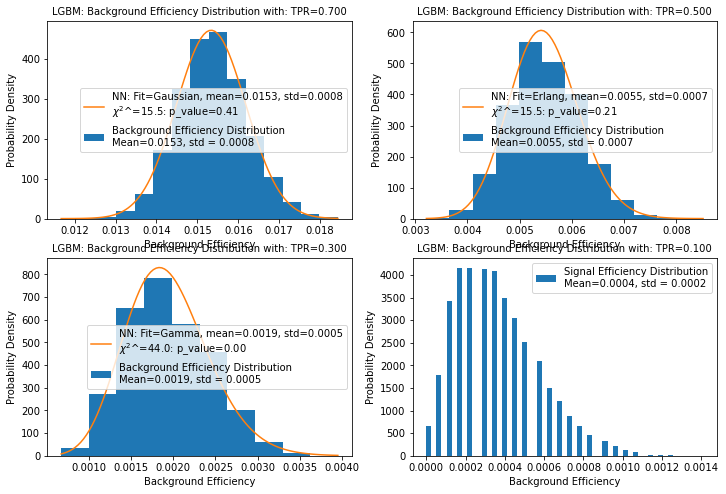

<Figure size 576x432 with 0 Axes>

In [155]:
%%time

#Create figure with axes
fig, ((ax1,ax2),(ax3,ax4))=plt.subplots(2,2,figsize=(12,8))


################################## MAKE SUBPLOT for FPR, TPR=0.7 ###############################

n, dn = 0.7, 0.005

#Calculate Distribution
lgbm_fpr_dist=points(lgbm_best3_average_fpr,lgbm_best3_average_tpr,[n-dn,n+dn])
count,bin_edges,_=ax1.hist(lgbm_fpr_dist,bins=15,density=True,label=f'Background Efficiency Distribution\nMean={np.mean(lgbm_fpr_dist):0.4f}, std = {np.std(lgbm_fpr_dist):0.4f}'); #

#Get Window For our Plot
xmin,xmax=np.min(lgbm_fpr_dist),np.max(lgbm_fpr_dist)
x=np.linspace(xmin,xmax,100)

#Fit Our Distribution and Plot!
fit_func=norm
fit_params=fit_func.fit(lgbm_fpr_dist)
fit=fit_func.pdf(x,*fit_params)


#Now we do Chi Squared Test
bin_centers=centerbins(bin_edges)
fit_at_hist=fit_func.pdf(bin_centers,*fit_params)

chi2_value=chi_squared(count,fit_at_hist,np.sqrt((fit_at_hist)))
chi2_prob = chi2.sf(chi2_value, len(bin_centers))
print(chi2_value,chi2_prob)

#print(fit_params)
ax1.plot(x,fit,label=f'NN: Fit=Gaussian, mean={np.mean(lgbm_fpr_dist):0.4f}, std={np.std(lgbm_fpr_dist):0.4f}\n'+ r'$\chi^2$^'+f'={chi2_value:0.1f}: p_value={chi2_prob:0.2f}')
ax1.set_title(f'LGBM: Background Efficiency Distribution with: TPR={n:0.3f}')

################################## MAKE SUBPLOT for FPR, TPR=0.5 ###############################

n, dn = 0.5, 0.025

#Calculate Distribution
lgbm_fpr_dist=points(lgbm_best3_average_fpr,lgbm_best3_average_tpr,[n-dn,n+dn])
count,bin_edges,_=ax2.hist(lgbm_fpr_dist,bins=12,density=True,label=f'Background Efficiency Distribution\nMean={np.mean(lgbm_fpr_dist):0.4f}, std = {np.std(lgbm_fpr_dist):0.4f}'); #

#Get Window For our Plot
xmin,xmax=np.min(lgbm_fpr_dist),np.max(lgbm_fpr_dist)
x=np.linspace(xmin,xmax,100)

#Fit Our Distribution and Plot!
fit_func=erlang
fit_params=fit_func.fit(lgbm_fpr_dist)
fit=fit_func.pdf(x,*fit_params)


#Now we do Chi Squared Test
bin_centers=centerbins(bin_edges)
fit_at_hist=fit_func.pdf(bin_centers,*fit_params)

chi2_value=chi_squared(count,fit_at_hist,np.sqrt((fit_at_hist)))
chi2_prob = chi2.sf(chi2_value, len(bin_centers))
print(chi2_value,chi2_prob)

#print(fit_params)
ax2.plot(x,fit,label=f'NN: Fit=Erlang, mean={np.mean(lgbm_fpr_dist):0.4f}, std={np.std(lgbm_fpr_dist):0.4f}\n'+ r'$\chi^2$^'+f'={chi2_value:0.1f}: p_value={chi2_prob:0.2f}')
ax2.set_title(f'LGBM: Background Efficiency Distribution with: TPR={n:0.3f}')

################################## MAKE SUBPLOT for FPR, TPR=0.3 ###############################

n, dn = 0.3, 0.05

#Calculate Distribution
lgbm_fpr_dist=points(lgbm_best3_average_fpr,lgbm_best3_average_tpr,[n-dn,n+dn])
count,bin_edges,_=ax3.hist(lgbm_fpr_dist,bins=10,density=True,label=f'Background Efficiency Distribution\nMean={np.mean(lgbm_fpr_dist):0.4f}, std = {np.std(lgbm_fpr_dist):0.4f}'); #

#Get Window For our Plot
xmin,xmax=np.min(lgbm_fpr_dist),np.max(lgbm_fpr_dist)
x=np.linspace(xmin,xmax,100)

#Fit Our Distribution and Plot!
fit_func=erlang
fit_params=fit_func.fit(lgbm_fpr_dist)
fit=fit_func.pdf(x,*fit_params)


#Now we do Chi Squared Test
bin_centers=centerbins(bin_edges)
fit_at_hist=fit_func.pdf(bin_centers,*fit_params)

chi2_value=chi_squared(count,fit_at_hist,np.sqrt((fit_at_hist)))
chi2_prob = chi2.sf(chi2_value, len(bin_centers))
print(chi2_value,chi2_prob)

#print(fit_params)
ax3.plot(x,fit,label=f'NN: Fit=Gamma, mean={np.mean(lgbm_fpr_dist):0.4f}, std={np.std(lgbm_fpr_dist):0.4f}\n'+ r'$\chi^2$^'+f'={chi2_value:0.1f}: p_value={chi2_prob:0.2f}')
ax3.set_title(f'LGBM: Background Efficiency Distribution with: TPR={n:0.3f}')


################################## MAKE SUBPLOT for FPR, TPR=0.1 ###############################

n, dn = 0.1, 0.05

#Calculate Distribution
plt.figure(figsize=(8,6))
lgbm_tpr_dist=points(lgbm_best3_average_fpr,lgbm_best3_average_tpr,[n-dn,n+dn])
count,bin_edges,_=ax4.hist(lgbm_tpr_dist,bins=55,density=True,label=f'Signal Efficiency Distribution\nMean={np.mean(lgbm_tpr_dist):0.4f}, std = {np.std(lgbm_tpr_dist):0.4f}');

#Get Window For our Plot
xmin,xmax=np.min(lgbm_tpr_dist),np.max(lgbm_tpr_dist)
x=np.linspace(xmin,xmax,100)

#Fit Our Distribution and Plot!
#fit_func=gamma
#fit_params=fit_func.fit(lgbm_tpr_dist)
#fit=fit_func.pdf(x,*fit_params)


#Now we do Chi Squared Test
#bin_centers=centerbins(bin_edges)
#fit_at_hist=fit_func.pdf(bin_centers,*fit_params)


#chi2_value=chi_squared(count,fit_at_hist,np.sqrt((fit_at_hist)))
#chi2_prob = chi2.sf(chi2_value, len(bin_centers))
#print(chi2_value,chi2_prob)

#ax4.plot(x,fit,label=f'NN: Fit=Gaussian, mean={np.mean(lgbm_tpr_dist):0.2f},std={np.std(lgbm_tpr_dist):0.2f}\n'+ r'$\chi^2$^'+f'={chi2_value:0.1f}: p_value={chi2_prob:0.2f}')
ax4.set_title(f'LGBM: Background Efficiency Distribution with: TPR={n:0.3f}')


for x in [ax1,ax2,ax3,ax4]:
    x.title.set_size('medium')
    x.set_xlabel('Background Efficiency')
    x.set_ylabel('Probability Density')
    x.legend()

85.09648782152229 8.074006600625265e-12


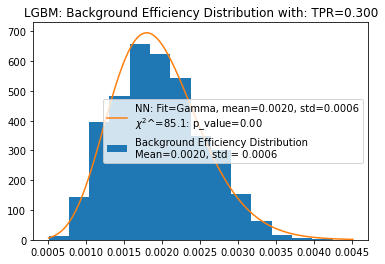

In [152]:
ax3=plt.subplot()
n, dn = 0.3, 0.07

#Calculate Distribution
lgbm_fpr_dist=points(lgbm_best3_average_fpr,lgbm_best3_average_tpr,[n-dn,n+dn])
count,bin_edges,_=ax3.hist(lgbm_fpr_dist,bins=15,density=True,label=f'Background Efficiency Distribution\nMean={np.mean(lgbm_fpr_dist):0.4f}, std = {np.std(lgbm_fpr_dist):0.4f}'); #

#Get Window For our Plot
xmin,xmax=np.min(lgbm_fpr_dist),np.max(lgbm_fpr_dist)
x=np.linspace(xmin,xmax,100)

#Fit Our Distribution and Plot!
fit_func=gamma
fit_params=fit_func.fit(lgbm_fpr_dist)
fit=fit_func.pdf(x,*fit_params)


#Now we do Chi Squared Test
bin_centers=centerbins(bin_edges)
fit_at_hist=fit_func.pdf(bin_centers,*fit_params)

chi2_value=chi_squared(count,fit_at_hist,np.sqrt((fit_at_hist)))
chi2_prob = chi2.sf(chi2_value, len(bin_centers))
print(chi2_value,chi2_prob)

#print(fit_params)
ax3.plot(x,fit,label=f'NN: Fit=Gamma, mean={np.mean(lgbm_fpr_dist):0.4f}, std={np.std(lgbm_fpr_dist):0.4f}\n'+ r'$\chi^2$^'+f'={chi2_value:0.1f}: p_value={chi2_prob:0.2f}')
ax3.set_title(f'LGBM: Background Efficiency Distribution with: TPR={n:0.3f}')

ax3.legend()

#### LARGE TRAINING SAMPLE SMALL TEST SAMPLE

2.2592071475511233 1.0
(0.25516028119076334, 0.011181377607704698)
2.2592071475511233 1.0
Wall time: 134 ms


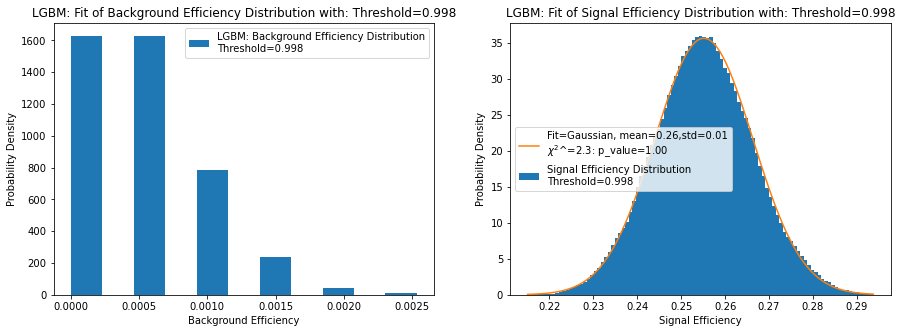

<Figure size 576x432 with 0 Axes>

In [203]:
%%time
#Choose Threshold
n, dn = 0.998, 0.0001

#Create figure with axes
fig, (ax1,ax2)=plt.subplots(1,2,figsize=(15,5))

################################## MAKE SUBPLOT for FPR ###############################
#Calculate Distribution
#plt.figure(figsize=(8,6))
lgbm_fpr_dist=points(lgbm_best2_average_fpr,lgbm_best2_average_thresholds,[n-dn,n+dn])
count,bin_edges,_=ax1.hist(lgbm_fpr_dist,bins=11,density=True,label=f'LGBM: Background Efficiency Distribution\nThreshold={n}'); #

#Get Window For our Plot
xmin,xmax=np.min(lgbm_fpr_dist),np.max(lgbm_fpr_dist)
x=np.linspace(xmin,xmax,100)

#Fit Our Distribution and Plot!
#fit_func=gamma
#fit_params=fit_func.fit(lgbm_fpr_dist)
#fit=fit_func.pdf(x,*fit_params)


#Now we do Chi Squared Test
#bin_centers=centerbins(bin_edges)
#fit_at_hist=fit_func.pdf(bin_centers,*fit_params)

#chi2_value=chi_squared(count,fit_at_hist,np.sqrt((fit_at_hist)))
#chi2_prob = chi2.sf(chi2_value, len(bin_centers))
print(chi2_value,chi2_prob)

print(fit_params)
#ax1.plot(x,fit,label=f'Fit=Gamma, mean={np.mean(lgbm_fpr_dist):0.4f}, std={np.std(lgbm_fpr_dist):0.4f}\n'+ r'$\chi^2$^'+f'={chi2_value:0.1f}: p_value={chi2_prob:0.2f}')
ax1.set_title(f'LGBM: Fit of Background Efficiency Distribution with: Threshold={n:0.3f}')
ax1.set_xlabel('Background Efficiency')
ax1.set_ylabel('Probability Density')
#ax1.set_yscale('log')
ax1.legend(loc='upper right')
################################## MAKE SUBPLOT for TPR ###############################

#Calculate Distribution
plt.figure(figsize=(8,6))
lgbm_tpr_dist=points(lgbm_best2_average_tpr,lgbm_best2_average_thresholds,[n-dn,n+dn])
count,bin_edges,_=ax2.hist(lgbm_tpr_dist,bins=99,density=True,label=f'Signal Efficiency Distribution\nThreshold={n}');

#Get Window For our Plot
xmin,xmax=np.min(lgbm_tpr_dist),np.max(lgbm_tpr_dist)
x=np.linspace(xmin,xmax,100)

#Fit Our Distribution and Plot!
fit_func=norm
fit_params=fit_func.fit(lgbm_tpr_dist)
fit=fit_func.pdf(x,*fit_params)


#Now we do Chi Squared Test
bin_centers=centerbins(bin_edges)
fit_at_hist=fit_func.pdf(bin_centers,*fit_params)


chi2_value=chi_squared(count,fit_at_hist,np.sqrt((fit_at_hist)))
chi2_prob = chi2.sf(chi2_value, len(bin_centers))
print(chi2_value,chi2_prob)

ax2.plot(x,fit,label=f'Fit=Gaussian, mean={np.mean(lgbm_tpr_dist):0.2f},std={np.std(lgbm_tpr_dist):0.2f}\n'+ r'$\chi^2$^'+f'={chi2_value:0.1f}: p_value={chi2_prob:0.2f}')
ax2.set_title(f'LGBM: Fit of Signal Efficiency Distribution with: Threshold={n:0.3f}')
ax2.set_xlabel('Signal Efficiency')
ax2.set_ylabel('Probability Density')
ax2.legend()

In [220]:
lgbm_fpr_dist=points(lgbm_best2_average_fpr,lgbm_best2_average_thresholds,[n-dn,n+dn])
count,bin_edges,_=ax1.hist(lgbm_fpr_dist,bins=11,density=True,label=f'LGBM: Background Efficiency Distribution\nThreshold={n}'); #
u=np.unique(count)[1:]
su=np.sum([42.3872741 ,  238.42085843,  786.85534639, 1628.07040663, 1628.13087349])
print(u,su, u[0]/su)

[  12.33524096   42.3872741   238.42085843  786.85534639 1628.07040663
 1628.13087349] 4323.8647590400005 0.0028528276556443783


9.684883119239077 0.3765927488041816
Wall time: 214 ms


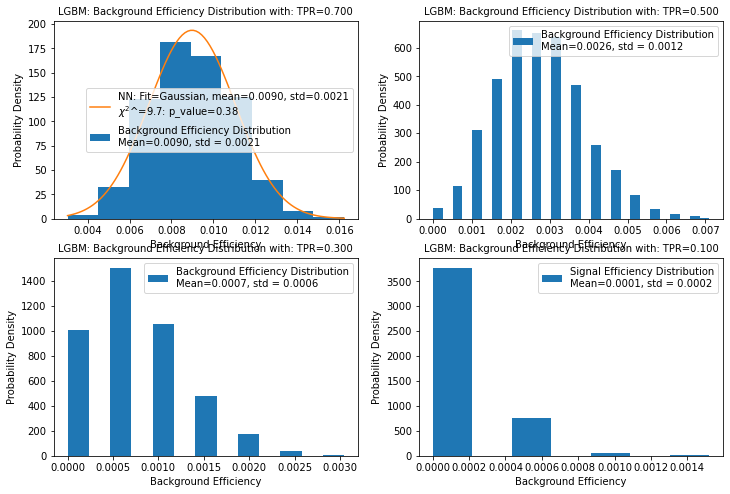

<Figure size 576x432 with 0 Axes>

In [236]:
%%time

#Create figure with axes
fig, ((ax1,ax2),(ax3,ax4))=plt.subplots(2,2,figsize=(12,8))


################################## MAKE SUBPLOT for FPR, TPR=0.7 ###############################

n, dn = 0.7, 0.005

#Calculate Distribution
lgbm_fpr_dist=points(lgbm_best2_average_fpr,lgbm_best2_average_tpr,[n-dn,n+dn])
count,bin_edges,_=ax1.hist(lgbm_fpr_dist,bins=9,density=True,label=f'Background Efficiency Distribution\nMean={np.mean(lgbm_fpr_dist):0.4f}, std = {np.std(lgbm_fpr_dist):0.4f}'); #

#Get Window For our Plot
xmin,xmax=np.min(lgbm_fpr_dist),np.max(lgbm_fpr_dist)
x=np.linspace(xmin,xmax,100)

#Fit Our Distribution and Plot!
fit_func=norm
fit_params=fit_func.fit(lgbm_fpr_dist)
fit=fit_func.pdf(x,*fit_params)


#Now we do Chi Squared Test
bin_centers=centerbins(bin_edges)
fit_at_hist=fit_func.pdf(bin_centers,*fit_params)

chi2_value=chi_squared(count,fit_at_hist,np.sqrt((fit_at_hist)))
chi2_prob = chi2.sf(chi2_value, len(bin_centers))
print(chi2_value,chi2_prob)

#print(fit_params)
ax1.plot(x,fit,label=f'NN: Fit=Gaussian, mean={np.mean(lgbm_fpr_dist):0.4f}, std={np.std(lgbm_fpr_dist):0.4f}\n'+ r'$\chi^2$^'+f'={chi2_value:0.1f}: p_value={chi2_prob:0.2f}')
ax1.set_title(f'LGBM: Background Efficiency Distribution with: TPR={n:0.3f}')

################################## MAKE SUBPLOT for FPR, TPR=0.5 ###############################

n, dn = 0.5, 0.025

#Calculate Distribution
lgbm_fpr_dist=points(lgbm_best2_average_fpr,lgbm_best2_average_tpr,[n-dn,n+dn])
count,bin_edges,_=ax2.hist(lgbm_fpr_dist,bins=28,density=True,label=f'Background Efficiency Distribution\nMean={np.mean(lgbm_fpr_dist):0.4f}, std = {np.std(lgbm_fpr_dist):0.4f}'); #

#Get Window For our Plot
xmin,xmax=np.min(lgbm_fpr_dist),np.max(lgbm_fpr_dist)
x=np.linspace(xmin,xmax,100)

#Fit Our Distribution and Plot!
#fit_func=erlang
#fit_params=fit_func.fit(lgbm_fpr_dist)
#fit=fit_func.pdf(x,*fit_params)


#Now we do Chi Squared Test
#bin_centers=centerbins(bin_edges)
#fit_at_hist=fit_func.pdf(bin_centers,*fit_params)

#chi2_value=chi_squared(count,fit_at_hist,np.sqrt((fit_at_hist)))
#chi2_prob = chi2.sf(chi2_value, len(bin_centers))
#print(chi2_value,chi2_prob)

#print(fit_params)
#ax2.plot(x,fit,label=f'NN: Fit=Erlang, mean={np.mean(lgbm_fpr_dist):0.4f}, std={np.std(lgbm_fpr_dist):0.4f}\n'+ r'$\chi^2$^'+f'={chi2_value:0.1f}: p_value={chi2_prob:0.2f}')
ax2.set_title(f'LGBM: Background Efficiency Distribution with: TPR={n:0.3f}')

################################## MAKE SUBPLOT for FPR, TPR=0.3 ###############################

n, dn = 0.3, 0.05

#Calculate Distribution
lgbm_fpr_dist=points(lgbm_best2_average_fpr,lgbm_best2_average_tpr,[n-dn,n+dn])
count,bin_edges,_=ax3.hist(lgbm_fpr_dist,bins=13,density=True,label=f'Background Efficiency Distribution\nMean={np.mean(lgbm_fpr_dist):0.4f}, std = {np.std(lgbm_fpr_dist):0.4f}'); #

#Get Window For our Plot
xmin,xmax=np.min(lgbm_fpr_dist),np.max(lgbm_fpr_dist)
x=np.linspace(xmin,xmax,100)

#Fit Our Distribution and Plot!
#fit_func=erlang
#fit_params=fit_func.fit(lgbm_fpr_dist)
#fit=fit_func.pdf(x,*fit_params)


#Now we do Chi Squared Test
#bin_centers=centerbins(bin_edges)
#fit_at_hist=fit_func.pdf(bin_centers,*fit_params)

#chi2_value=chi_squared(count,fit_at_hist,np.sqrt((fit_at_hist)))
#chi2_prob = chi2.sf(chi2_value, len(bin_centers))
#print(chi2_value,chi2_prob)

#print(fit_params)
#ax3.plot(x,fit,label=f'NN: Fit=Gamma, mean={np.mean(lgbm_fpr_dist):0.4f}, std={np.std(lgbm_fpr_dist):0.4f}\n'+ r'$\chi^2$^'+f'={chi2_value:0.1f}: p_value={chi2_prob:0.2f}')
ax3.set_title(f'LGBM: Background Efficiency Distribution with: TPR={n:0.3f}')


################################## MAKE SUBPLOT for FPR, TPR=0.1 ###############################

n, dn = 0.1, 0.05

#Calculate Distribution
plt.figure(figsize=(8,6))
lgbm_tpr_dist=points(lgbm_best2_average_fpr,lgbm_best2_average_tpr,[n-dn,n+dn])
count,bin_edges,_=ax4.hist(lgbm_tpr_dist,bins=7,density=True,label=f'Signal Efficiency Distribution\nMean={np.mean(lgbm_tpr_dist):0.4f}, std = {np.std(lgbm_tpr_dist):0.4f}');

#Get Window For our Plot
xmin,xmax=np.min(lgbm_tpr_dist),np.max(lgbm_tpr_dist)
x=np.linspace(xmin,xmax,100)

#Fit Our Distribution and Plot!
#fit_func=gamma
#fit_params=fit_func.fit(lgbm_tpr_dist)
#fit=fit_func.pdf(x,*fit_params)


#Now we do Chi Squared Test
#bin_centers=centerbins(bin_edges)
#fit_at_hist=fit_func.pdf(bin_centers,*fit_params)


#chi2_value=chi_squared(count,fit_at_hist,np.sqrt((fit_at_hist)))
#chi2_prob = chi2.sf(chi2_value, len(bin_centers))
#print(chi2_value,chi2_prob)

#ax4.plot(x,fit,label=f'NN: Fit=Gaussian, mean={np.mean(lgbm_tpr_dist):0.2f},std={np.std(lgbm_tpr_dist):0.2f}\n'+ r'$\chi^2$^'+f'={chi2_value:0.1f}: p_value={chi2_prob:0.2f}')
ax4.set_title(f'LGBM: Background Efficiency Distribution with: TPR={n:0.3f}')


for x in [ax1,ax2,ax3,ax4]:
    x.title.set_size('medium')
    x.set_xlabel('Background Efficiency')
    x.set_ylabel('Probability Density')
    x.legend()

### Doing analysis on Neural Network

First of all, if we plot the TPR and FPR against threshold, we get this.

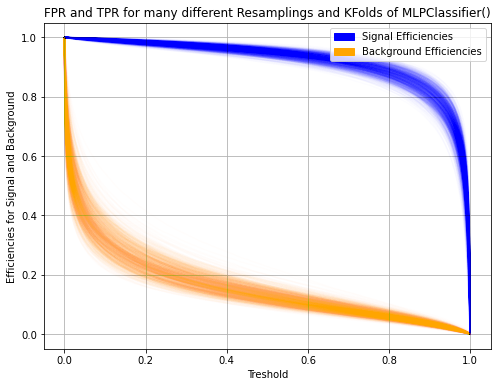

In [60]:
#Small Training, Large Testing Set
fig , ax=plt.subplots(figsize=(8,6))

for n in range(1000):
    ax.plot(nn_best4_scaled_average_thresholds[n][1:],nn_best4_scaled_average_fpr[n][1:],'orange',alpha=0.01)
    ax.plot(nn_best4_scaled_average_thresholds[n][1:],nn_best4_scaled_average_tpr[n][1:],'blue',alpha=0.01)
    
ax.grid()
ax.set_xlabel('Treshold')
ax.set_ylabel('Efficiencies for Signal and Background')
ax.set_title('FPR and TPR for many different Resamplings and KFolds of MLPClassifier()')

blue_patch = mpl.patches.Patch(color='blue', label='Signal Efficiencies')
orange_patch = mpl.patches.Patch(color='orange', label='Background Efficiencies')

ax.legend(handles=[blue_patch,orange_patch],loc='upper right')

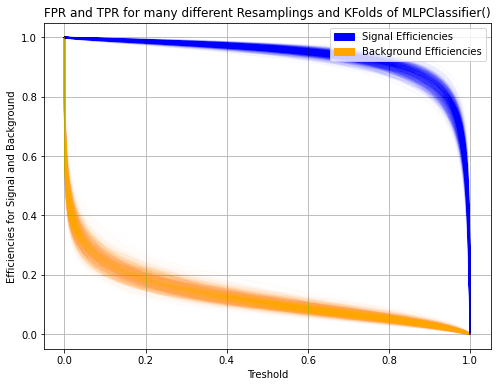

In [85]:
#Large Training Set, Small Testing Set
fig , ax=plt.subplots(figsize=(8,6))

for n in range(1000):
    ax.plot(nn_best1_scaled_average_thresholds[n][1:],nn_best1_scaled_average_fpr[n][1:],'orange',alpha=0.01)
    ax.plot(nn_best1_scaled_average_thresholds[n][1:],nn_best1_scaled_average_tpr[n][1:],'blue',alpha=0.01)
    
ax.grid()
ax.set_xlabel('Treshold')
ax.set_ylabel('Efficiencies for Signal and Background')
ax.set_title('FPR and TPR for many different Resamplings and KFolds of MLPClassifier()')

blue_patch = mpl.patches.Patch(color='blue', label='Signal Efficiencies')
orange_patch = mpl.patches.Patch(color='orange', label='Background Efficiencies')

ax.legend(handles=[blue_patch,orange_patch],loc='upper right')

However, Plotting The TPR against FPR we get this:


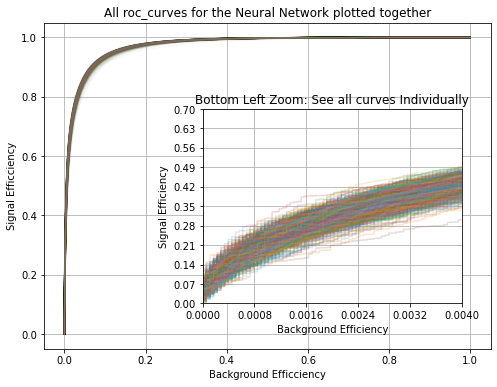

In [61]:

n=0
plt.figure(figsize=(8,6))
for n in range(1000):
    plt.plot(nn_best4_scaled_average_fpr[n],nn_best4_scaled_average_tpr[n],alpha=0.03)

plt.grid()
plt.title('All roc_curves for the Neural Network plotted together')
plt.xlabel('Background Efficciency')
plt.ylabel('Signal Efficciency')



# this is an inset axes over the main axes
a=plt.axes([0.4, 0.23, .45, .45], facecolor='w')
for n in range(1000):
    plt.plot(nn_best4_scaled_average_fpr[n],nn_best4_scaled_average_tpr[n],alpha=0.2)
    
plt.title('Bottom Left Zoom: See all curves Individually')

xlim=0.004

a.set_xlabel('Background Efficiency')
a.set_xlim(0,xlim)
a.set_xticks(np.linspace(0,xlim,6))

ylim=0.7
a.set_ylabel('Signal Efficiency')
a.set_ylim(0,ylim)
a.set_yticks(np.linspace(0,ylim,11))
a.grid()


In [43]:
nn_best3_scaled_average_tpr[0].shape

(51772,)

In [ ]:
%%time

nn_point_mean_tpr , nn_distribution_mean_fpr , nn_distribution_std_fpr=means_for_variable(nn_best3_scaled_average_tpr,nn_best3_scaled_average_fpr)
nn_point_mean_fpr , nn_distribution_mean_tpr , nn_distribution_std_tpr=means_for_variable(nn_best3_scaled_average_fpr,nn_best3_scaled_average_tpr)



(0.0, 0.006)

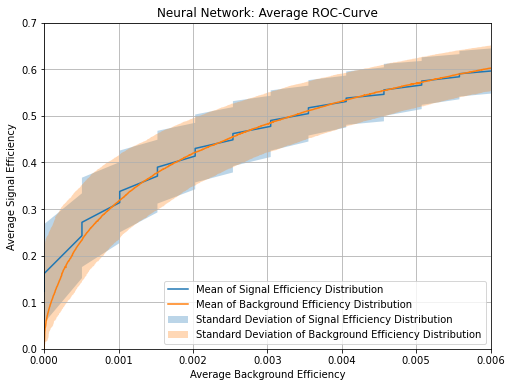

In [53]:
#Bit confusing so follow carefully
plt.figure(figsize=(8,6))

#Plot the roc-curve for which i choose a point on FPR and make distribution of TPR
plt.plot(nn_point_mean_fpr,nn_distribution_mean_tpr,label='Mean of Signal Efficiency Distribution')

#Plot the roc-curve for which i choose a point on tpr and make distribution of fpr
plt.plot(nn_distribution_mean_fpr , nn_point_mean_tpr,label='Mean of Background Efficiency Distribution')


plt.fill_between(nn_point_mean_fpr,nn_distribution_mean_tpr-nn_distribution_std_tpr,nn_distribution_mean_tpr+nn_distribution_std_tpr,alpha=0.3,label='Standard Deviation of Signal Efficiency Distribution')
plt.fill_betweenx(nn_point_mean_tpr,nn_distribution_mean_fpr-nn_distribution_std_fpr,nn_distribution_mean_fpr+nn_distribution_std_fpr,alpha=0.3,label='Standard Deviation of Background Efficiency Distribution')



plt.xlabel('Average Background Efficiency')
plt.ylabel('Average Signal Efficiency')
plt.title('Neural Network: Average ROC-Curve')
plt.legend(loc='lower right')
plt.grid(True)

plt.ylim(0,0.7)
plt.xlim(0,0.006)

In [97]:
nn_thresholds,nn_fpr,nn_std_fpr,nn_tpr,nn_std_tpr=fpr_and_tpr_for_threshold(nn_best1_scaled_average_fpr,nn_best1_scaled_average_tpr,nn_best1_scaled_average_thresholds)

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
222

In [70]:
### HERE I WILL SAVE THE DATA FOR FUTURE USE!
import joblib 

for i ,j in zip(['lgbm_thresholds1','lgbm_fpr1','lgbm_std_fpr1','lgbm_tpr1','lgbm_std_tpr1'],[lgbm_thresholds1,lgbm_fpr1,lgbm_std_fpr1,lgbm_tpr1,lgbm_std_tpr1]):
    joblib.dump(j,i)


In [71]:

#nn_thresholds1=joblib.load('nn_thresholds1')
#nn_fpr1=joblib.load('nn_fpr1')
#nn_std_fpr1=joblib.load('nn_std_fpr1')
#nn_tpr1=joblib.load('nn_tpr1')
#nn_std_tpr1=joblib.load('nn_std_tpr1')

In [67]:
nn_thresholds1,nn_fpr1,nn_std_fpr1,nn_tpr1,nn_std_tpr1

(array([0.00000000e+00, 1.38404871e-05, 1.60589691e-05, ...,
        9.99869364e-01, 9.99878821e-01, 9.99912503e-01]),
 array([9.92410844e-01, 9.88482838e-01, 9.87579365e-01, ...,
        8.01854530e-06, 4.87957125e-06, 1.73083106e-06]),
 array([8.72602304e-03, 1.14816311e-02, 1.21013881e-02, ...,
        2.95807660e-05, 2.61143920e-05, 1.65101809e-05]),
 array([1.        , 1.        , 1.        , ..., 0.017678  , 0.0145489 ,
        0.00766681]),
 array([0.        , 0.        , 0.        , ..., 0.01517683, 0.013078  ,
        0.00856317]))

(0.0, 0.007)

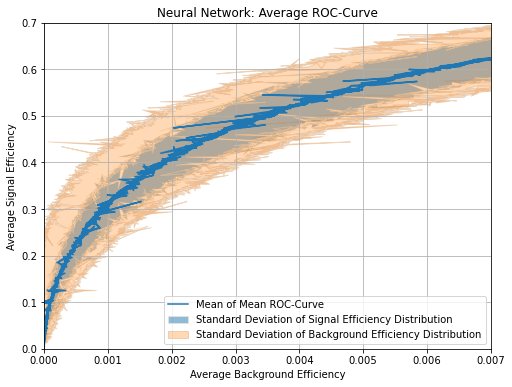

In [98]:
#Bit confusing so follow carefully
plt.figure(figsize=(8,6))

#Plot the roc-curve for which i choose a point on FPR and make distribution of TPR
plt.plot(nn_fpr,nn_tpr,label='Mean of Mean ROC-Curve')


plt.fill_between(nn_fpr,nn_tpr-nn_std_tpr,nn_tpr+nn_std_tpr,alpha=0.5,edgecolor='bisque',label='Standard Deviation of Signal Efficiency Distribution')
plt.fill_betweenx(nn_tpr,nn_fpr-nn_std_fpr,nn_fpr+nn_std_fpr,alpha=0.3,edgecolor='peru',label='Standard Deviation of Background Efficiency Distribution')



plt.xlabel('Average Background Efficiency')
plt.ylabel('Average Signal Efficiency')
plt.title('Neural Network: Average ROC-Curve')
plt.legend(loc='lower right')
plt.grid(True)

plt.ylim(0,0.7)
plt.xlim(0,0.007)

(0.0, 0.007)

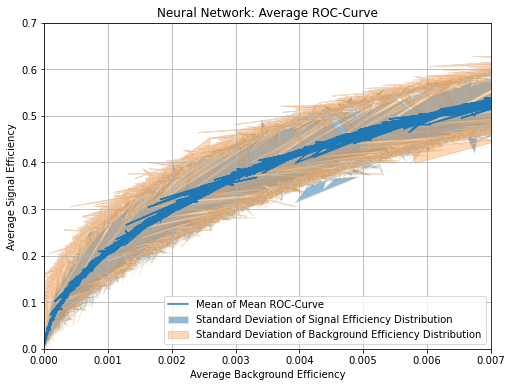

In [86]:
#Bit confusing so follow carefully
plt.figure(figsize=(8,6))

#Plot the roc-curve for which i choose a point on FPR and make distribution of TPR
plt.plot(nn_fpr1,nn_tpr1,label='Mean of Mean ROC-Curve')


plt.fill_between(nn_fpr1,nn_tpr1-nn_std_tpr1,nn_tpr1+nn_std_tpr1,alpha=0.5,edgecolor='bisque',label='Standard Deviation of Signal Efficiency Distribution')
plt.fill_betweenx(nn_tpr1,nn_fpr1-nn_std_fpr1,nn_fpr1+nn_std_fpr1,alpha=0.3,edgecolor='peru',label='Standard Deviation of Background Efficiency Distribution')



plt.xlabel('Average Background Efficiency')
plt.ylabel('Average Signal Efficiency')
plt.title('Neural Network: Average ROC-Curve')
plt.legend(loc='lower right')
plt.grid(True)

plt.ylim(0,0.7)
plt.xlim(0,0.007)

#### Fitting on Nerual Network Dist

#### **SMALL TRAINING LARGE TEST SAMPLE**

0.010662372930433352 0.003044754463028882
0.6121397363096271 0.05052303547241662
Wall time: 197 ms


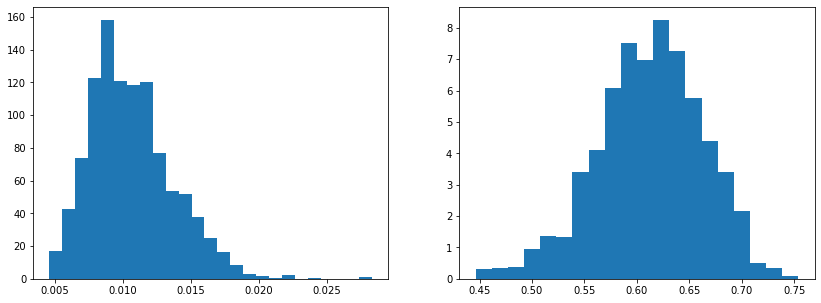

In [43]:
%%time
n, dn = 0.977, 0.0001
fig, ax = plt.subplots(1,2,figsize=(14,5))

nn_fpr_dist=points(nn_best4_scaled_average_fpr,nn_best4_scaled_average_thresholds,[n-dn,n+dn])
hist_fpr=ax[0].hist(nn_fpr_dist,bins=25,density=True);
print(np.mean(nn_fpr_dist),np.std(nn_fpr_dist))

nn_tpr_dist=points(nn_best4_scaled_average_tpr,nn_best4_scaled_average_thresholds,[n-dn,n+dn])
hist_tpr=ax[1].hist(nn_tpr_dist,bins=20,density=True);
print(np.mean(nn_tpr_dist),np.std(nn_tpr_dist))
#np.std(duh)

58.25238490115158 6.80756575309436e-05
(2.2617001711318667, -4.510357917419518e-05, 0.0004388793892937833)
0.6039888477161884 0.9999999999999942
Wall time: 13.1 s


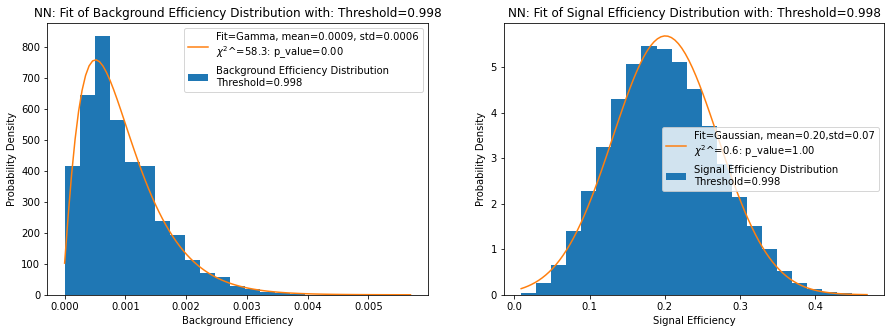

<Figure size 576x432 with 0 Axes>

In [102]:
%%time
#Choose Threshold
n, dn = 0.998, 0.0007

#Create figure with axes
fig, (ax1,ax2)=plt.subplots(1,2,figsize=(15,5))

################################## MAKE SUBPLOT for FPR ###############################
#Calculate Distribution
#plt.figure(figsize=(8,6))
lgbm_fpr_dist=points(nn_best4_scaled_average_fpr,nn_best4_scaled_average_thresholds,[n-dn,n+dn])
count,bin_edges,_=ax1.hist(lgbm_fpr_dist,bins=23,density=True,label=f'Background Efficiency Distribution\nThreshold={n}'); #

#Get Window For our Plot
xmin,xmax=np.min(lgbm_fpr_dist),np.max(lgbm_fpr_dist)
x=np.linspace(xmin,xmax,100)

#Fit Our Distribution and Plot!
fit_func=gamma
fit_params=fit_func.fit(lgbm_fpr_dist)
fit=fit_func.pdf(x,*fit_params)


#Now we do Chi Squared Test
bin_centers=centerbins(bin_edges)
fit_at_hist=fit_func.pdf(bin_centers,*fit_params)

chi2_value=chi_squared(count,fit_at_hist,np.sqrt((fit_at_hist)))
chi2_prob = chi2.sf(chi2_value, len(bin_centers))
print(chi2_value,chi2_prob)

print(fit_params)
ax1.plot(x,fit,label=f'Fit=Gamma, mean={np.mean(lgbm_fpr_dist):0.4f}, std={np.std(lgbm_fpr_dist):0.4f}\n'+ r'$\chi^2$^'+f'={chi2_value:0.1f}: p_value={chi2_prob:0.2f}')
ax1.set_title(f'NN: Fit of Background Efficiency Distribution with: Threshold={n:0.3f}')
ax1.set_xlabel('Background Efficiency')
ax1.set_ylabel('Probability Density')
ax1.legend(loc='upper right')
################################## MAKE SUBPLOT for TPR ###############################

#Calculate Distribution
plt.figure(figsize=(8,6))
lgbm_tpr_dist=points(nn_best4_scaled_average_tpr,nn_best4_scaled_average_thresholds,[n-dn,n+dn])
count,bin_edges,_=ax2.hist(lgbm_tpr_dist,bins=23,density=True,label=f'Signal Efficiency Distribution\nThreshold={n}');

#Get Window For our Plot
xmin,xmax=np.min(lgbm_tpr_dist),np.max(lgbm_tpr_dist)
x=np.linspace(xmin,xmax,100)

#Fit Our Distribution and Plot!
fit_func=norm
fit_params=fit_func.fit(lgbm_tpr_dist)
fit=fit_func.pdf(x,*fit_params)


#Now we do Chi Squared Test
bin_centers=centerbins(bin_edges)
fit_at_hist=fit_func.pdf(bin_centers,*fit_params)


chi2_value=chi_squared(count,fit_at_hist,np.sqrt((fit_at_hist)))
chi2_prob = chi2.sf(chi2_value, len(bin_centers))
print(chi2_value,chi2_prob)

ax2.plot(x,fit,label=f'Fit=Gaussian, mean={np.mean(lgbm_tpr_dist):0.2f},std={np.std(lgbm_tpr_dist):0.2f}\n'+ r'$\chi^2$^'+f'={chi2_value:0.1f}: p_value={chi2_prob:0.2f}')
ax2.set_title(f'NN: Fit of Signal Efficiency Distribution with: Threshold={n:0.3f}')
ax2.set_xlabel('Signal Efficiency')
ax2.set_ylabel('Probability Density')
ax2.legend()

#### Now we find FPR for TPR dist

C:\Users\Bruger\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:2804: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 31.5.
  warnings.warn(
C:\Users\Bruger\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:2804: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 28.5.
  warnings.warn(
C:\Users\Bruger\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:2804: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 29.75.
  warnings.warn(
C:\Users\Bruger\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:2804: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 29.25.
  warnings.warn(
C:\Users\Bruger\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:2804: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer va

27.5025674724931 0.33125468189541296


C:\Users\Bruger\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:2804: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 18.900000000000002.
  warnings.warn(
C:\Users\Bruger\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:2804: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 17.099999999999998.
  warnings.warn(
C:\Users\Bruger\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:2804: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 17.4.
  warnings.warn(
C:\Users\Bruger\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:2804: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 17.549999999999997.
  warnings.warn(
C:\Users\Bruger\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:2804: RuntimeWarning: The shape parameter of the erlang dist

27.523729980096764 0.33023895387730623


C:\Users\Bruger\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:2804: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 16.8.
  warnings.warn(
C:\Users\Bruger\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:2804: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 15.2.
  warnings.warn(
C:\Users\Bruger\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:2804: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 15.466666666666669.
  warnings.warn(
C:\Users\Bruger\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:2804: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 15.866666666666667.
  warnings.warn(
C:\Users\Bruger\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:2804: RuntimeWarning: The shape parameter of the erlang distribution has b

62.34839632009128 4.925054821469422e-05
Wall time: 54.2 s


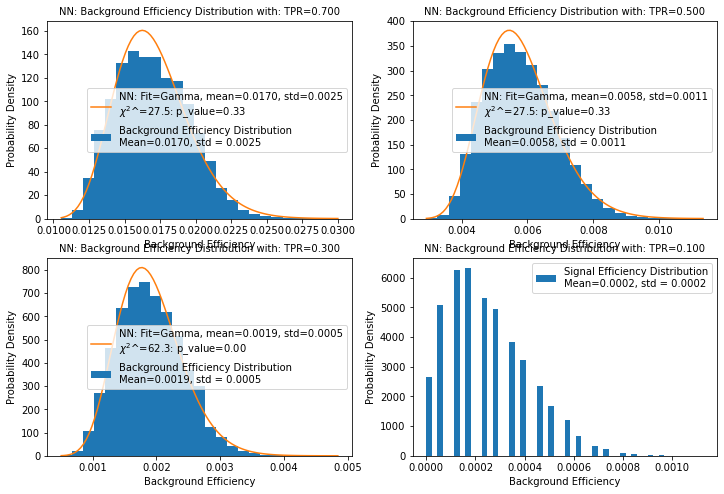

<Figure size 576x432 with 0 Axes>

In [156]:
%%time
#Choose Threshold
n, dn = 0.4, 0.055

#Create figure with axes
fig, ((ax1,ax2),(ax3,ax4))=plt.subplots(2,2,figsize=(12,8))


################################## MAKE SUBPLOT for FPR, TPR=0.7 ###############################

n, dn = 0.7, 0.035

#Calculate Distribution
lgbm_fpr_dist=points(nn_best4_scaled_average_fpr,nn_best4_scaled_average_tpr,[n-dn,n+dn])
count,bin_edges,_=ax1.hist(lgbm_fpr_dist,bins=25,density=True,label=f'Background Efficiency Distribution\nMean={np.mean(lgbm_fpr_dist):0.4f}, std = {np.std(lgbm_fpr_dist):0.4f}'); #

#Get Window For our Plot
xmin,xmax=np.min(lgbm_fpr_dist),np.max(lgbm_fpr_dist)
x=np.linspace(xmin,xmax,100)

#Fit Our Distribution and Plot!
fit_func=erlang
fit_params=fit_func.fit(lgbm_fpr_dist)
fit=fit_func.pdf(x,*fit_params)


#Now we do Chi Squared Test
bin_centers=centerbins(bin_edges)
fit_at_hist=fit_func.pdf(bin_centers,*fit_params)

chi2_value=chi_squared(count,fit_at_hist,np.sqrt((fit_at_hist)))
chi2_prob = chi2.sf(chi2_value, len(bin_centers))
print(chi2_value,chi2_prob)

#print(fit_params)
ax1.plot(x,fit,label=f'NN: Fit=Gamma, mean={np.mean(lgbm_fpr_dist):0.4f}, std={np.std(lgbm_fpr_dist):0.4f}\n'+ r'$\chi^2$^'+f'={chi2_value:0.1f}: p_value={chi2_prob:0.2f}')
ax1.set_title(f'NN: Background Efficiency Distribution with: TPR={n:0.3f}')

################################## MAKE SUBPLOT for FPR, TPR=0.5 ###############################

n, dn = 0.5, 0.05

#Calculate Distribution
lgbm_fpr_dist=points(nn_best4_scaled_average_fpr,nn_best4_scaled_average_tpr,[n-dn,n+dn])
count,bin_edges,_=ax2.hist(lgbm_fpr_dist,bins=25,density=True,label=f'Background Efficiency Distribution\nMean={np.mean(lgbm_fpr_dist):0.4f}, std = {np.std(lgbm_fpr_dist):0.4f}'); #

#Get Window For our Plot
xmin,xmax=np.min(lgbm_fpr_dist),np.max(lgbm_fpr_dist)
x=np.linspace(xmin,xmax,100)

#Fit Our Distribution and Plot!
fit_func=erlang
fit_params=fit_func.fit(lgbm_fpr_dist)
fit=fit_func.pdf(x,*fit_params)


#Now we do Chi Squared Test
bin_centers=centerbins(bin_edges)
fit_at_hist=fit_func.pdf(bin_centers,*fit_params)

chi2_value=chi_squared(count,fit_at_hist,np.sqrt((fit_at_hist)))
chi2_prob = chi2.sf(chi2_value, len(bin_centers))
print(chi2_value,chi2_prob)

#print(fit_params)
ax2.plot(x,fit,label=f'NN: Fit=Gamma, mean={np.mean(lgbm_fpr_dist):0.4f}, std={np.std(lgbm_fpr_dist):0.4f}\n'+ r'$\chi^2$^'+f'={chi2_value:0.1f}: p_value={chi2_prob:0.2f}')
ax2.set_title(f'NN: Background Efficiency Distribution with: TPR={n:0.3f}')

################################## MAKE SUBPLOT for FPR, TPR=0.3 ###############################

n, dn = 0.3, 0.05

#Calculate Distribution
lgbm_fpr_dist=points(nn_best4_scaled_average_fpr,nn_best4_scaled_average_tpr,[n-dn,n+dn])
count,bin_edges,_=ax3.hist(lgbm_fpr_dist,bins=25,density=True,label=f'Background Efficiency Distribution\nMean={np.mean(lgbm_fpr_dist):0.4f}, std = {np.std(lgbm_fpr_dist):0.4f}'); #

#Get Window For our Plot
xmin,xmax=np.min(lgbm_fpr_dist),np.max(lgbm_fpr_dist)
x=np.linspace(xmin,xmax,100)

#Fit Our Distribution and Plot!
fit_func=erlang
fit_params=fit_func.fit(lgbm_fpr_dist)
fit=fit_func.pdf(x,*fit_params)


#Now we do Chi Squared Test
bin_centers=centerbins(bin_edges)
fit_at_hist=fit_func.pdf(bin_centers,*fit_params)

chi2_value=chi_squared(count,fit_at_hist,np.sqrt((fit_at_hist)))
chi2_prob = chi2.sf(chi2_value, len(bin_centers))
print(chi2_value,chi2_prob)

#print(fit_params)
ax3.plot(x,fit,label=f'NN: Fit=Gamma, mean={np.mean(lgbm_fpr_dist):0.4f}, std={np.std(lgbm_fpr_dist):0.4f}\n'+ r'$\chi^2$^'+f'={chi2_value:0.1f}: p_value={chi2_prob:0.2f}')
ax3.set_title(f'NN: Background Efficiency Distribution with: TPR={n:0.3f}')


################################## MAKE SUBPLOT for FPR, TPR=0.1 ###############################

n, dn = 0.1, 0.05

#Calculate Distribution
plt.figure(figsize=(8,6))
lgbm_tpr_dist=points(nn_best4_scaled_average_fpr,nn_best4_scaled_average_tpr,[n-dn,n+dn])
count,bin_edges,_=ax4.hist(lgbm_tpr_dist,bins=50,density=True,label=f'Signal Efficiency Distribution\nMean={np.mean(lgbm_tpr_dist):0.4f}, std = {np.std(lgbm_tpr_dist):0.4f}');

#Get Window For our Plot
xmin,xmax=np.min(lgbm_tpr_dist),np.max(lgbm_tpr_dist)
x=np.linspace(xmin,xmax,100)

#Fit Our Distribution and Plot!
#fit_func=gamma
#fit_params=fit_func.fit(lgbm_tpr_dist)
#fit=fit_func.pdf(x,*fit_params)


#Now we do Chi Squared Test
#bin_centers=centerbins(bin_edges)
#fit_at_hist=fit_func.pdf(bin_centers,*fit_params)


#chi2_value=chi_squared(count,fit_at_hist,np.sqrt((fit_at_hist)))
#chi2_prob = chi2.sf(chi2_value, len(bin_centers))
#print(chi2_value,chi2_prob)

#ax4.plot(x,fit,label=f'NN: Fit=Gaussian, mean={np.mean(lgbm_tpr_dist):0.2f},std={np.std(lgbm_tpr_dist):0.2f}\n'+ r'$\chi^2$^'+f'={chi2_value:0.1f}: p_value={chi2_prob:0.2f}')
ax4.set_title(f'NN: Background Efficiency Distribution with: TPR={n:0.3f}')


for x in [ax1,ax2,ax3,ax4]:
    x.title.set_size('medium')
    x.set_xlabel('Background Efficiency')
    x.set_ylabel('Probability Density')
    x.legend()

#### **LARGE TRAINING SAMLE SMALL TEST SAMPLE**

In [47]:
def center_bins(bins):
    return (bins[1:]+bins[:-1])/2

0.6693153030912498 0.9999999999999817
0.6693153030912498 0.9999999999999817
Wall time: 154 ms


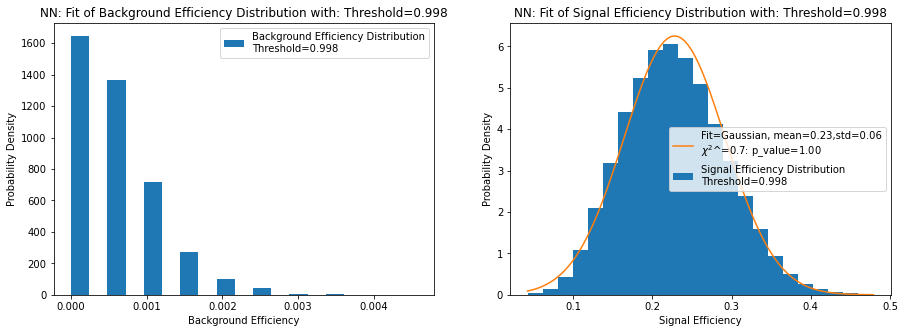

<Figure size 576x432 with 0 Axes>

In [160]:
%%time
#Choose Threshold
n, dn = 0.998, 0.0007

#Create figure with axes
fig, (ax1,ax2)=plt.subplots(1,2,figsize=(15,5))

################################## MAKE SUBPLOT for FPR ###############################
#Calculate Distribution
#plt.figure(figsize=(8,6))
lgbm_fpr_dist=points(nn_best1_scaled_average_fpr,nn_best1_scaled_average_thresholds,[n-dn,n+dn])
count,bin_edges,_=ax1.hist(lgbm_fpr_dist,bins=19,density=True,label=f'Background Efficiency Distribution\nThreshold={n}'); #

#Get Window For our Plot
xmin,xmax=np.min(lgbm_fpr_dist),np.max(lgbm_fpr_dist)
x=np.linspace(xmin,xmax,100)

#Fit Our Distribution and Plot!
#fit_func=gamma
#fit_params=fit_func.fit(lgbm_fpr_dist)
#fit=fit_func.pdf(x,*fit_params)


#Now we do Chi Squared Test
#bin_centers=centerbins(bin_edges)
#fit_at_hist=fit_func.pdf(bin_centers,*fit_params)

#chi2_value=chi_squared(count,fit_at_hist,np.sqrt((fit_at_hist)))
#chi2_prob = chi2.sf(chi2_value, len(bin_centers))
print(chi2_value,chi2_prob)

#print(fit_params)
#ax1.plot(x,fit,label=f'Fit=Gamma, mean={np.mean(lgbm_fpr_dist):0.4f}, std={np.std(lgbm_fpr_dist):0.4f}\n'+ r'$\chi^2$^'+f'={chi2_value:0.1f}: p_value={chi2_prob:0.2f}')
ax1.set_title(f'NN: Fit of Background Efficiency Distribution with: Threshold={n:0.3f}')
ax1.set_xlabel('Background Efficiency')
ax1.set_ylabel('Probability Density')
ax1.legend(loc='upper right')
################################## MAKE SUBPLOT for TPR ###############################

#Calculate Distribution
plt.figure(figsize=(8,6))
lgbm_tpr_dist=points(nn_best1_scaled_average_tpr,nn_best1_scaled_average_thresholds,[n-dn,n+dn])
count,bin_edges,_=ax2.hist(lgbm_tpr_dist,bins=23,density=True,label=f'Signal Efficiency Distribution\nThreshold={n}');

#Get Window For our Plot
xmin,xmax=np.min(lgbm_tpr_dist),np.max(lgbm_tpr_dist)
x=np.linspace(xmin,xmax,100)

#Fit Our Distribution and Plot!
fit_func=norm
fit_params=fit_func.fit(lgbm_tpr_dist)
fit=fit_func.pdf(x,*fit_params)


#Now we do Chi Squared Test
bin_centers=centerbins(bin_edges)
fit_at_hist=fit_func.pdf(bin_centers,*fit_params)


chi2_value=chi_squared(count,fit_at_hist,np.sqrt((fit_at_hist)))
chi2_prob = chi2.sf(chi2_value, len(bin_centers))
print(chi2_value,chi2_prob)

ax2.plot(x,fit,label=f'Fit=Gaussian, mean={np.mean(lgbm_tpr_dist):0.2f},std={np.std(lgbm_tpr_dist):0.2f}\n'+ r'$\chi^2$^'+f'={chi2_value:0.1f}: p_value={chi2_prob:0.2f}')
ax2.set_title(f'NN: Fit of Signal Efficiency Distribution with: Threshold={n:0.3f}')
ax2.set_xlabel('Signal Efficiency')
ax2.set_ylabel('Probability Density')
ax2.legend()

C:\Users\Bruger\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:2804: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 28.35.
  warnings.warn(
C:\Users\Bruger\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:2804: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 25.65.
  warnings.warn(
C:\Users\Bruger\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:2804: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 26.1.
  warnings.warn(
C:\Users\Bruger\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:2804: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 26.775.
  warnings.warn(
C:\Users\Bruger\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:2804: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer 

Wall time: 2.88 s


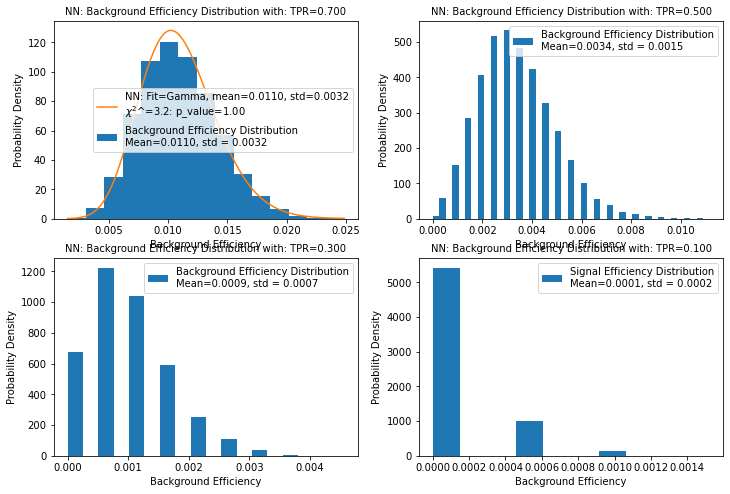

<Figure size 576x432 with 0 Axes>

In [180]:
%%time
#Choose Threshold
n, dn = 0.4, 0.055

#Create figure with axes
fig, ((ax1,ax2),(ax3,ax4))=plt.subplots(2,2,figsize=(12,8))


################################## MAKE SUBPLOT for FPR, TPR=0.7 ###############################

n, dn = 0.7, 0.055

#Calculate Distribution
lgbm_fpr_dist=points(nn_best1_scaled_average_fpr,nn_best1_scaled_average_tpr,[n-dn,n+dn])
count,bin_edges,_=ax1.hist(lgbm_fpr_dist,bins=15,density=True,label=f'Background Efficiency Distribution\nMean={np.mean(lgbm_fpr_dist):0.4f}, std = {np.std(lgbm_fpr_dist):0.4f}'); #

#Get Window For our Plot
xmin,xmax=np.min(lgbm_fpr_dist),np.max(lgbm_fpr_dist)
x=np.linspace(xmin,xmax,100)

#Fit Our Distribution and Plot!
fit_func=erlang
fit_params=fit_func.fit(lgbm_fpr_dist)
fit=fit_func.pdf(x,*fit_params)


#Now we do Chi Squared Test
bin_centers=centerbins(bin_edges)
fit_at_hist=fit_func.pdf(bin_centers,*fit_params)

chi2_value=chi_squared(count,fit_at_hist,np.sqrt((fit_at_hist)))
chi2_prob = chi2.sf(chi2_value, len(bin_centers))
#print(chi2_value,chi2_prob)

#print(fit_params)
ax1.plot(x,fit,label=f'NN: Fit=Gamma, mean={np.mean(lgbm_fpr_dist):0.4f}, std={np.std(lgbm_fpr_dist):0.4f}\n'+ r'$\chi^2$^'+f'={chi2_value:0.1f}: p_value={chi2_prob:0.2f}')
ax1.set_title(f'NN: Background Efficiency Distribution with: TPR={n:0.3f}')

################################## MAKE SUBPLOT for FPR, TPR=0.5 ###############################

n, dn = 0.5, 0.07

#Calculate Distribution
lgbm_fpr_dist=points(nn_best1_scaled_average_fpr,nn_best1_scaled_average_tpr,[n-dn,n+dn])
count,bin_edges,_=ax2.hist(lgbm_fpr_dist,bins=43,density=True,label=f'Background Efficiency Distribution\nMean={np.mean(lgbm_fpr_dist):0.4f}, std = {np.std(lgbm_fpr_dist):0.4f}'); #

#Get Window For our Plot
xmin,xmax=np.min(lgbm_fpr_dist),np.max(lgbm_fpr_dist)
x=np.linspace(xmin,xmax,100)

#Fit Our Distribution and Plot!
#fit_func=erlang
#fit_params=fit_func.fit(lgbm_fpr_dist)
#fit=fit_func.pdf(x,*fit_params)


#Now we do Chi Squared Test
#bin_centers=centerbins(bin_edges)
#fit_at_hist=fit_func.pdf(bin_centers,*fit_params)

#chi2_value=chi_squared(count,fit_at_hist,np.sqrt((fit_at_hist)))
#chi2_prob = chi2.sf(chi2_value, len(bin_centers))
#print(chi2_value,chi2_prob)

#print(fit_params)
#ax2.plot(x,fit,label=f'NN: Fit=Gamma, mean={np.mean(lgbm_fpr_dist):0.4f}, std={np.std(lgbm_fpr_dist):0.4f}\n'+ r'$\chi^2$^'+f'={chi2_value:0.1f}: p_value={chi2_prob:0.2f}')
ax2.set_title(f'NN: Background Efficiency Distribution with: TPR={n:0.3f}')

################################## MAKE SUBPLOT for FPR, TPR=0.3 ###############################

n, dn = 0.3, 0.055

#Calculate Distribution
lgbm_fpr_dist=points(nn_best1_scaled_average_fpr,nn_best1_scaled_average_tpr,[n-dn,n+dn])
count,bin_edges,_=ax3.hist(lgbm_fpr_dist,bins=18,density=True,label=f'Background Efficiency Distribution\nMean={np.mean(lgbm_fpr_dist):0.4f}, std = {np.std(lgbm_fpr_dist):0.4f}'); #

#Get Window For our Plot
xmin,xmax=np.min(lgbm_fpr_dist),np.max(lgbm_fpr_dist)
x=np.linspace(xmin,xmax,100)

#Fit Our Distribution and Plot!
#fit_func=erlang
#fit_params=fit_func.fit(lgbm_fpr_dist)
#fit=fit_func.pdf(x,*fit_params)


#Now we do Chi Squared Test
#bin_centers=centerbins(bin_edges)
#fit_at_hist=fit_func.pdf(bin_centers,*fit_params)

#chi2_value=chi_squared(count,fit_at_hist,np.sqrt((fit_at_hist)))
#chi2_prob = chi2.sf(chi2_value, len(bin_centers))
#print(chi2_value,chi2_prob)

#print(fit_params)
#ax3.plot(x,fit,label=f'NN: Fit=Gamma, mean={np.mean(lgbm_fpr_dist):0.4f}, std={np.std(lgbm_fpr_dist):0.4f}\n'+ r'$\chi^2$^'+f'={chi2_value:0.1f}: p_value={chi2_prob:0.2f}')
ax3.set_title(f'NN: Background Efficiency Distribution with: TPR={n:0.3f}')


################################## MAKE SUBPLOT for FPR, TPR=0.1 ###############################

n, dn = 0.1, 0.055

#Calculate Distribution
plt.figure(figsize=(8,6))
lgbm_tpr_dist=points(nn_best1_scaled_average_fpr,nn_best1_scaled_average_tpr,[n-dn,n+dn])
count,bin_edges,_=ax4.hist(lgbm_tpr_dist,bins=10,density=True,label=f'Signal Efficiency Distribution\nMean={np.mean(lgbm_tpr_dist):0.4f}, std = {np.std(lgbm_tpr_dist):0.4f}');

#Get Window For our Plot
xmin,xmax=np.min(lgbm_tpr_dist),np.max(lgbm_tpr_dist)
x=np.linspace(xmin,xmax,100)

#Fit Our Distribution and Plot!
#fit_func=gamma
#fit_params=fit_func.fit(lgbm_tpr_dist)
#fit=fit_func.pdf(x,*fit_params)


#Now we do Chi Squared Test
#bin_centers=centerbins(bin_edges)
#fit_at_hist=fit_func.pdf(bin_centers,*fit_params)


#chi2_value=chi_squared(count,fit_at_hist,np.sqrt((fit_at_hist)))
#chi2_prob = chi2.sf(chi2_value, len(bin_centers))
#print(chi2_value,chi2_prob)

#ax4.plot(x,fit,label=f'NN: Fit=Gaussian, mean={np.mean(lgbm_tpr_dist):0.2f},std={np.std(lgbm_tpr_dist):0.2f}\n'+ r'$\chi^2$^'+f'={chi2_value:0.1f}: p_value={chi2_prob:0.2f}')
ax4.set_title(f'NN: Background Efficiency Distribution with: TPR={n:0.3f}')


for x in [ax1,ax2,ax3,ax4]:
    x.title.set_size('medium')
    x.set_xlabel('Background Efficiency')
    x.set_ylabel('Probability Density')
    x.legend()

These two plots together tell us that we should compare the TPR to FPR directly, without using threshold values as an intermediate step. Because we likely have enough statistics, which we didnt have for the LGBM: That is what i do now:

0.0003988810461294286 0.0003427203129812172
0.12596095367606402 0.0539830637479148


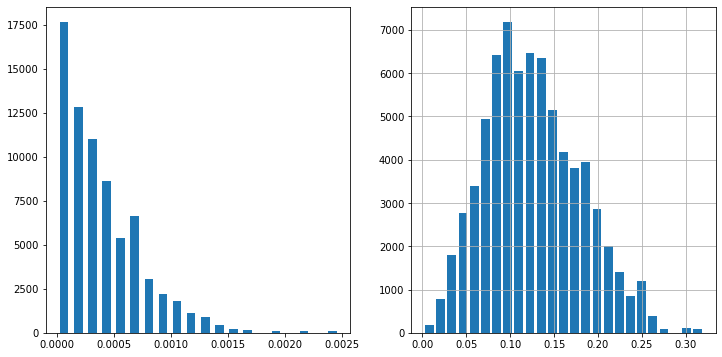

In [99]:
t=0.999
dt=0.00001
nn_dist_fpr=points(nn_best3_scaled_average_fpr,nn_best3_scaled_average_thresholds,(t-dt,t+dt))
nn_dist_tpr=points(nn_best3_scaled_average_tpr,nn_best3_scaled_average_thresholds,(t-dt,t+dt))

fig, ax,= plt.subplots(1,2,figsize=(12,6))

nn_counts ,nn_bins=np.histogram(nn_dist_fpr,bins=20)
nn_bins= center_bins(nn_bins)
ax[0].bar(nn_bins,nn_counts,width=0.00015/2)
#ax[0].set_xlim(0,1)
#ax[0].set_ylim(0,1)

print(np.mean(nn_dist_fpr),np.std(nn_dist_fpr))

nn_counts ,nn_bins=np.histogram(nn_dist_tpr,bins=25)
nn_bins= center_bins(nn_bins)
ax[1].bar(nn_bins[:],nn_counts,width=0.01)
print(np.mean(nn_dist_tpr),np.std(nn_dist_tpr))

plt.grid()

## Learning Curves

In [211]:
def plot_learning_curve(estimator,title,X,y,axes=None,ylim=None,cv=None,n_jobs=None,scoring=None,train_sizes=np.linspace(0.1, 1.0, 5)):

    plt.title(title)
    
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        scoring=scoring,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    plt.grid()
    plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    plt.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    plt.plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    plt.plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    plt.legend(loc="best")


    return plt



### Learning CUrve NN

In [223]:


X_scaled=scalar.transform(X)

nn_best_parameters=OrderedDict([('activation', 'tanh'),
                              ('alpha', 1e-07),
                              ('beta_1', 0.5545561677659581),
                              ('beta_2', 0.5713485660228933),
                              ('epsilon', 0.000492036188902597),
                              ('hidden_layer_sizes', 200),
                              ('learning_rate_init', 0.02199012604107307),
                              ('max_iter', 537),
                              ('solver', 'adam'),
                              ('tol', 0.049795769219370685)])

best_nn_clf=neural_network.MLPClassifier(**nn_best_parameters)
best_nn_clf.fit(X_scaled,y)

MLPClassifier(activation='tanh', alpha=1e-07, beta_1=0.5545561677659581,
              beta_2=0.5713485660228933, epsilon=0.000492036188902597,
              hidden_layer_sizes=200, learning_rate_init=0.02199012604107307,
              max_iter=537, tol=0.049795769219370685)

Wall time: 11.9 s


<module 'matplotlib.pyplot' from 'C:\\Users\\Bruger\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

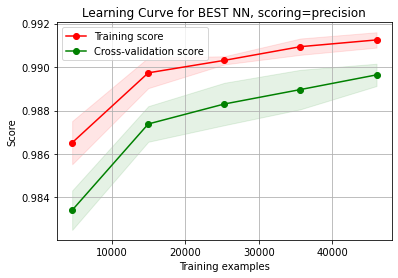

In [222]:
%%time

plt.figure()
plot_learning_curve(best_nn_clf,'Learning Curve for BEST NN, scoring=average_precision',X_scaled,y,n_jobs=-1,scoring='average_precision')

In [216]:
X_scaled=scalar.transform(X)

best_parameters2={'activation': 'relu', 'hidden_layer_sizes': 300, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'max_iter': 200, 'solver': 'sgd', 'tol': 1e-05}

best_nn_clf2=neural_network.MLPClassifier()
best_nn_clf2.fit(X_scaled,y)

C:\Users\Bruger\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier()

Wall time: 1min 30s


<module 'matplotlib.pyplot' from 'C:\\Users\\Bruger\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

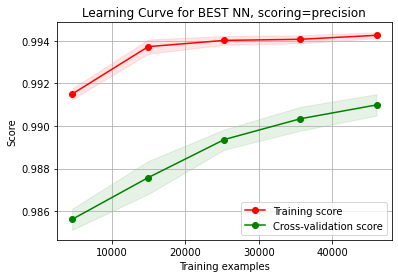

In [219]:
%%time

plt.figure()
plot_learning_curve(best_nn_clf2,'Learning Curve for BEST NN, scoring=precision',X_scaled,y,n_jobs=-1,scoring='average_precision')

###  Learning Curve for LightGBM

In [209]:
#Choose The CLassifier with best Parameters
#I Chose The Parameters Found with Bayesian Optimization, Opimizing for Average-Precision. Second run
best_parameters=OrderedDict([('boosting_type', 'gbdt'),('learning_rate', 0.08070423147486032),('max_depth', 10),('min_child_samples', 315),('min_child_weight', 17),('n_estimators', 869), ('num_leaves', 20),('reg_alpha', 2), ('reg_lambda', 5)])
lgbm_clf=lgb.LGBMClassifier(**best_parameters)

<module 'matplotlib.pyplot' from 'C:\\Users\\Bruger\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

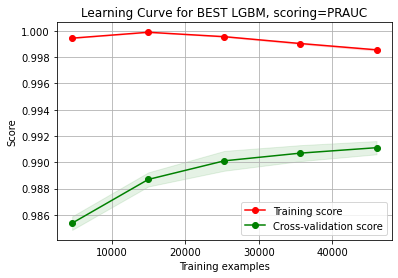

In [212]:
plot_learning_curve(lgbm_clf,'Learning Curve for BEST LGBM, scoring=PRAUC',X,y,n_jobs=-1,scoring='average_precision')

## OutPut Distribution for lgbm

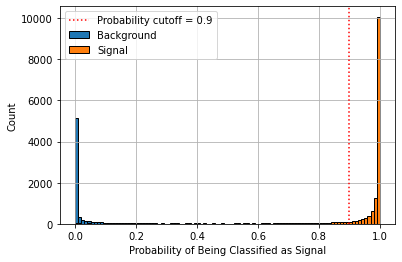

In [49]:
OutputDistribution(lgbm_clf,X_test,y_test,0.9,bins_=100)

Text(0.5, 1.0, 'Distribution for Optimized LGBM, Logarithmic Scale')

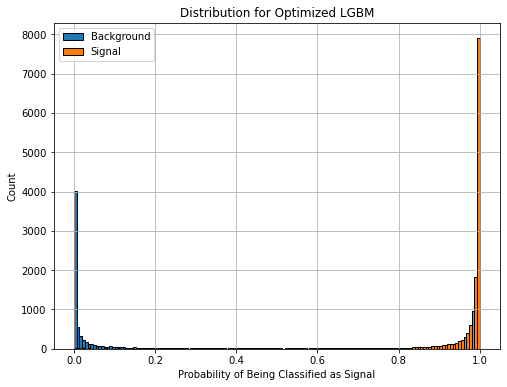

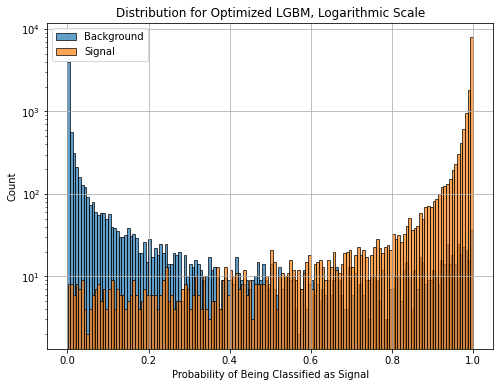

In [140]:
plt.figure(1,figsize=(8,6))
OutputDistribution(lgbm_clf,X_test,y_test,bins_=150)
plt.title('Distribution for Optimized LGBM')
plt.figure(2,figsize=(8,6))
OutputDistribution(lgbm_clf,X_test,y_test,bins_=150, scale='log',alpha=0.7)
plt.title('Distribution for Optimized LGBM, Logarithmic Scale')

### Learning Curve LGBM Optimized

## Output Probability DIstribution of NN and LGBM

**Neural Network First**

In [226]:
%%time
nn_best_parameters=OrderedDict([('activation', 'tanh'),
                              ('alpha', 1e-07),
                              ('beta_1', 0.5545561677659581),
                              ('beta_2', 0.5713485660228933),
                              ('epsilon', 0.000492036188902597),
                              ('hidden_layer_sizes', 200),
                              ('learning_rate_init', 0.02199012604107307),
                              ('max_iter', 537),
                              ('solver', 'adam'),
                              ('tol', 0.049795769219370685)])

best_nn_clf=neural_network.MLPClassifier(**nn_best_parameters)
best_nn_clf.fit(X_scaled,y)

Wall time: 4.77 s


MLPClassifier(activation='tanh', alpha=1e-07, beta_1=0.5545561677659581,
              beta_2=0.5713485660228933, epsilon=0.000492036188902597,
              hidden_layer_sizes=200, learning_rate_init=0.02199012604107307,
              max_iter=537, tol=0.049795769219370685)

Text(0.5, 1.0, 'Output Distribution for Optimized Neural-Network')

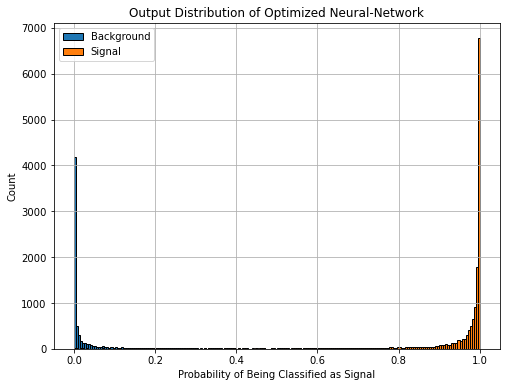

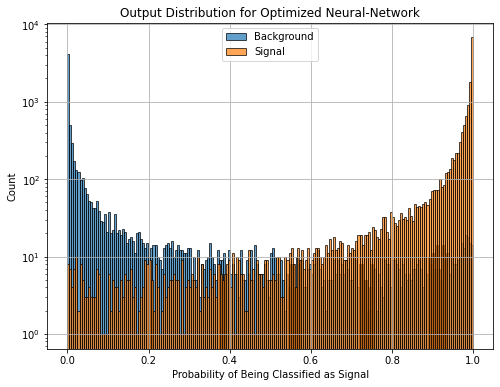

In [227]:
plt.figure(1,figsize=[8,6])
OutputDistribution(best_nn_clf,X_test_scaled,y_test,bins_=200,nature='arrs')
plt.title('Output Distribution of Optimized Neural-Network')

plt.figure(2,figsize=[8,6])
OutputDistribution(best_nn_clf,X_test_scaled,y_test,bins_=200, scale='log',alpha=0.7,nature='arrs')
plt.title('Output Distribution for Optimized Neural-Network')

**Now LGBM**

Text(0.5, 1.0, 'Output Distribution of BEST LGBM, Logarithmic Scale')

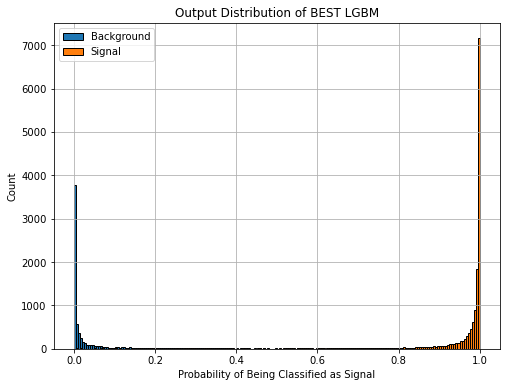

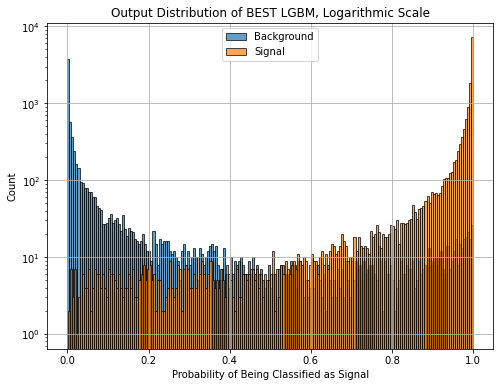

In [233]:
best_parameters=OrderedDict([('boosting_type', 'gbdt'),('learning_rate', 0.08070423147486032),('max_depth', 10),('min_child_samples', 315),('min_child_weight', 17),('n_estimators', 869), ('num_leaves', 20),('reg_alpha', 2), ('reg_lambda', 5)])
lgbm_clf=lgb.LGBMClassifier(**best_parameters)
lgbm_clf.fit(X_train,y_train)

plt.figure(1,figsize=(8,6))
OutputDistribution(lgbm_clf,X_test,y_test,bins_=200)
plt.title('Output Distribution of BEST LGBM')

plt.figure(2,figsize=(8,6))
OutputDistribution(lgbm_clf,X_test,y_test,bins_=200, scale='log',alpha=0.7)
plt.title('Output Distribution of BEST LGBM, Logarithmic Scale')

## Precision_recall at t

In [221]:
#Plot precision with threshold

def plot_f1_precision_recall_threshold(model,X_test_,y_test_,thresholds):
    
    prediction_probability=model.predict_proba(X_test_)[:,1]
    
    precision_scores=np.array([])
    recall_scores=np.array([])
    F1_scores=np.array([])
    
    for threshold in thresholds[1:]:        
        prediction=(prediction_probability>=threshold)
        
        tn, fp, fn, tp = confusion_matrix(y_test_, prediction).ravel()
        
        precision=tp/(tp+fp)
        recall= tp/(tp + fn)
        F1 = 2 * (precision * recall) / (precision + recall)
                        
        precision_scores=np.append(precision_scores,precision)       
        recall_scores=np.append(recall_scores,recall)
        F1_scores=np.append(F1_scores,F1)
        
    plt.plot(thresholds[1:], p_scores,label='Precision')
    plt.plot(thresholds[1:], r_scores,label='Recall')
    plt.plot(thresholds[1:], F1_scores,label='F1')
    plt.legend()
    plt.grid()
    
    return None # thresholds[1:], p_scores, r_scores

In [271]:
%%time
clf=lgb.LGBMClassifier(**OrderedDict([('boosting_type', 'dart'),
       ('learning_rate', 0.5),
       ('max_depth', 6),
       ('min_child_samples', 585),
       ('min_child_weight', 17),
       ('n_estimators', 550),
       ('num_leaves', 58),
       ('reg_alpha', 5),
       ('reg_lambda', 4)]))

clf.fit(X_train,y_train)

_,_,thresh=roc_curve(y_test,clf.predict_proba(X_test)[:,1])


NameError: name '_binary_clf_curve' is not defined

In [272]:
_,_,threshold=roc_curve(y_test,clf.predict_proba(X_test)[:,1])


plt.figure(figsize=(10,8))
plot_f1_precision_recall_threshold(clf,X_test,y_test,threshold)
plt.xlim(0,1)
plt.ylim(0,1.001)
plt.figure()


NameError: name '_binary_clf_curve' is not defined

In [160]:
# Now i create a function to run multiple times and plot average ROC CURVE


## ROC Curves of all ML

<Figure size 432x288 with 0 Axes>

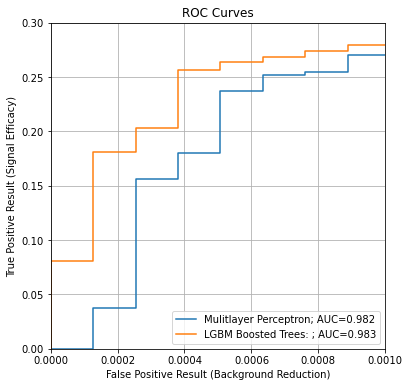

In [162]:
plt.figure().clear()
plt.figure(figsize=[6,6])

plt.title('ROC Curves')
plt.plot(nn_fpr,nn_tpr,label=f'Mulitlayer Perceptron; AUC={auc(nn_fpr,nn_tpr):0.3}')


#plt.plot(fpr,tpr,label=f'Simple Tree; ; AUC={auc(fpr,tpr):0.3}')
#auc(fpr,tpr)

plt.plot(lgbm_fpr,lgbm_tpr,label=f'LGBM Boosted Trees: ; AUC={auc(lgbm_fpr,lgbm_tpr):0.3}')
auc(lgbm_fpr,lgbm_tpr)

#plt.plot(xgb_fpr,xgb_tpr,label=f'XGBoost Trees: ; AUC={auc(xgb_fpr,xgb_tpr):0.3}')
#auc(xgb_fpr,xgb_tpr)

plt.xlim(0,0.001)
plt.ylim(0,0.3)
plt.ylabel('True Positive Result (Signal Efficacy)')
plt.xlabel('False Positive Result (Background Reduction)')
plt.grid(True)
plt.legend()



In [ ]:
i
score1=cross_val_score(dt_clf,X_train,y_train,scoring='roc_auc')
score2=cross_val_score(gbm,X_train,y_train,scoring='roc_auc')
score3=cross_val_score(nn_clf,X_train,y_train,scoring='roc_auc')

In [ ]:
print(f'Precision Cross Validation score for DecisionTree= {score1}')
print(f'Precision Cross Validation score for LGBM= {score2}')
print(f'Precision Cross Validation score for MLP= {score3}')
for x in [score1,score2,score3]:
  print("Cross Validated AUC score = ",np.mean(x),'Plus/Minus',np.std(x))

In [ ]:
print(xgb_tresholds)
a=predictWithCutoff(xgb_clf,X_test,y_test,1.9960545/3)
confusion_matrix(y_test,a)

# Experimental Functions

## Custom ROC Curve

In [26]:
def my_roc_curve_v2(y_true,y_score):
    
    #For classification 1 is positive class 0 is negative class.
    y_true = np.asarray(y_true)
    y_score = np.asarray(y_score)


    desc_score_indices = np.argsort(y_score, kind="mergesort")[::-1]
    y_score = y_score[desc_score_indices]
    y_true = y_true[desc_score_indices]
  
    # y_score typically has many tied values. Here we extract the indices associated with the distinct values. We also concatenate a value for the end of the curve.
    distinct_value_indices = np.where(np.diff(y_score))[0]
    threshold_idxs = np.r_[distinct_value_indices, y_true.size - 1]

    # accumulate the true positives and false positives with decreasing threshold
    tps = np.cumsum(y_true)[threshold_idxs]
    fps = 1 + threshold_idxs - tps
    thresholds=y_score[threshold_idxs]
    
    ############## Now to second part of function #################
    

    
    tps = np.r_[0, tps]
    fps = np.r_[0, fps]
    
    fpr = fps / fps[-1]
    tpr = tps / tps[-1]
    
    thresholds = np.r_[thresholds[0] + 1, thresholds]
    
    
    return fpr, tpr, thresholds



In [27]:
def average_roc_curve_v2(clf, X, y, n_splits=10, n_repeats=100):
    
    cv=RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats)
    
    X=X.to_numpy()
    y=y.to_numpy()
    
    t1,t2,t3=[],[],[]
    
    timecheck0=time.time()
    
    
    for train_index, test_index in cv.split(X,y):
        X_train, y_train = X[train_index], y[train_index]
        X_test, y_test = X[test_index], y[test_index]
        clf.fit(X_train,y_train)
        fpr, tpr, thresholds=my_roc_curve_v2(y_test,clf.predict_proba(X_test)[:,1])
        
        t1.append(fpr)
        t2.append(tpr)
        t3.append(thresholds)
        
        timecheck=time.time() #Check How much time passed.
        timediff=timecheck-timecheck0
        
        print(f"Fits Done: {len(t1)}. Fits Left: {n_repeats*n_splits-len(t1)}")
        print(f" Time Passed: {timediff:0.1f}s, Time Left: {(n_repeats*n_splits-len(t1))/(len(t1)/timediff):0.1f}s")
    return t1,t2,t3

In [28]:
# In this ROC curve i make the training data small and test data large. to get better statistics
def average_roc_curve_v3(clf, X, y, n_splits=10, n_repeats=100):
    
    cv=RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats)
    
    X=X.to_numpy()
    y=y.to_numpy()
    
    t1,t2,t3=[],[],[]
    
    timecheck0=time.time()
    
    
    for train_index, test_index in cv.split(X,y):
        X_test, y_test = X[train_index], y[train_index] # I have Purposefully switched train and test around
        X_train, y_train = X[test_index], y[test_index] # To make for more statistics and lower threshold
        
        clf.fit(X_train,y_train)
        fpr, tpr, thresholds=my_roc_curve_v2(y_test,clf.predict_proba(X_test)[:,1])
        
        t1.append(fpr)
        t2.append(tpr)
        t3.append(thresholds)
        
        timecheck=time.time() #Check How much time passed.
        timediff=timecheck-timecheck0
        
        print(f"Fits Done: {len(t1)}. Fits Left: {n_repeats*n_splits-len(t1)}")
        print(f" Time Passed: {timediff:0.1f}s, Time Left: {(n_repeats*n_splits-len(t1))/(len(t1)/timediff):0.1f}s")
    return t1,t2,t3

In [40]:
# In this ROC curve i make the training data small and test data large. to get better statistics
def average_roc_curve_v3_nn(clf, X, y, n_splits=10, n_repeats=100):
    
    cv=RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats)
    
    X=X.to_numpy()
    y=y.to_numpy()
    
    t1,t2,t3=[],[],[]
    
    timecheck0=time.time()
    
    #Scaling Data
    scalar=RobustScaler()
    #X_train_scaled=scalar.fit_transform(X_train)
    #X_test_scaled=scalar.transform(X_test)
    
    for train_index, test_index in cv.split(X,y):
        
        X_train, y_train = X[test_index], y[test_index] # To make for more statistics and lower threshold
        X_train_scaled=scalar.fit_transform(X_train)        
        
        X_test, y_test = X[train_index], y[train_index]# I have Purposefully switched train and test around
        X_test_scaled=scalar.transform(X_test)
        

        
        clf.fit(X_train_scaled,y_train)
        fpr, tpr, thresholds=my_roc_curve_v2(y_test,clf.predict_proba(X_test_scaled)[:,1])
        
        t1.append(fpr)
        t2.append(tpr)
        t3.append(thresholds)
        
        timecheck=time.time() #Check How much time passed.
        timediff=timecheck-timecheck0
        
        print(f"Fits Done: {len(t1)}. Fits Left: {n_repeats*n_splits-len(t1)}")
        print(f" Time Passed: {timediff:0.1f}s, Time Left: {(n_repeats*n_splits-len(t1))/(len(t1)/timediff):0.1f}s")
    return t1,t2,t3

## EMERGENCY forgot to scale NN. Create new mean roc curves from scaled data:

In [41]:
%%time

#Choose The CLassifier with best Parameters
#I Choose The Parameters Found with Bayesian Optimization, Opimizing for Average-Precision. Second run
best_parameters=OrderedDict([('activation', 'tanh'),
  ('alpha', 1e-07),
  ('beta_1', 0.5545561677659581),
  ('beta_2', 0.5713485660228933),
  ('epsilon', 0.000492036188902597),
  ('hidden_layer_sizes', 200),
  ('learning_rate_init', 0.02199012604107307),
  ('max_iter', 537),
  ('solver', 'adam'),
  ('tol', 0.049795769219370685)])

nn_clf=neural_network.MLPClassifier(**best_parameters)

nn_best4_scaled_average_fpr, nn_best4_scaled_average_tpr, nn_best4_scaled_average_thresholds=average_roc_curve_v3_nn(nn_clf,X,y,n_splits=10,n_repeats=100)

Fits Done: 1. Fits Left: 999
 Time Passed: 0.7s, Time Left: 667.6s
Fits Done: 2. Fits Left: 998
 Time Passed: 1.3s, Time Left: 652.8s
Fits Done: 3. Fits Left: 997
 Time Passed: 2.0s, Time Left: 651.4s
Fits Done: 4. Fits Left: 996
 Time Passed: 2.6s, Time Left: 636.7s
Fits Done: 5. Fits Left: 995
 Time Passed: 3.2s, Time Left: 631.3s
Fits Done: 6. Fits Left: 994
 Time Passed: 3.8s, Time Left: 635.1s
Fits Done: 7. Fits Left: 993
 Time Passed: 4.5s, Time Left: 636.9s
Fits Done: 8. Fits Left: 992
 Time Passed: 5.1s, Time Left: 638.2s
Fits Done: 9. Fits Left: 991
 Time Passed: 5.8s, Time Left: 636.5s
Fits Done: 10. Fits Left: 990
 Time Passed: 6.4s, Time Left: 634.8s
Fits Done: 11. Fits Left: 989
 Time Passed: 7.1s, Time Left: 634.8s
Fits Done: 12. Fits Left: 988
 Time Passed: 7.7s, Time Left: 634.0s
Fits Done: 13. Fits Left: 987
 Time Passed: 8.3s, Time Left: 632.9s
Fits Done: 14. Fits Left: 986
 Time Passed: 9.0s, Time Left: 632.9s
Fits Done: 15. Fits Left: 985
 Time Passed: 9.6s, Time Le

In [42]:
### HERE I WILL SAVE THE DATA FOR FUTURE USE!
import joblib 

for i ,j in zip(['nn_best4_scaled_average_fpr', 'nn_best4_scaled_average_tpr', 'nn_best4_scaled_average_thresholds'],[nn_best4_scaled_average_fpr, nn_best4_scaled_average_tpr, nn_best4_scaled_average_thresholds]):
    joblib.dump(j,i)


In [30]:
#Choose The LGBM CLassifier with best Parameters
#I Choose The Parameters Found with Bayesian Optimization, Opimizing for Average-Precision. Second run
best_parameters=OrderedDict([('boosting_type', 'gbdt'),('learning_rate', 0.08070423147486032),('max_depth', 10),('min_child_samples', 315),('min_child_weight', 17),('n_estimators', 869), ('num_leaves', 20),('reg_alpha', 2), ('reg_lambda', 5)])
lgbm_clf=lgb.LGBMClassifier(**best_parameters)

lgbm_best3_average_fpr, lgbm_best3_average_tpr, lgbm_best3_average_thresholds=average_roc_curve_v3(lgbm_clf,X,y)

Fits Done: 1. Fits Left: 999
 Time Passed: 0.9s, Time Left: 876.0s
Fits Done: 2. Fits Left: 998
 Time Passed: 1.5s, Time Left: 754.9s
Fits Done: 3. Fits Left: 997
 Time Passed: 2.2s, Time Left: 723.5s
Fits Done: 4. Fits Left: 996
 Time Passed: 2.8s, Time Left: 699.9s
Fits Done: 5. Fits Left: 995
 Time Passed: 3.5s, Time Left: 687.2s
Fits Done: 6. Fits Left: 994
 Time Passed: 4.1s, Time Left: 683.0s
Fits Done: 7. Fits Left: 993
 Time Passed: 4.8s, Time Left: 677.5s
Fits Done: 8. Fits Left: 992
 Time Passed: 5.4s, Time Left: 672.7s
Fits Done: 9. Fits Left: 991
 Time Passed: 6.1s, Time Left: 671.3s
Fits Done: 10. Fits Left: 990
 Time Passed: 6.8s, Time Left: 670.8s
Fits Done: 11. Fits Left: 989
 Time Passed: 7.4s, Time Left: 667.2s
Fits Done: 12. Fits Left: 988
 Time Passed: 8.1s, Time Left: 665.5s
Fits Done: 13. Fits Left: 987
 Time Passed: 8.8s, Time Left: 665.0s
Fits Done: 14. Fits Left: 986
 Time Passed: 9.4s, Time Left: 662.8s
Fits Done: 15. Fits Left: 985
 Time Passed: 10.1s, Time L

In [ ]:
### HERE I WILL SAVE THE DATA FOR FUTURE USE!
import joblib 

for i ,j in zip(['lgbm_best3_average_fpr', 'lgbm_best3_average_tpr', 'lgbm_best3_average_thresholds'],[lgbm_best3_average_fpr, lgbm_best3_average_tpr, lgbm_best3_average_thresholds]):
    joblib.dump(j,i)


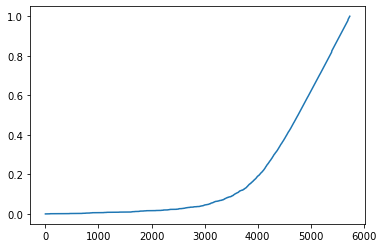

In [192]:
plt.plot(nn_best1_full_average_fpr[100])